In [1]:
import torch
import torch_geometric
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
#torch.manual_seed(1)
import matplotlib.pyplot as plt


In [2]:
# import datasets
import glob
raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/TESTBEAMDATA/TBDGRAPHS/test31052023_l/"
fnamelist = [filepath for filepath in glob.glob(raw_dir+'tbd*.pt')]
data_list = []
tren = []
ctr = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    
    #idx.x = idx.cl2d
    idx.x = idx.rh
    data_list.append(idx)
    tren.append(idx.truen)
    #ctr += 1
    #if ctr > 200:
    #    break

  2%|▏         | 643/30237 [00:02<02:02, 241.40it/s]


KeyboardInterrupt: 

In [5]:
data_list[10].x, data_list[10].batch

(tensor([[-9.7176e-01,  1.6831e+00,  1.0000e+00,  2.0498e-01],
         [-1.9435e+00,  2.2442e+00,  1.0000e+00,  2.4386e-01],
         [-1.9435e+00,  1.1221e+00,  1.0000e+00,  6.9242e-03],
         ...,
         [ 0.0000e+00,  1.1221e+00,  2.5000e+01,  3.1653e-02],
         [-9.7176e-01,  3.9273e+00,  2.5000e+01,  3.5574e-02],
         [-1.9435e+00,  4.4884e+00,  2.5000e+01,  2.2859e-02]]),
 None)

total samples: 1394


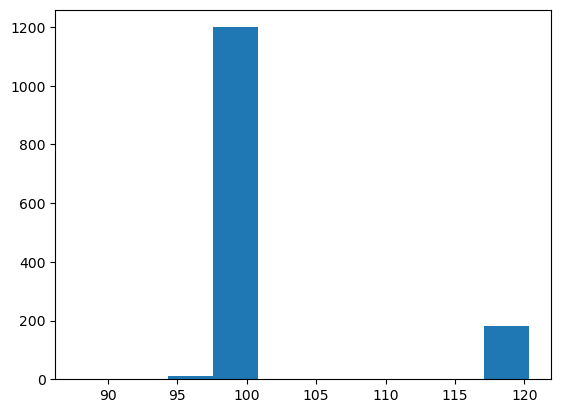

In [7]:
print("total samples:",len(data_list))
plt.hist(tren)
plt.show()

In [5]:
totalev = len(data_list)
ntrain = int(0.8*totalev)
import random
random.shuffle(data_list)
ntrainbatch = 200
ntestbatch = 100
trainloader = torch_geometric.data.DataLoader(data_list[:ntrain], batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(data_list[ntrain:], batch_size=ntestbatch)
#batch_size = ntrainbatch
epoch_size = len(data_list[:ntrain])
print("epoch size,batch_size:",epoch_size,ntrainbatch)

epoch size,batch_size: 1522 200


/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-torch/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
np.unique(next(iter(testloader)).batch.numpy(), return_counts=True)#.cl2d#.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([601, 608, 530, 499, 564, 625, 489, 562, 579, 506, 590, 465, 550,
        564, 522, 599, 494, 512, 579, 491, 506, 487, 578, 537, 589, 536,
        607, 553, 509, 546, 511, 530, 531, 590, 582, 498, 481, 514, 514,
        528, 567, 541, 496, 548, 461, 503, 486, 515, 552, 613, 537, 510,
        581, 542, 508, 543, 603, 592, 617, 486, 593, 542, 560, 536, 589,
        602, 498, 582, 466, 578, 528, 570, 596, 490, 493, 560, 500, 599,
        444, 618, 552, 570, 477, 509, 577, 510, 517, 538, 530, 558, 527,
        532, 511, 508, 555, 477, 517, 4

In [7]:
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=True)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        
        #print(data.batch)
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv3.flow))
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        ####
        ####
        #data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        #data.x = self.edgeconv3(data.x, data.edge_index)
        
        #weight = normalized_cut_2d(data.edge_index, data.x)
        #cluster = graclus(data.edge_index, weight, data.x.size(0))
        #data.edge_attr = None
        #data = max_pool(cluster, data)
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_max_pool(x, batch)
#        print(self.output(x))
        return self.output(x).squeeze(-1)

In [9]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
import math
import torch
import sys

class ReduceMaxLROnRestart:
    def __init__(self, ratio=0.75):
        self.ratio = ratio
        
        def __call__(self, eta_min, eta_max):
            return eta_min, eta_max * self.ratio
        
        
class ExpReduceMaxLROnIteration:
    def __init__(self, gamma=1):
        self.gamma = gamma
        
    def __call__(self, eta_min, eta_max, iterations):
        return eta_min, eta_max * self.gamma ** iterations


class CosinePolicy:
    def __call__(self, t_cur, restart_period):
        return 0.5 * (1. + math.cos(math.pi *
                                    (t_cur / restart_period)))
    
    
class ArccosinePolicy:
    def __call__(self, t_cur, restart_period):
        return (math.acos(max(-1, min(1, 2 * t_cur
                                      / restart_period - 1))) / math.pi)
    
    
class TriangularPolicy:
    def __init__(self, triangular_step=0.5):
        self.triangular_step = triangular_step
        
    def __call__(self, t_cur, restart_period):
        inflection_point = self.triangular_step * restart_period
        point_of_triangle = (t_cur / inflection_point
                             if t_cur < inflection_point
                             else 1.0 - (t_cur - inflection_point)
                             / (restart_period - inflection_point))
        return point_of_triangle
    
    
class CyclicLRWithRestarts(_LRScheduler):
    """Decays learning rate with cosine annealing, normalizes weight decay
    hyperparameter value, implements restarts.
    https://arxiv.org/abs/1711.05101
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        batch_size: minibatch size
        epoch_size: training samples per epoch
        restart_period: epoch count in the first restart period
        t_mult: multiplication factor by which the next restart period will expand/shrink
        policy: ["cosine", "arccosine", "triangular", "triangular2", "exp_range"]
        min_lr: minimum allowed learning rate
        verbose: print a message on every restart
        gamma: exponent used in "exp_range" policy
        eta_on_restart_cb: callback executed on every restart, adjusts max or min lr
        eta_on_iteration_cb: callback executed on every iteration, adjusts max or min lr
        triangular_step: adjusts ratio of increasing/decreasing phases for triangular policy
    Example:
        >>> scheduler = CyclicLRWithRestarts(optimizer, 32, 1024, restart_period=5, t_mult=1.2)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>         ...
        >>>         optimizer.zero_grad()
        >>>         loss.backward()
        >>>         optimizer.step()
        >>>         scheduler.batch_step()
        >>>     validate(...)
    """
    
    def __init__(self, optimizer, batch_size, epoch_size, restart_period=100,
                 t_mult=2, last_epoch=-1, verbose=False,
                 policy="cosine", policy_fn=None, min_lr=1e-7,
                 eta_on_restart_cb=None, eta_on_iteration_cb=None,
                 gamma=1.0, triangular_step=0.5):
        
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
                group.setdefault('minimum_lr', min_lr)
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an"
                                   " optimizer".format(i))
                
        self.base_lrs = [group['initial_lr'] for group
                         in optimizer.param_groups]
        
        self.min_lrs = [group['minimum_lr'] for group
                        in optimizer.param_groups]
        
        self.base_weight_decays = [group['weight_decay'] for group
                                   in optimizer.param_groups]
        
        self.policy = policy
        self.eta_on_restart_cb = eta_on_restart_cb
        self.eta_on_iteration_cb = eta_on_iteration_cb
        if policy_fn is not None:
            self.policy_fn = policy_fn
        elif self.policy == "cosine":
            self.policy_fn = CosinePolicy()
        elif self.policy == "arccosine":
            self.policy_fn = ArccosinePolicy()
        elif self.policy == "triangular":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
        elif self.policy == "triangular2":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
            self.eta_on_restart_cb = ReduceMaxLROnRestart(ratio=0.5)
        elif self.policy == "exp_range":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
            self.eta_on_iteration_cb = ExpReduceMaxLROnIteration(gamma=gamma)
            
        self.last_epoch = last_epoch
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        
        self.iteration = 0
        self.total_iterations = 0
        
        self.t_mult = t_mult
        self.verbose = verbose
        self.restart_period = math.ceil(restart_period)
        self.restarts = 0
        self.t_epoch = -1
        self.epoch = -1
        
        self.eta_min = 0
        self.eta_max = 1
        
        self.end_of_period = False
        self.batch_increments = []
        self._set_batch_increment()
        
    def _on_restart(self):
        if self.eta_on_restart_cb is not None:
            self.eta_min, self.eta_max = self.eta_on_restart_cb(self.eta_min,
                                                                self.eta_max)
            
    def _on_iteration(self):
        if self.eta_on_iteration_cb is not None:
            self.eta_min, self.eta_max = self.eta_on_iteration_cb(self.eta_min,
                                                                  self.eta_max,
                                                                  self.total_iterations)
            
    def get_lr(self, t_cur):
        eta_t = (self.eta_min + (self.eta_max - self.eta_min)
                 * self.policy_fn(t_cur, self.restart_period))
        
        weight_decay_norm_multi = math.sqrt(self.batch_size /
                                            (self.epoch_size *
                                             self.restart_period))
        
        lrs = [min_lr + (base_lr - min_lr) * eta_t for base_lr, min_lr
               in zip(self.base_lrs, self.min_lrs)]
        weight_decays = [base_weight_decay #* eta_t * weight_decay_norm_multi
                         for base_weight_decay in self.base_weight_decays]
        
        if (self.t_epoch + 1) % self.restart_period < self.t_epoch:
            self.end_of_period = True
            
        if self.t_epoch % self.restart_period < self.t_epoch:
            if self.verbose:
                print("Restart {} at epoch {}".format(self.restarts + 1,
                                                      self.last_epoch))
            self.restart_period = math.ceil(self.restart_period * self.t_mult)
            self.restarts += 1
            self.t_epoch = 0
            self._on_restart()
            self.end_of_period = False
            
        return zip(lrs, weight_decays)
        
    def _set_batch_increment(self):
        d, r = divmod(self.epoch_size, self.batch_size)
        batches_in_epoch = d + 2 if r > 0 else d + 1
        self.iteration = 0
        self.batch_increments = torch.linspace(0, 1, batches_in_epoch).tolist()
        
    def step(self):
        self.last_epoch += 1
        self.t_epoch += 1
        self._set_batch_increment()
        self.batch_step()
        
    def batch_step(self):
        try:
            t_cur = self.t_epoch + self.batch_increments[self.iteration]
            self._on_iteration()
            self.iteration += 1
            self.total_iterations += 1
        except (IndexError):
            raise StopIteration("Epoch size and batch size used in the "
                                "training loop and while initializing "
                                "scheduler should be the same.")
        
        for param_group, (lr, weight_decay) in zip(self.optimizer.param_groups,
                                                   self.get_lr(t_cur)):
            param_group['lr'] = lr
            param_group['weight_decay'] = weight_decay

In [48]:


#from models.DynamicReductionNetwork import DynamicReductionNetwork

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = DynamicReductionNetwork(input_dim=4,hidden_dim=20,k=10,output_dim=1,norm=torch.tensor([ 1., 1., 1., 1.]))
        
    def forward(self, data):
        logits = self.drn(data)
        #return F.softplus(logits)
        return logits
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=80, t_mult=1.2, policy="cosine")
#criterion = torch.nn.MSELoss()

#lossmse = nn.MSELoss()
def resoloss2(output,truth):
    """ Computes MSE loss between output and truth """
    batch_size = output.size()[0]
    mse = F.mse_loss(output, truth, reduction='mean')
    #mse = torch.sum((output-truth)**2/truth)/batch_size
    #mse = torch.sum(((output-truth)/truth)**2)/batch_size
    #mse = torch.mean(torch.abs((output - truth)))
    
    #res = 
    return (mse)

def resoloss3(output,truth):
    #batch_size = output.size()[0]
    #mse = F.mse_loss(output, truth, reduction='mean')
    #mse = torch.sum((output-truth)**2/truth)/batch_size
    #mse = torch.sum(((output-truth)/truth)**2)/batch_size
    #mse = torch.mean(torch.abs((output - truth)))
    #outputa = output[truth < 1.0]
    #outputa = output[truth > 1.0]
    loss1 = torch.mean(torch.abs((output[truth < 1.0] - truth[truth < 1.0])))
    batch_size = len(output[truth > 1.0])
    #loss2 = torch.sum((output[truth > 1.0] -truth[truth > 1.0] )**2/truth[truth > 1.0] )/batch_size
    loss2 = torch.sum((output[truth > 1.0] -truth[truth > 1.0] )**2 )/batch_size

    #res = 
    return loss1+loss2
    

    
def resoloss(outputa,trutha):
    n_bins = np.random.poisson(20) + 2
    minx = torch.min(trutha).detach().cpu()
    maxx = torch.max(trutha).detach().cpu()
    minx = np.exp(minx)
    maxx = np.exp(maxx)
    
    binss = np.arange(minx,maxx,(maxx-minx)/n_bins)
    binss = np.log(binss)
    loss = 0.
    for i in range(binss.size-1):
        tmpo = outputa[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
        tmpt = trutha[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
        #print("tmpo,tmpt:",tmpo,tmpt)
        if (list(tmpo.size())[0] == 0 or list(tmpt.size())[0] == 0):
            continue
        #print(list(tmpo.size())[0],list(tmpt.size())[0])
        tmpom = torch.mean(tmpo)
        tmptm = torch.mean(tmpt)
        #print (tmpom,tmptm)
        #if (tmptm == 0):
        #    continue
        
        #    if ((tmpom - tmptm)**2/tmptm is not np.nan):
        #        print ("(tmpom - tmptm)**2/tmptm",(tmpom - tmptm)**2/tmptm)
        loss += (tmpom - tmptm)**2/tmptm
    
    
    if (loss == 0.):
        print("minx,maxx,binss,n_bins:",minx,maxx,binss,n_bins)    
        print(outputa,trutha)
        for i in range(binss.size-1):
            tmpo = outputa[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
            tmpt = trutha[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
            print("tmpo,tmpt:",tmpo,tmpt)
            if (list(tmpo.size())[0] == 0 or list(tmpt.size())[0] == 0):
                continue
            #print(list(tmpo.size())[0],list(tmpt.size())[0])
            tmpom = torch.mean(tmpo)
            tmptm = torch.mean(tmpt)
            print (tmpom,tmptm)
            loss += (tmpom - tmptm)**2/tmptm
            print(loss)
        
    #print("loss: ",loss)
    return loss        
losscat = torch.nn.CrossEntropyLoss()    
def categorical_loss(outputa,trutha,alpha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) + alpha*resoloss(outputa[:,2],trutha[:,1])
    return total_loss


def categorical_loss_only(outputa,trutha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) 
    return total_loss


#model.train()
def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            result = model(data)
            lossc = resoloss2(result, data.truen)
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))

from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#%matplotlib inline

def gaussian(x,  mean,a, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        torch.cuda.empty_cache()
        model.eval()
        pred = []
        true = []
        loss= []
        
        correct = 0
        predc = []
        truec = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data)
            lossc = resoloss2(result, data.truen)

            loss.append(lossc.item())

            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data.truen.detach():
                true.append(i.detach().cpu())

        print('batches for test:', len(loss)) 
        print('test loss:',np.mean(np.array(loss)))
#        fracarr = np.array(frac

        
        preda = np.array(pred)
        """ Array of predictions (beam energy) """
        truea = np.array(true)
        """ Array of true beam energy """
        #preda = preda[:,2] ### added
        #truea = truea[:,1] ### added
        fracarr = (preda - truea)/truea
        """ Array of (prediction - truth)/truth """
        #print(preda,truea,fracarr)
        print('pred - true / true mean:',(np.mean(fracarr)))
        print('pred - true / true std:',(np.std(fracarr)))
        (mu, sigma) = norm.fit(fracarr)
        """ gaussian fit of (prediction - truth)/truth """
        print('mu,sig:',mu,sigma)
        

        #bin_heights, bin_borders, _ = plt.hist(fracarr,range=[-2,2], bins=100, label='histogram')
        #bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        
        #### Histogram of (pred - true) / true 
        from matplotlib.pyplot import figure
        figure(figsize=(30, 20), dpi=40)
        plt.rcParams['axes.labelsize'] = 36
        plt.rcParams['axes.titlesize'] = 36
        plt.hist(fracarr,bins=100,range=[-4,4])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.axvline(x=0.0,c='r')
        plt.show()
        
        '''
        bins =  np.linspace(0,18,19)

        fig, axs = plt.subplots(6,3, figsize=(40, 40), facecolor='w', edgecolor='k')
        axs = axs.ravel()

        for i in tqdm(range (bins.size - 1)):
            predaa = preda[(truea >bins[i]) & (truea <bins[i+1]) ]
            trueaa = truea[(truea >bins[i]) & (truea <bins[i+1]) ]
            fracarr = (predaa - trueaa)/trueaa
            #if (fracarr < 0):
            axs[i].hist(fracarr,bins=100,range=[-4,4],)
            axs[i].set_xlabel('pred - true / true')
            axs[i].set_ylabel('counts')
            axs[i].set_title(str(bins[i])+" to "+str(bins[i+1]))
            #print (vals)
        if (epoch%5==0):
            plt.savefig('%s/mt-mp_frac_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()'''
        
        '''try:
            from matplotlib.pyplot import figure
            figure(figsize=(20, 10), dpi=30)
            plt.rcParams['axes.labelsize'] = 16
            plt.rcParams['axes.titlesize'] = 16
            popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 100., 1.],bounds = ([-np.inf,0,0],[np.inf,np.inf,np.inf]))
            x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 100)
            plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
            plt.legend()


            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.yscale("log")
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(popt[0], popt[2]))
            plt.grid(True)

            plt.show()

        except RuntimeError:
            print("Error - curve_fit failed")
            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title('pred - true / true fit failed')
            #plt.yscale("log")
            plt.grid(True)

            plt.show()'''
        ### Scatter of true beam energy (x) vs predicted beam energy (y)
        from matplotlib.pyplot import figure
        figure(figsize=(30, 30), dpi=40)
        #plt.rcParams['axes.labelsize'] = 36
        #plt.rcParams['axes.titlesize'] = 36
        #plt.hist2d(truea,preda,bins=200)
        plt.scatter(truea,preda,alpha=0.4)
        plt.plot([0,500], [0,500], 'k-')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.xlim([-2, 18])
        #plt.ylim([-2, 20])
        plt.axvline(x=1.0,c='r')
        plt.axhline(y=1.0,c='r')
        plt.show()
        if (epoch%5 ==0):
            plt.savefig('%s/mpredVsmtrue_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.show()
        return np.mean(np.array(loss))
        #del pred,true,loss,preda,truea,fracarr  #memtest


epoch: 0


100%|██████████| 121/121 [00:16<00:00,  7.19it/s]


batches for train: 121
train loss: 18307.124051685176


100%|██████████| 61/61 [00:03<00:00, 18.52it/s]


batches for test: 61
test loss: 19242.490586577867
pred - true / true mean: -0.50619936
pred - true / true std: 0.17725459
mu,sig: -0.50619936 0.17725459


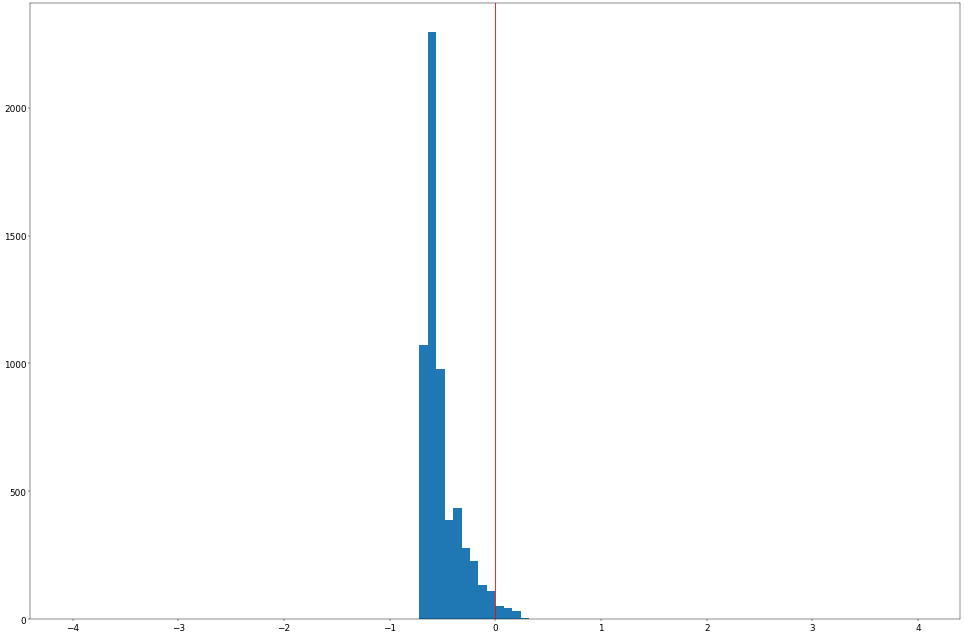

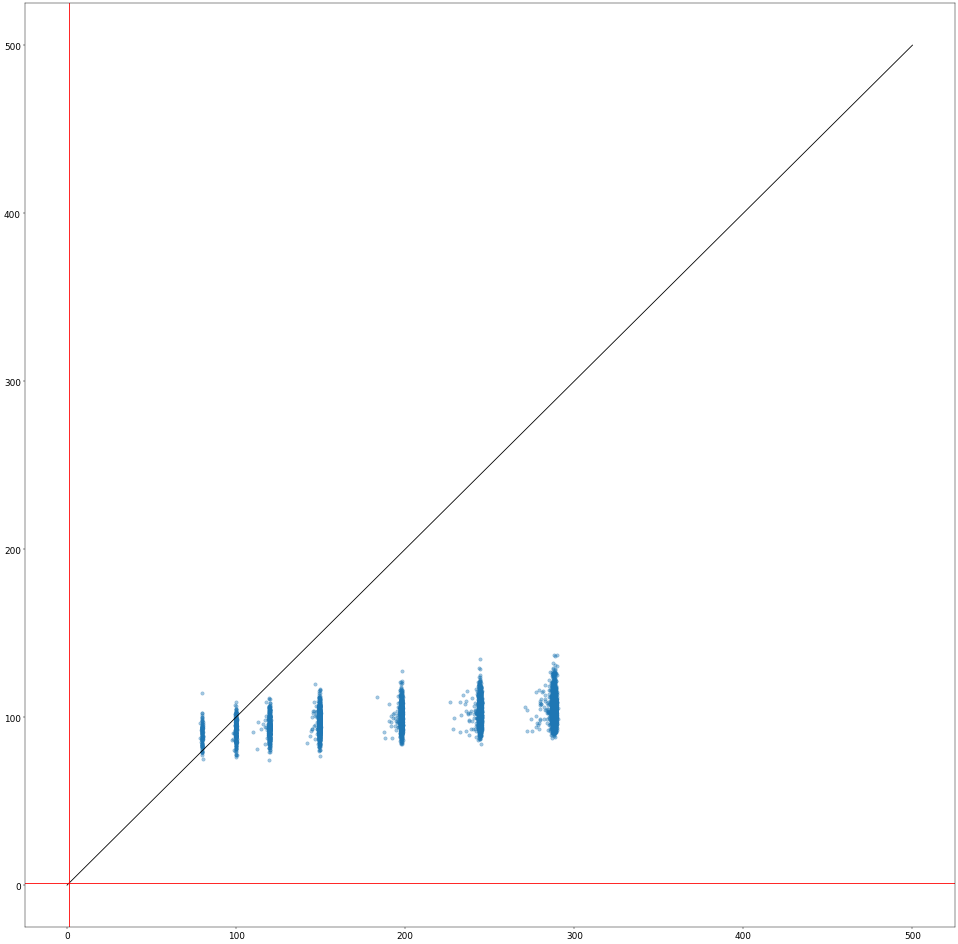

new best test loss: 19242.490586577867
epoch: 1


100%|██████████| 121/121 [00:16<00:00,  7.33it/s]


batches for train: 121
train loss: 8844.887707418648


100%|██████████| 61/61 [00:03<00:00, 18.51it/s]


batches for test: 61
test loss: 18620.50073642418
pred - true / true mean: -0.49847034
pred - true / true std: 0.17323999
mu,sig: -0.49847034 0.17323999


<Figure size 640x480 with 0 Axes>

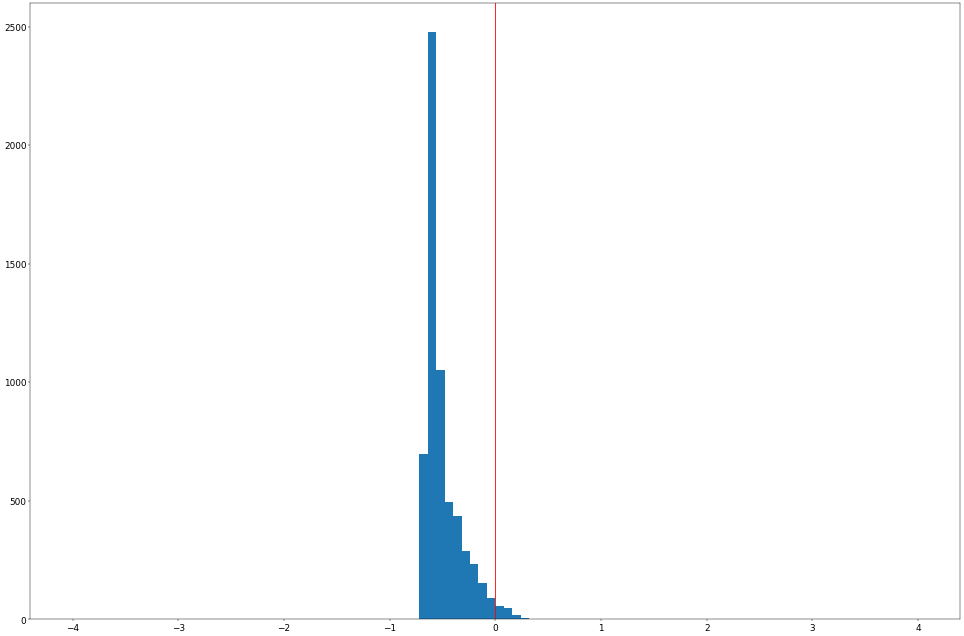

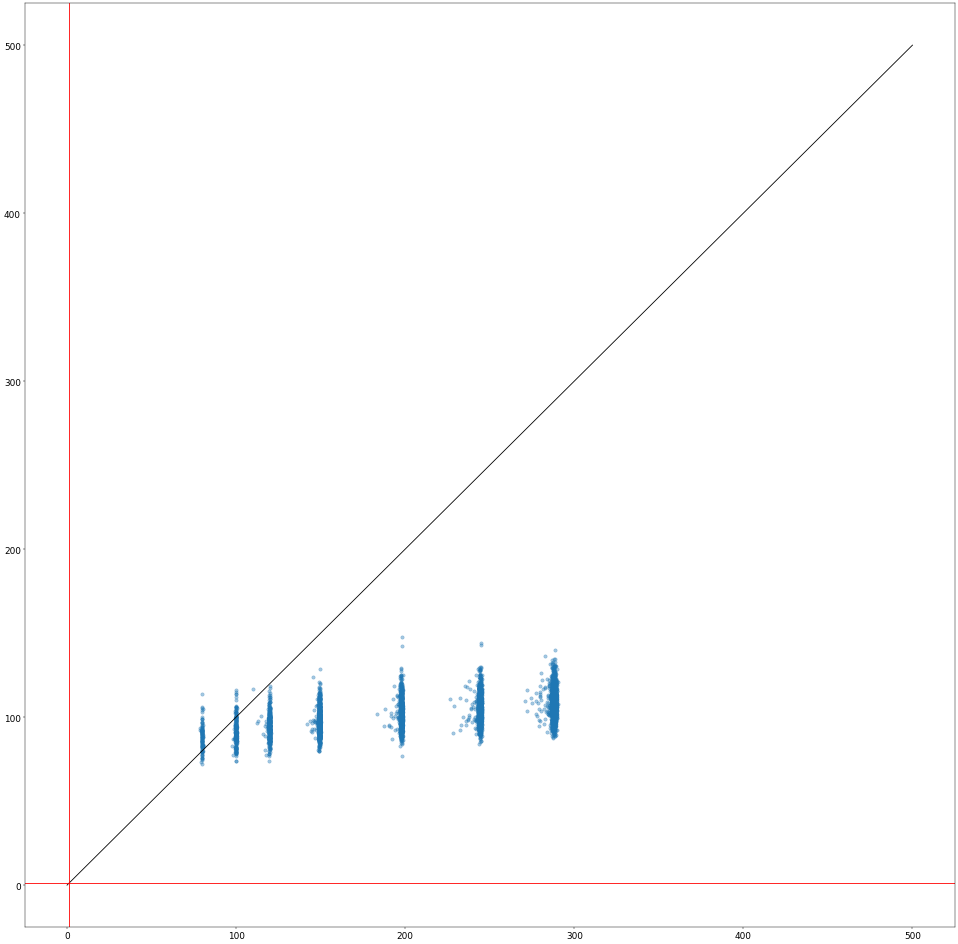

new best test loss: 18620.50073642418
epoch: 2


100%|██████████| 121/121 [00:16<00:00,  7.50it/s]


batches for train: 121
train loss: 8100.448048489153


100%|██████████| 61/61 [00:03<00:00, 17.26it/s]


batches for test: 61
test loss: 16744.81374871926
pred - true / true mean: -0.47676143
pred - true / true std: 0.15723369
mu,sig: -0.47676143 0.15723369


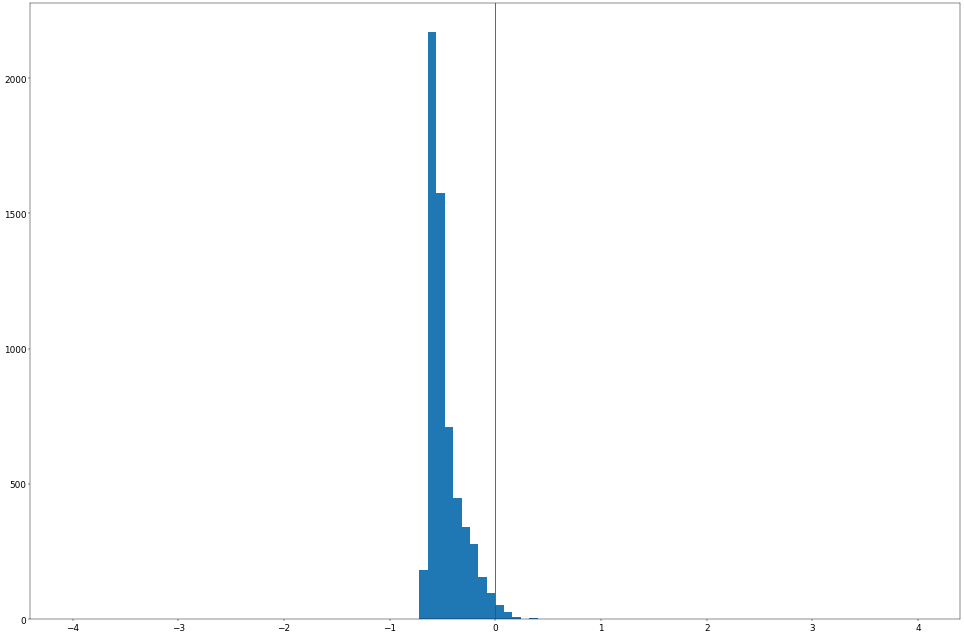

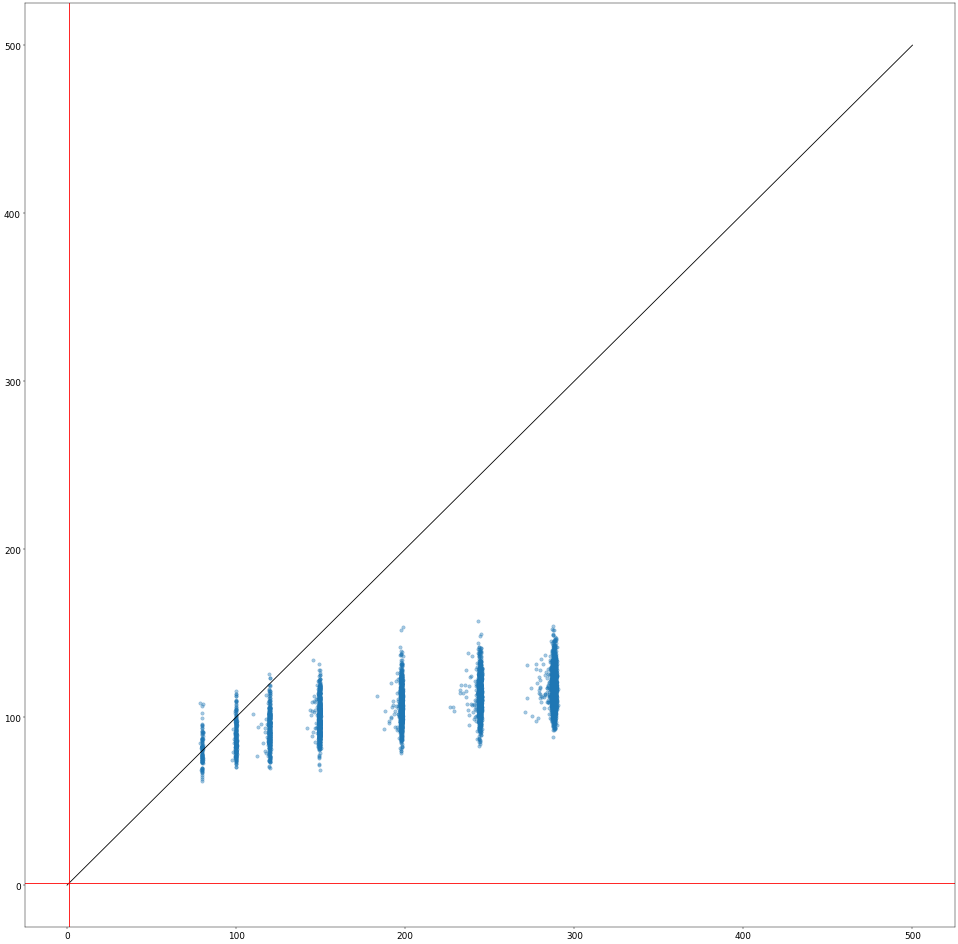

new best test loss: 16744.81374871926
epoch: 3


100%|██████████| 121/121 [00:16<00:00,  7.27it/s]


batches for train: 121
train loss: 7401.905136234504


100%|██████████| 61/61 [00:03<00:00, 15.97it/s]


batches for test: 61
test loss: 27722.425140881147
pred - true / true mean: -0.68921036
pred - true / true std: 0.056812916
mu,sig: -0.68921036 0.056812916


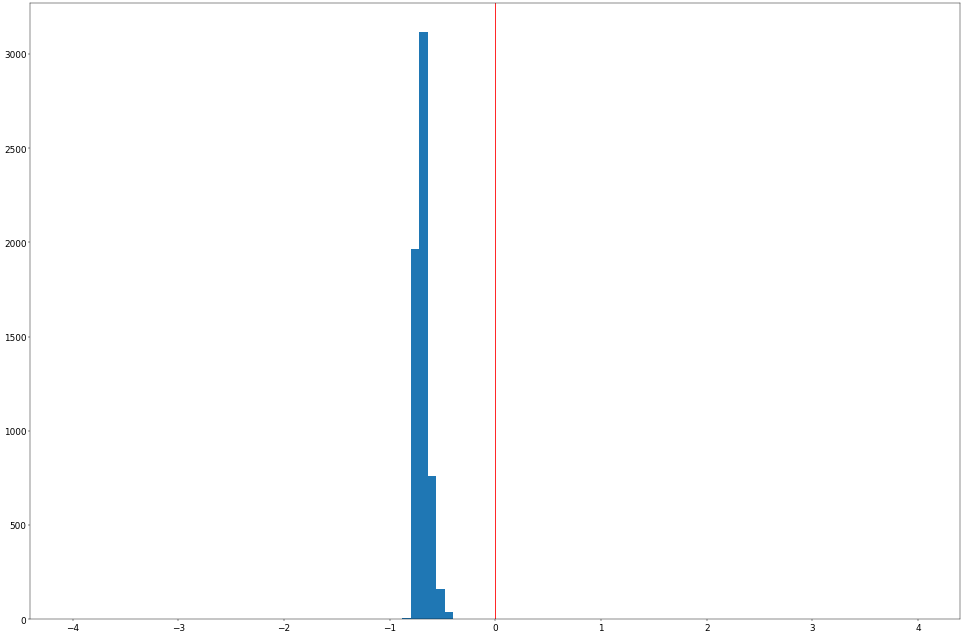

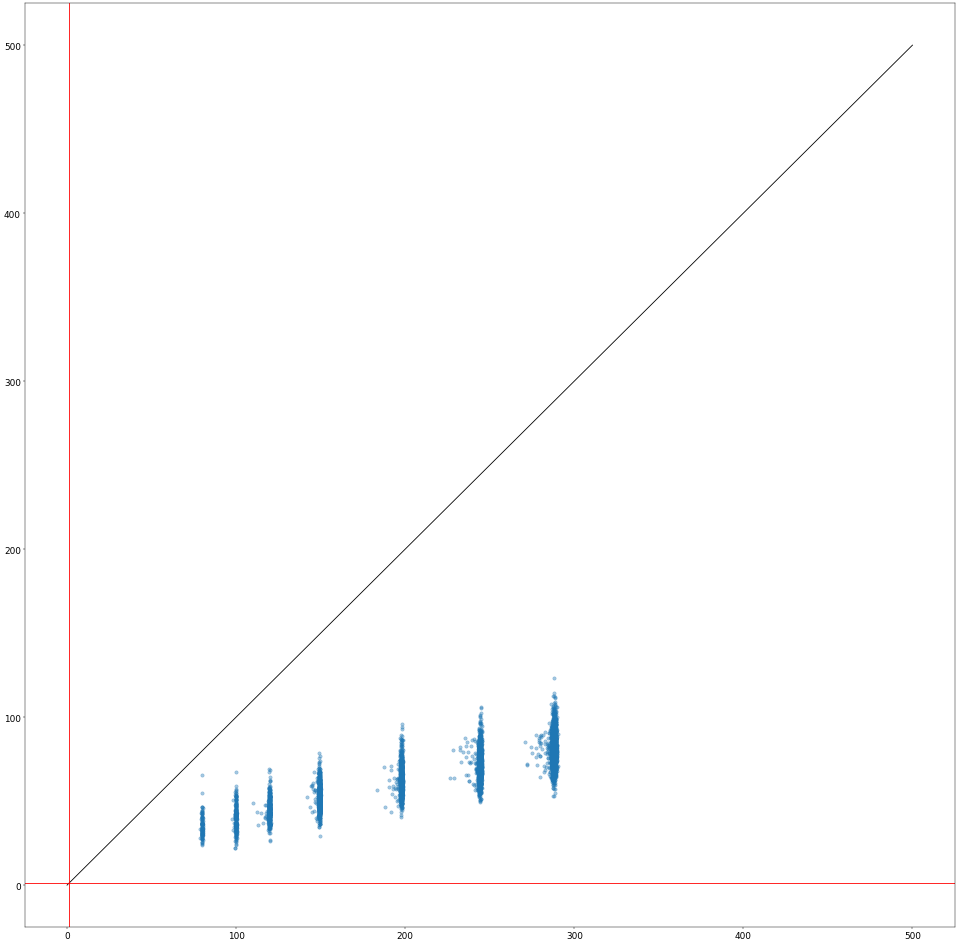

epoch: 4


100%|██████████| 121/121 [00:16<00:00,  7.13it/s]


batches for train: 121
train loss: 6427.244891206095


100%|██████████| 61/61 [00:03<00:00, 15.74it/s]


batches for test: 61
test loss: 26938.269595286885
pred - true / true mean: -0.6907049
pred - true / true std: 0.05679123
mu,sig: -0.6907049 0.05679123


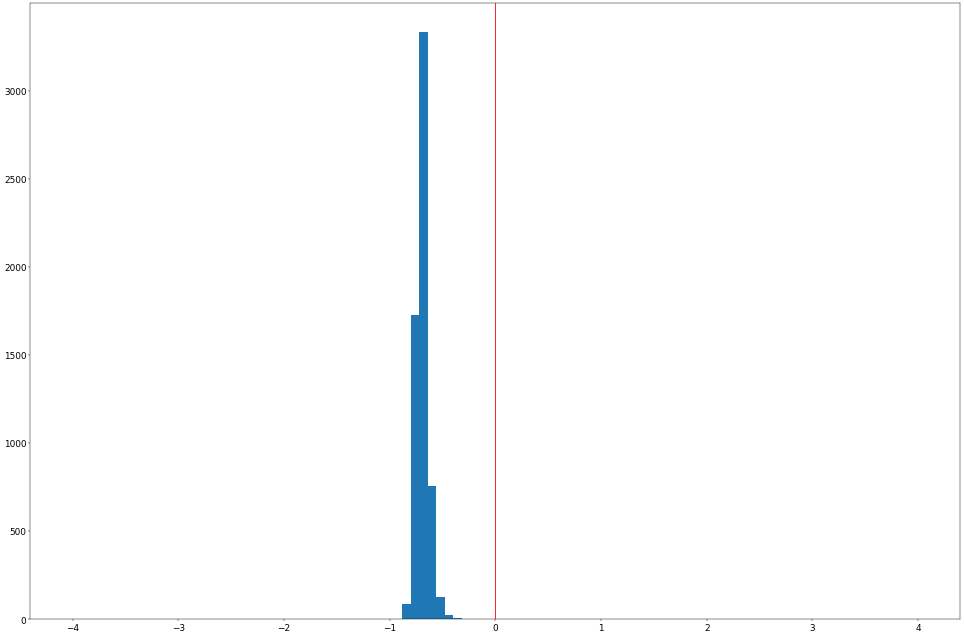

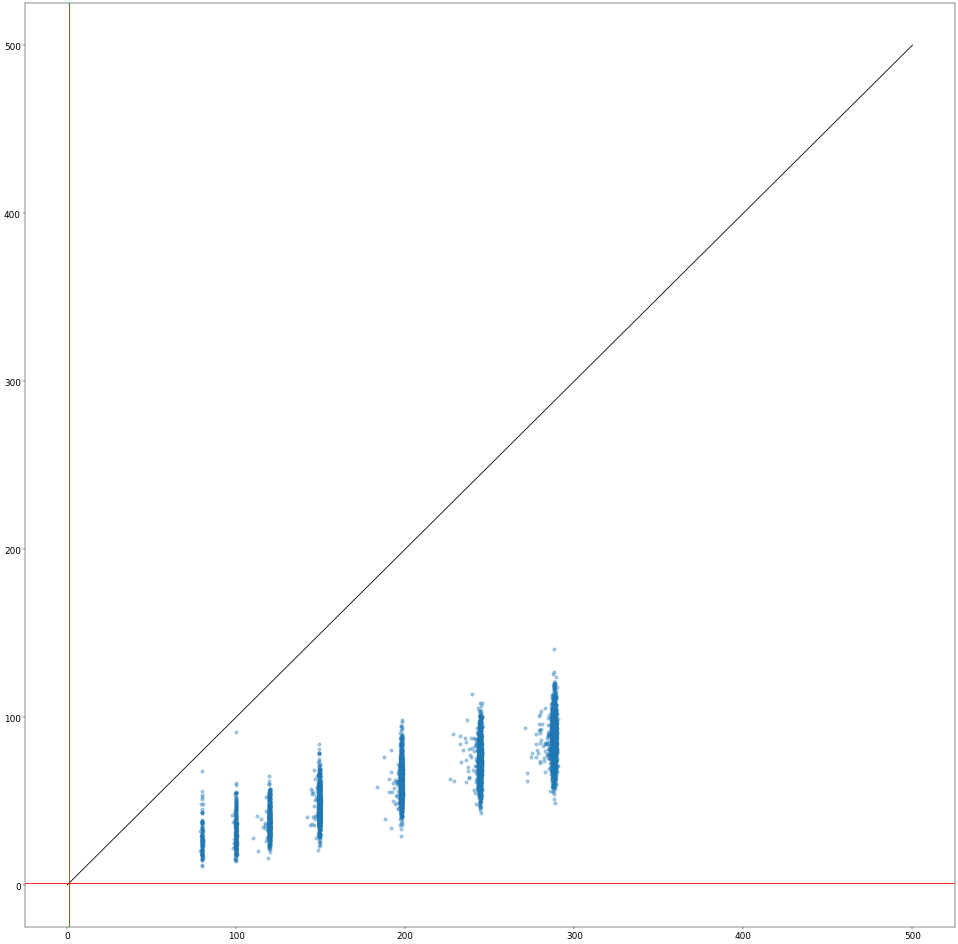

epoch: 5


100%|██████████| 121/121 [00:17<00:00,  7.06it/s]


batches for train: 121
train loss: 6041.64570554623


100%|██████████| 61/61 [00:03<00:00, 15.38it/s]


batches for test: 61
test loss: 25473.094102202867
pred - true / true mean: -0.676004
pred - true / true std: 0.057379525
mu,sig: -0.676004 0.057379525


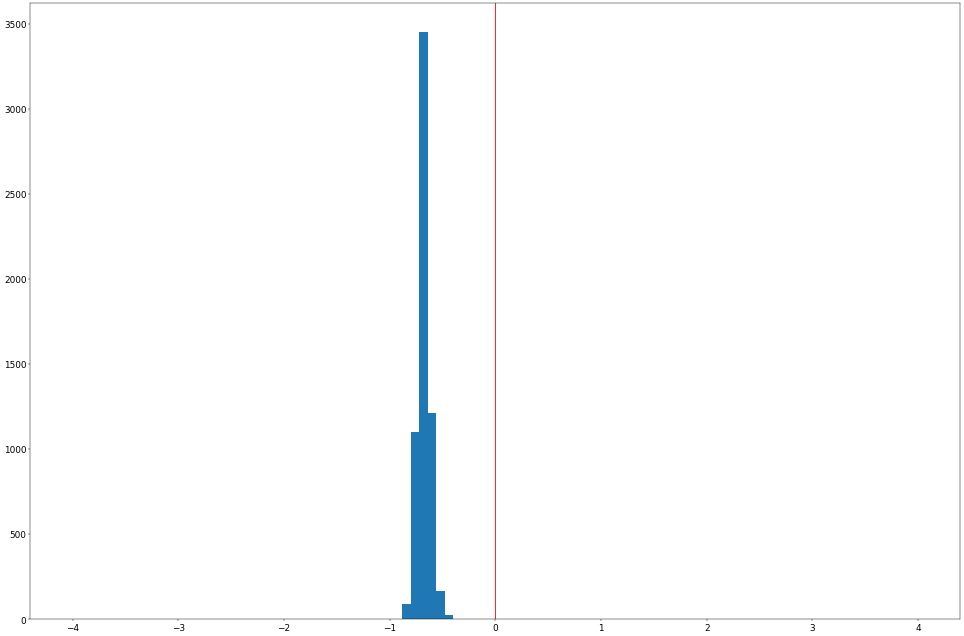

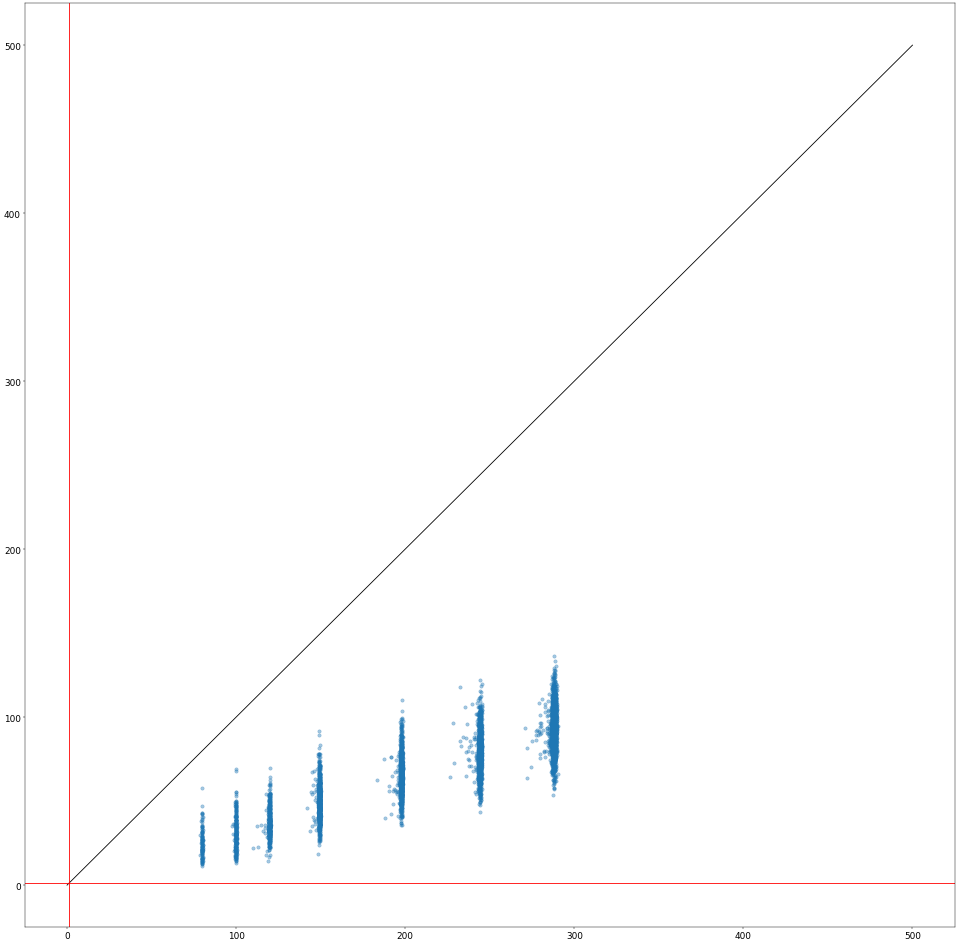

epoch: 6


100%|██████████| 121/121 [00:17<00:00,  7.05it/s]


batches for train: 121
train loss: 5805.591736344267


100%|██████████| 61/61 [00:03<00:00, 15.67it/s]


batches for test: 61
test loss: 29124.397925204918
pred - true / true mean: -0.7271658
pred - true / true std: 0.049078736
mu,sig: -0.7271658 0.049078736


<Figure size 640x480 with 0 Axes>

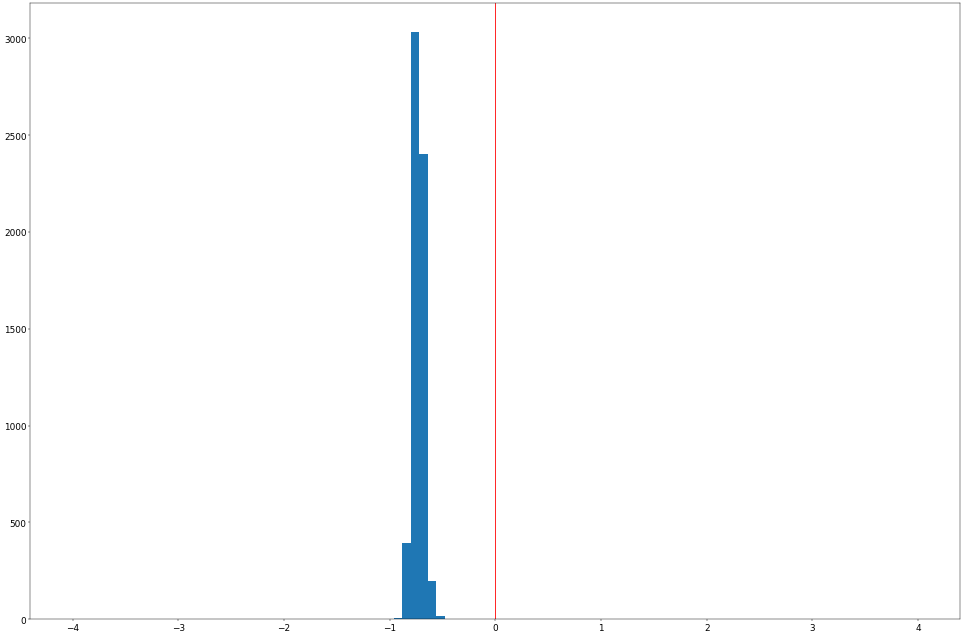

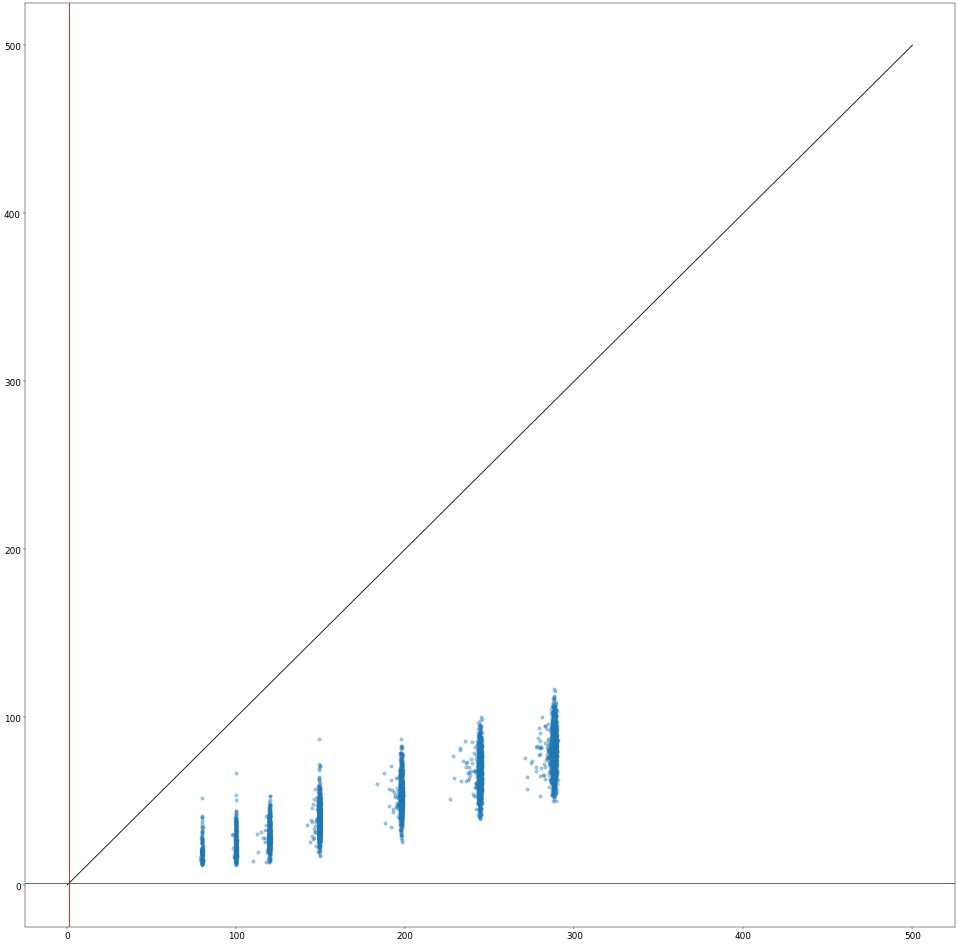

epoch: 7


100%|██████████| 121/121 [00:17<00:00,  7.04it/s]


batches for train: 121
train loss: 5530.008248321281


100%|██████████| 61/61 [00:03<00:00, 15.93it/s]


batches for test: 61
test loss: 24321.056352459018
pred - true / true mean: -0.6707324
pred - true / true std: 0.055497374
mu,sig: -0.6707324 0.055497374


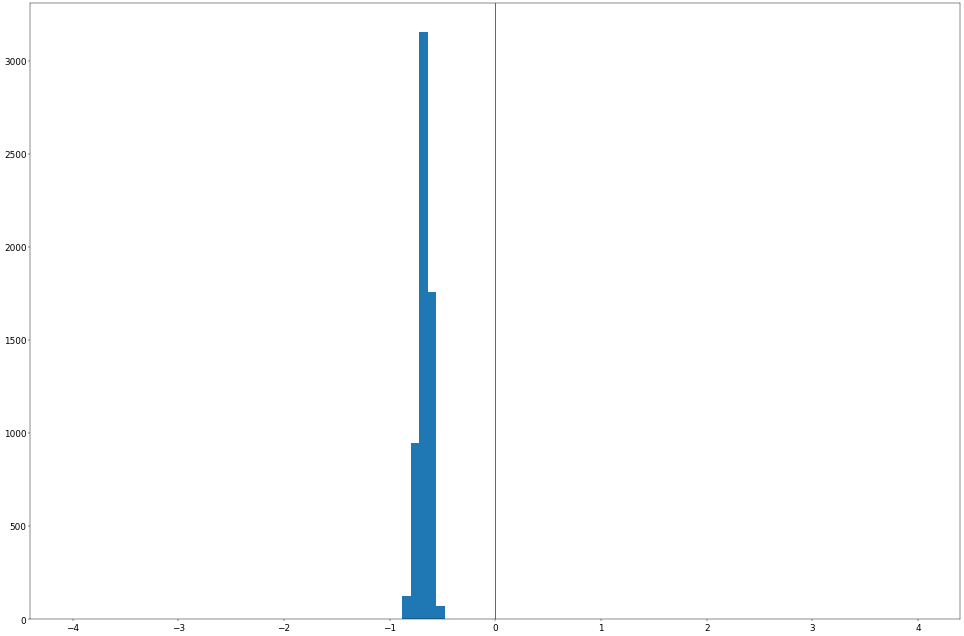

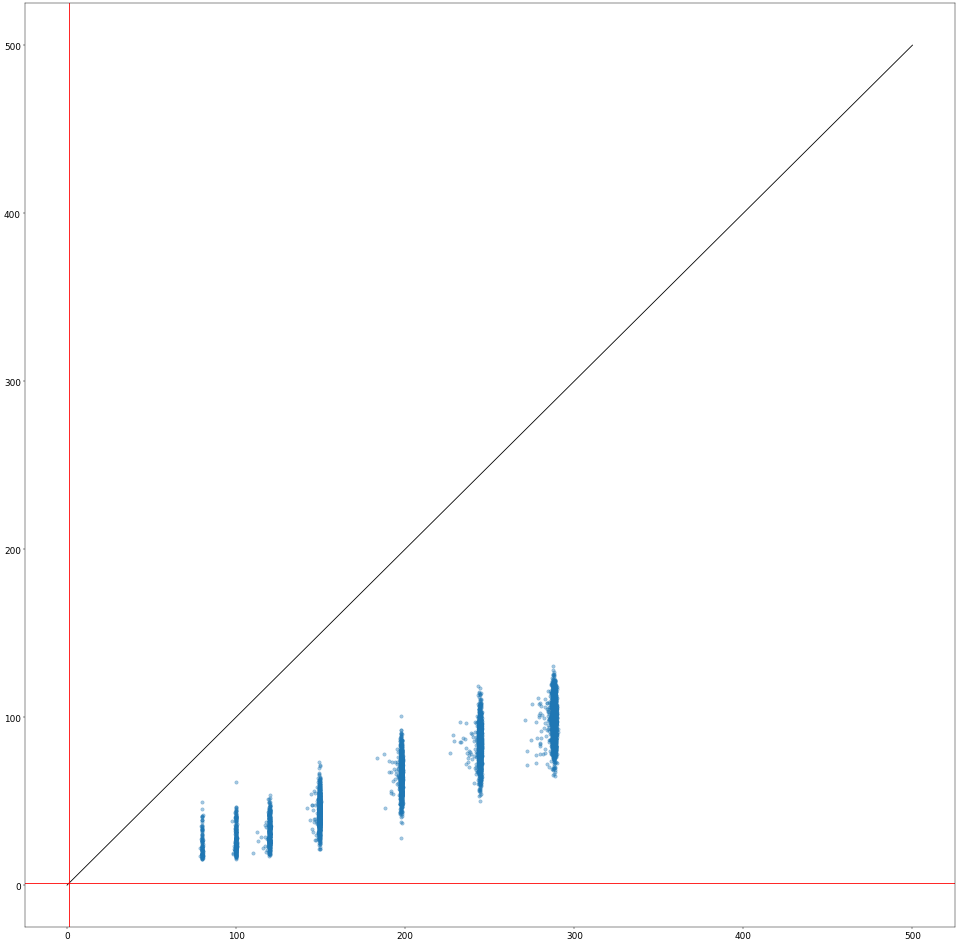

epoch: 8


100%|██████████| 121/121 [00:17<00:00,  7.05it/s]


batches for train: 121
train loss: 5240.526575009685


100%|██████████| 61/61 [00:03<00:00, 16.12it/s]


batches for test: 61
test loss: 19754.401831454918
pred - true / true mean: -0.60871136
pred - true / true std: 0.05485438
mu,sig: -0.60871136 0.05485438


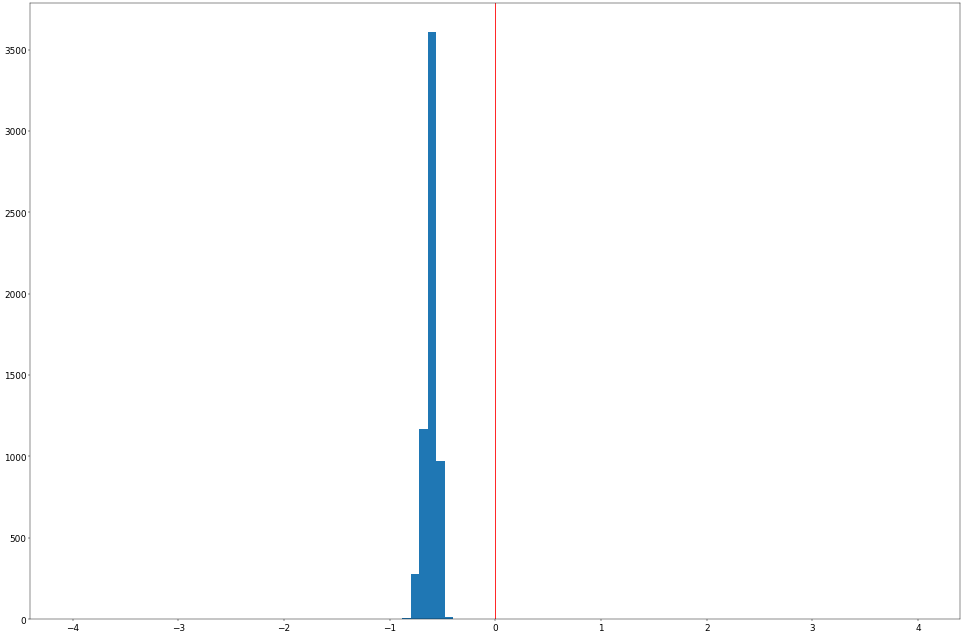

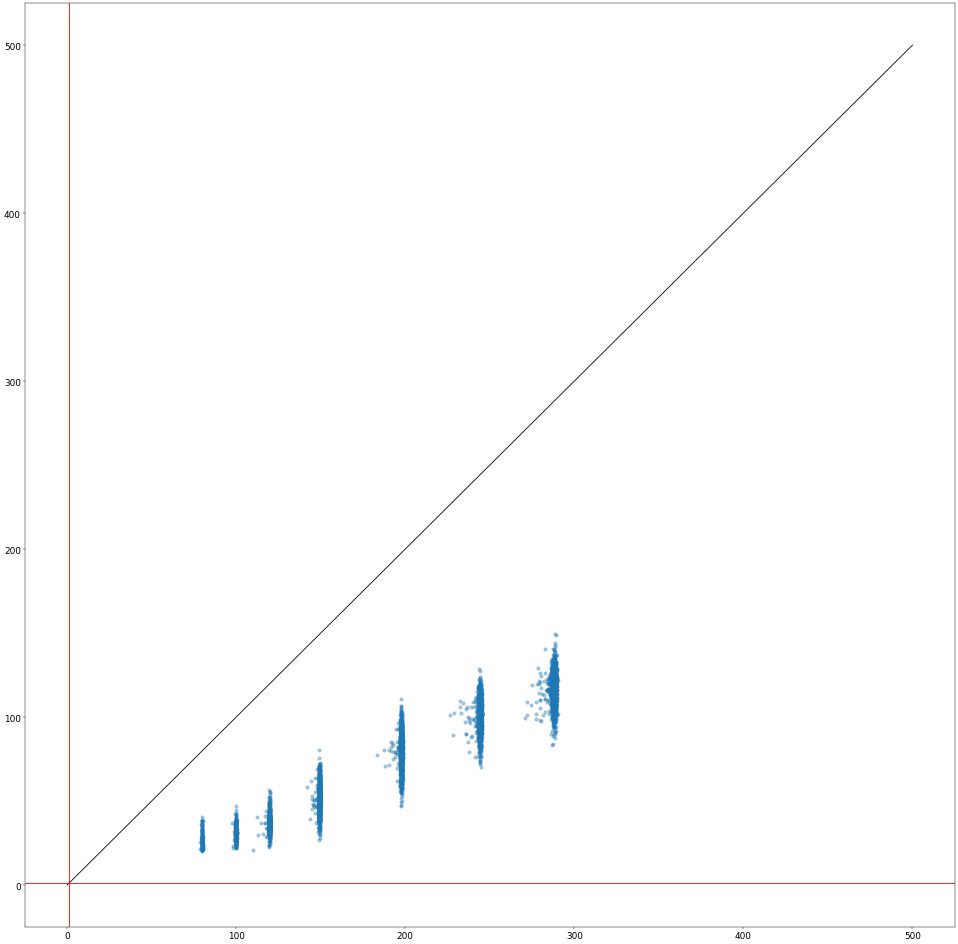

epoch: 9


100%|██████████| 121/121 [00:17<00:00,  7.04it/s]


batches for train: 121
train loss: 5193.496462987474


100%|██████████| 61/61 [00:03<00:00, 16.22it/s]


batches for test: 61
test loss: 16741.309106045082
pred - true / true mean: -0.5600589
pred - true / true std: 0.054679196
mu,sig: -0.5600589 0.054679196


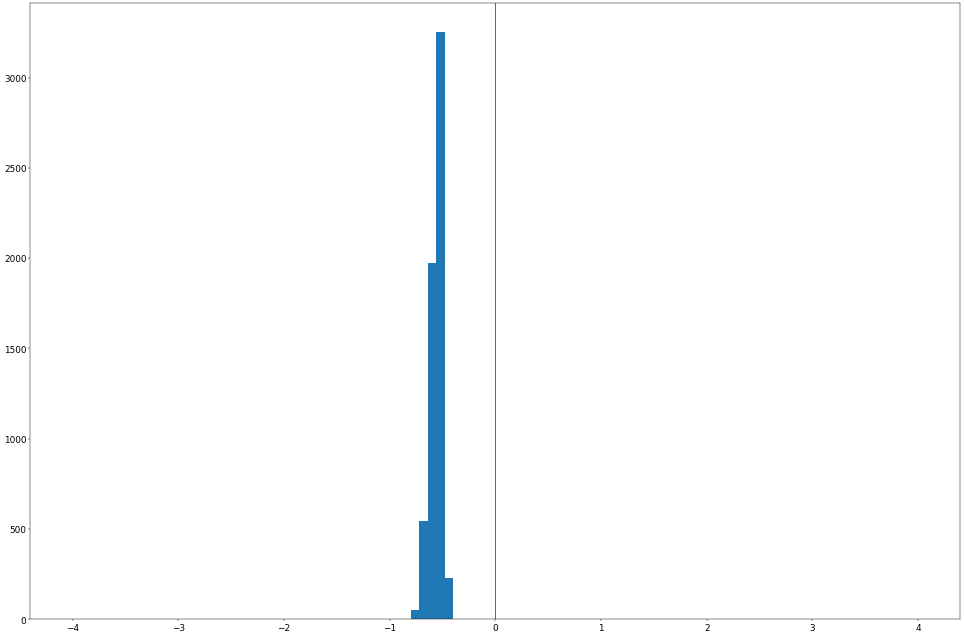

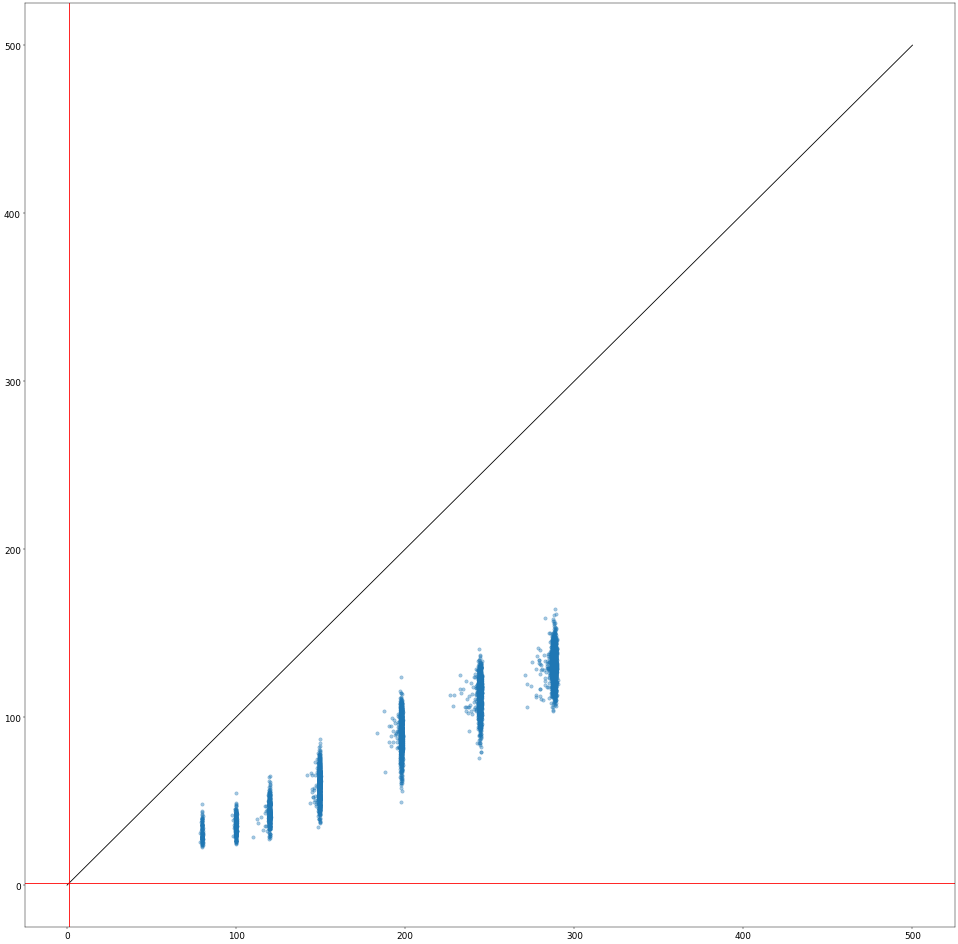

new best test loss: 16741.309106045082


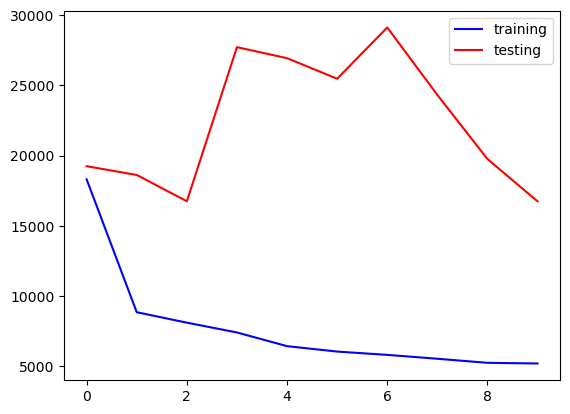

epoch: 10


100%|██████████| 121/121 [00:17<00:00,  6.99it/s]


batches for train: 121
train loss: 5043.5533961776855


100%|██████████| 61/61 [00:03<00:00, 15.60it/s]


batches for test: 61
test loss: 18551.49020235656
pred - true / true mean: -0.58972013
pred - true / true std: 0.04862739
mu,sig: -0.58972013 0.04862739


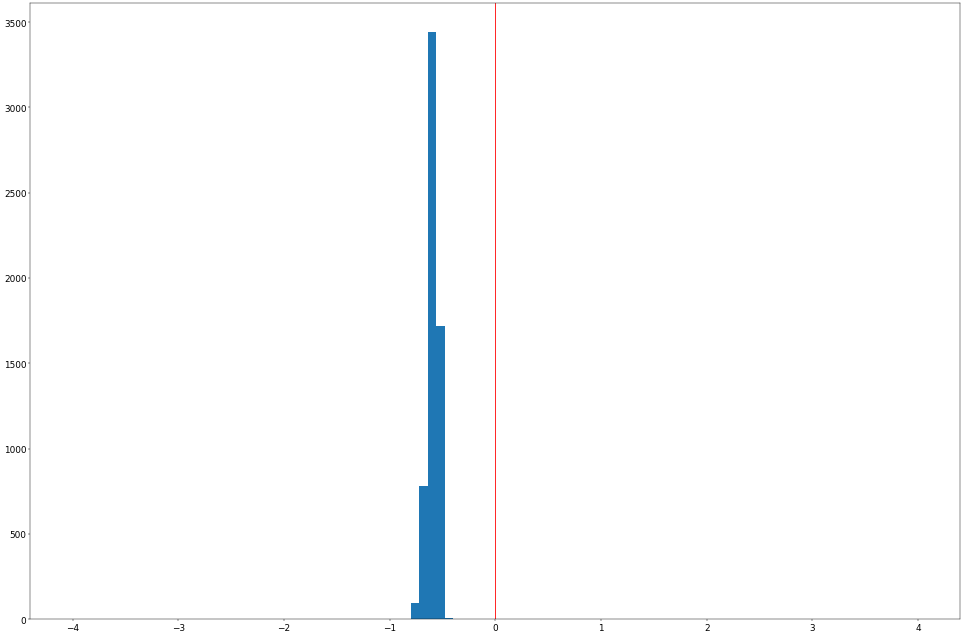

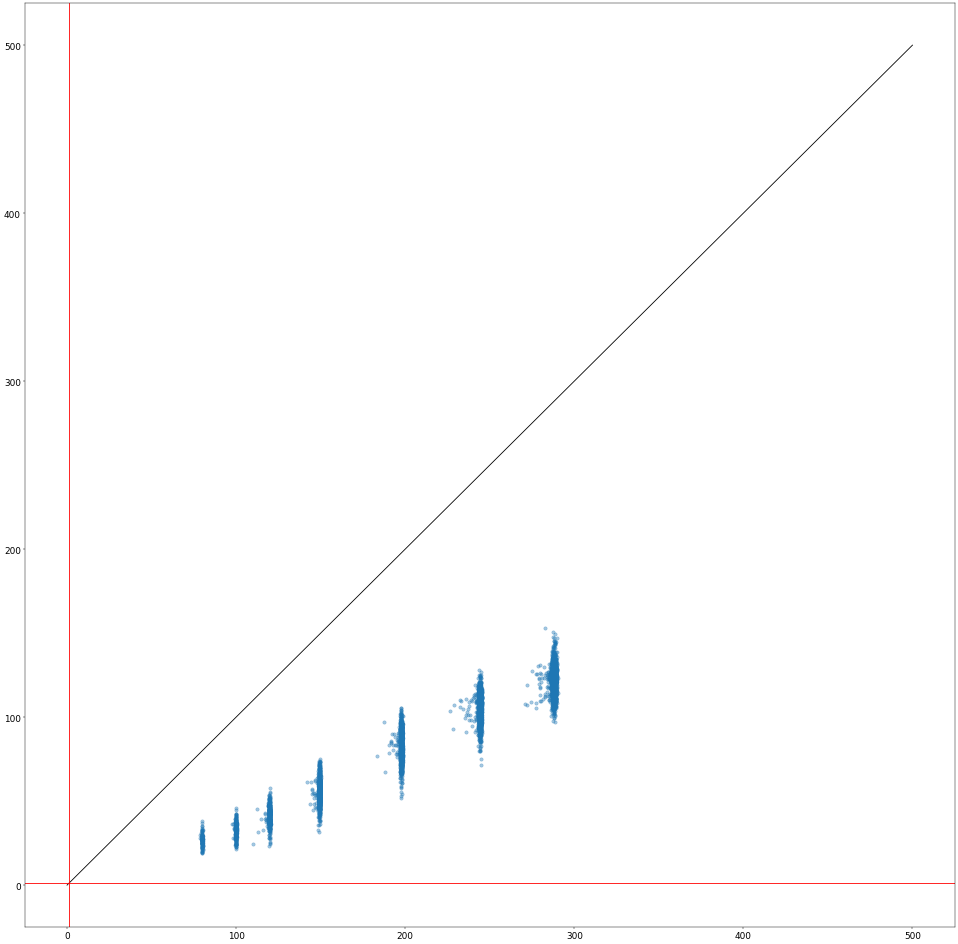

epoch: 11


100%|██████████| 121/121 [00:17<00:00,  7.02it/s]


batches for train: 121
train loss: 4871.288915208548


100%|██████████| 61/61 [00:03<00:00, 16.14it/s]


batches for test: 61
test loss: 16006.341828893443
pred - true / true mean: -0.54651207
pred - true / true std: 0.045707576
mu,sig: -0.54651207 0.045707576


<Figure size 640x480 with 0 Axes>

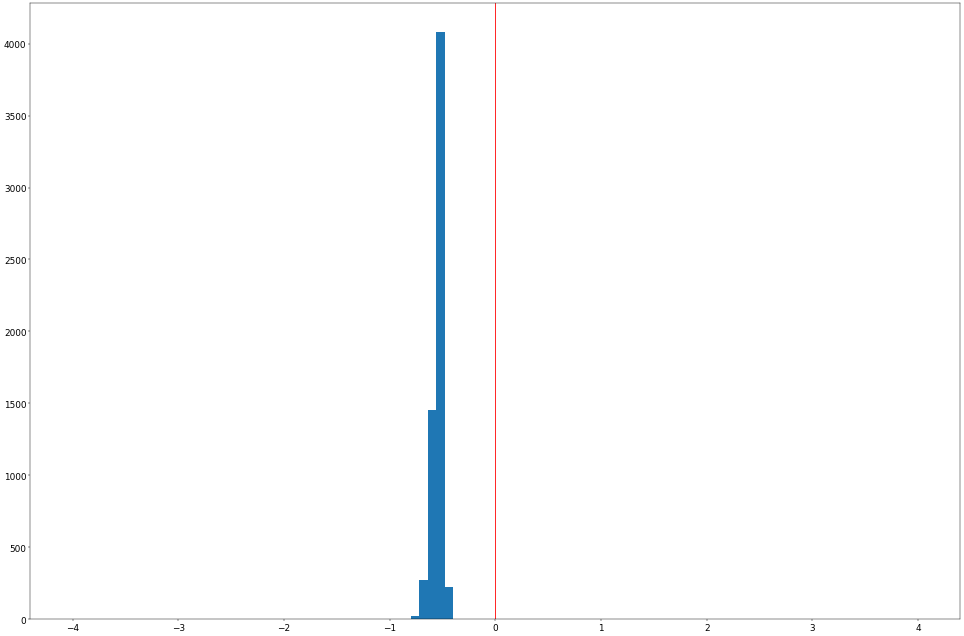

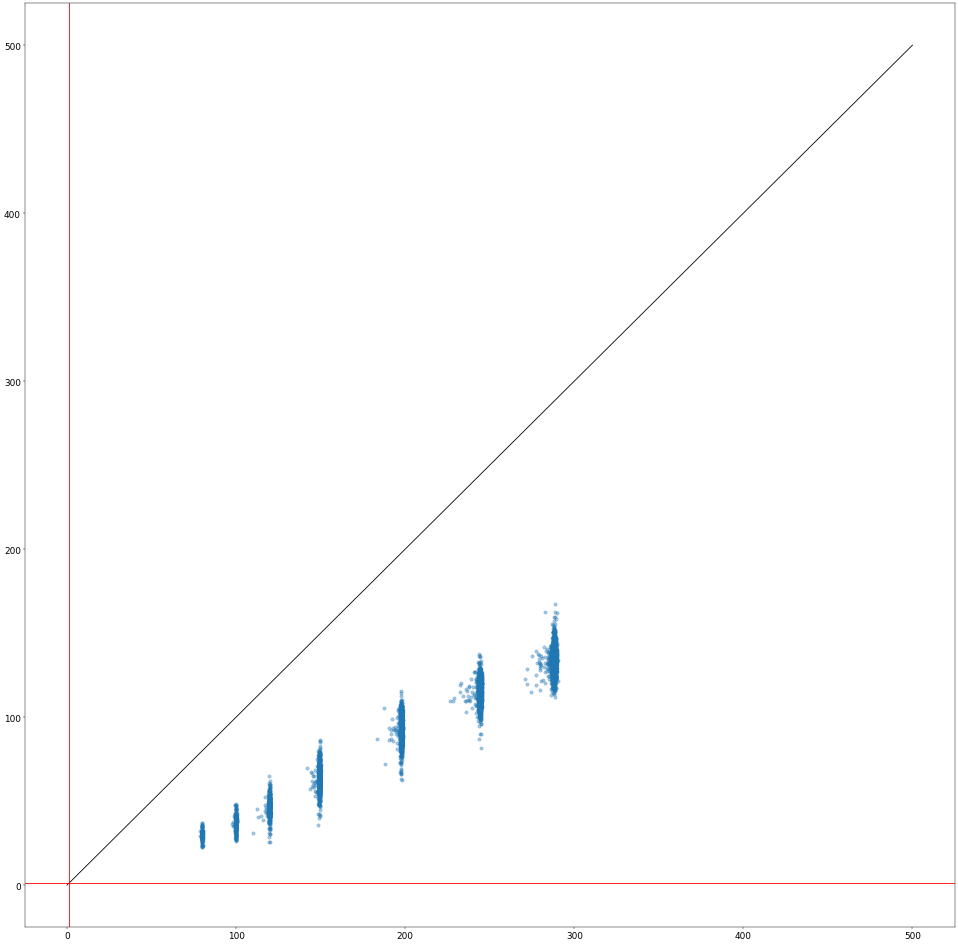

new best test loss: 16006.341828893443
epoch: 12


100%|██████████| 121/121 [00:17<00:00,  7.04it/s]


batches for train: 121
train loss: 4876.289038287707


100%|██████████| 61/61 [00:03<00:00, 15.94it/s]


batches for test: 61
test loss: 15958.221631659837
pred - true / true mean: -0.54299814
pred - true / true std: 0.043005817
mu,sig: -0.54299814 0.043005817


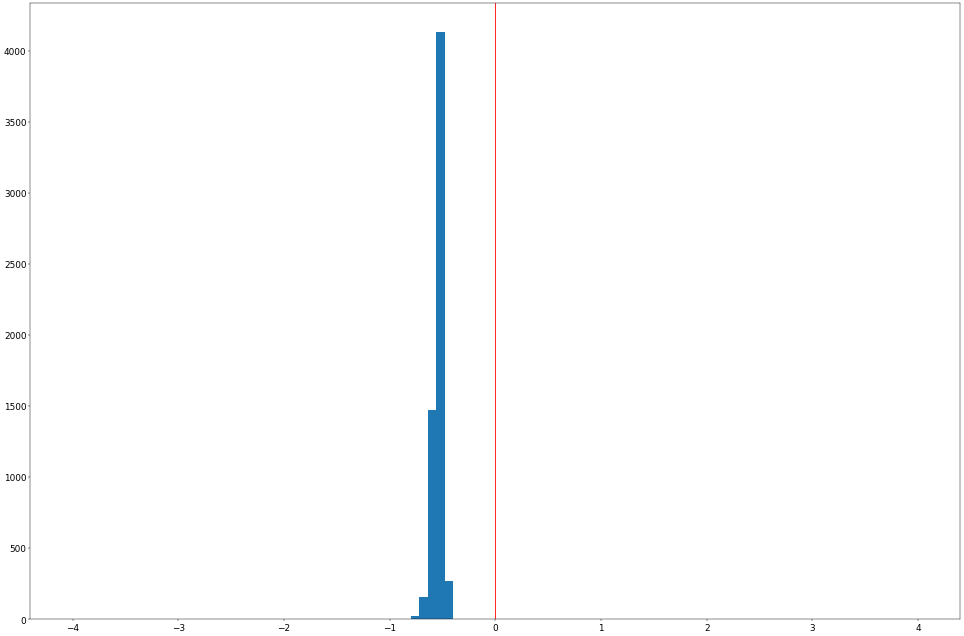

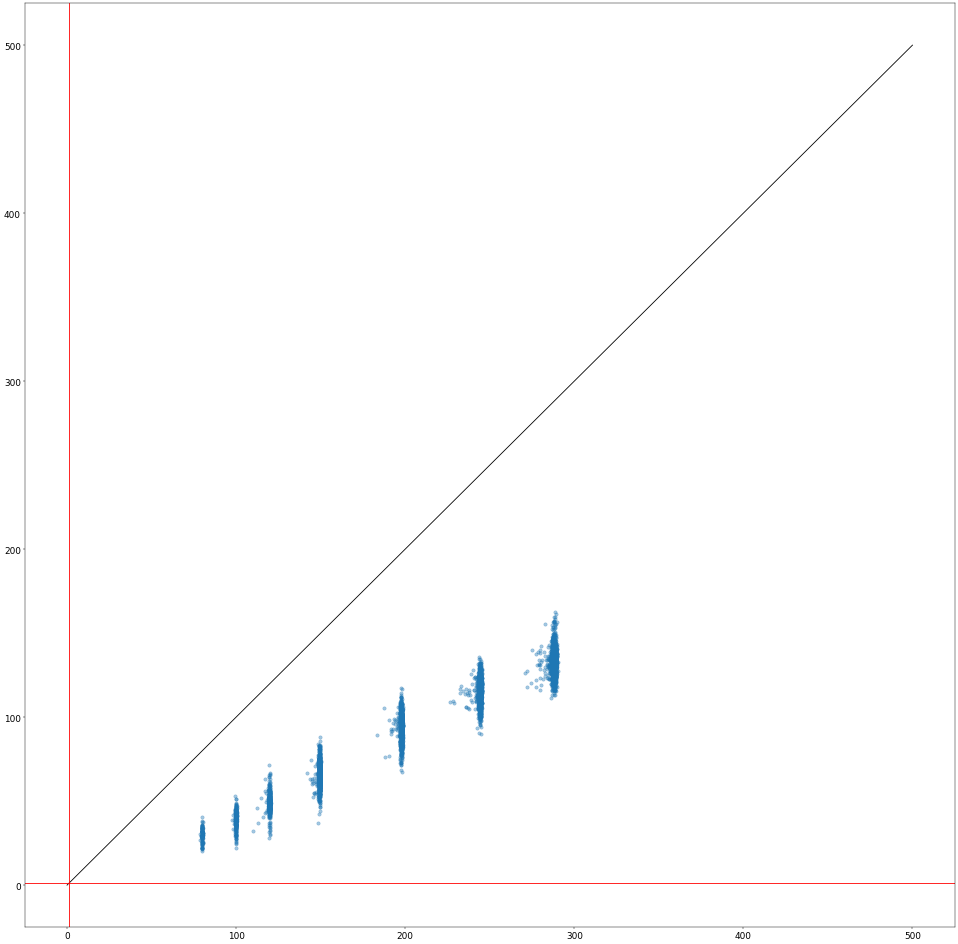

new best test loss: 15958.221631659837
epoch: 13


100%|██████████| 121/121 [00:17<00:00,  6.99it/s]


batches for train: 121
train loss: 4725.599875710227


100%|██████████| 61/61 [00:03<00:00, 16.08it/s]


batches for test: 61
test loss: 15451.719006147541
pred - true / true mean: -0.53676087
pred - true / true std: 0.04650288
mu,sig: -0.53676087 0.04650288


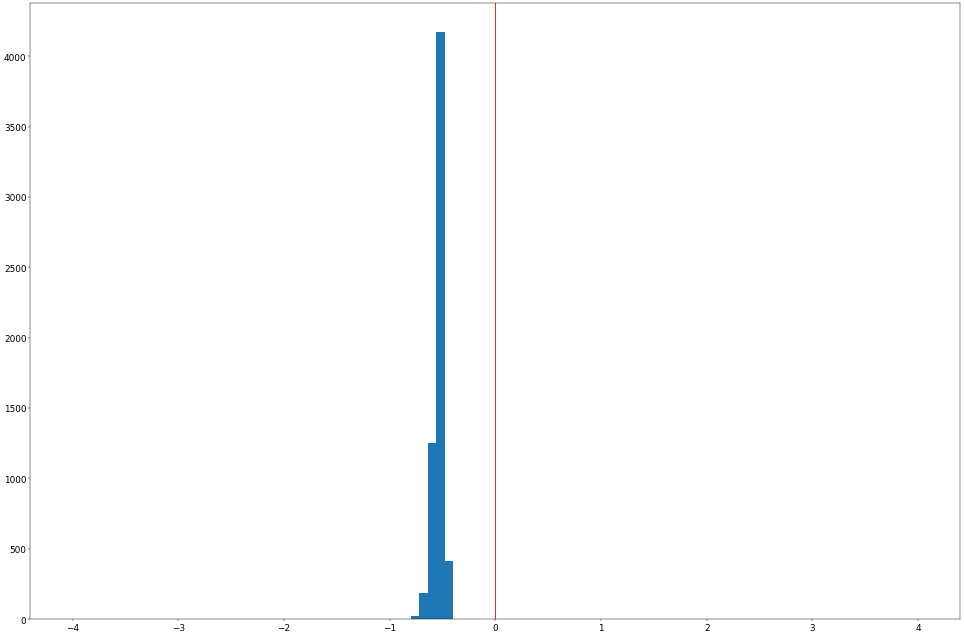

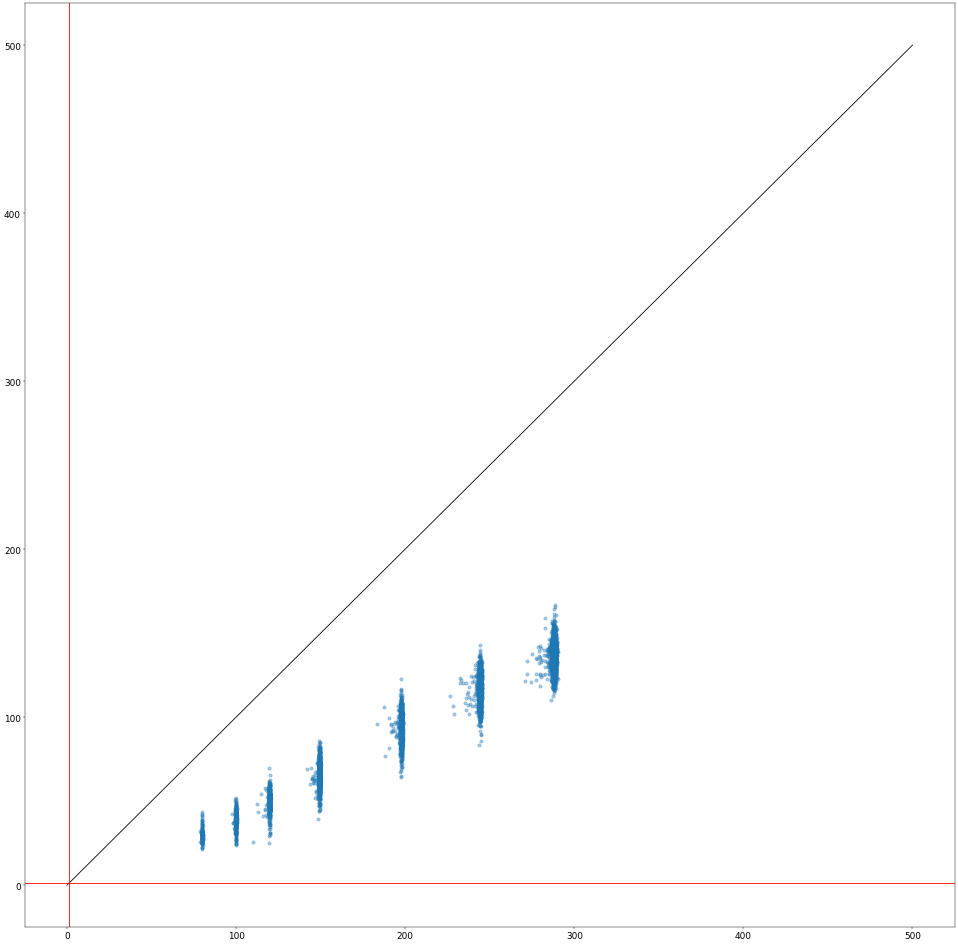

new best test loss: 15451.719006147541
epoch: 14


100%|██████████| 121/121 [00:17<00:00,  7.02it/s]


batches for train: 121
train loss: 4647.189463213455


100%|██████████| 61/61 [00:03<00:00, 15.52it/s]


batches for test: 61
test loss: 15462.890112704918
pred - true / true mean: -0.5397753
pred - true / true std: 0.049820095
mu,sig: -0.5397753 0.049820095


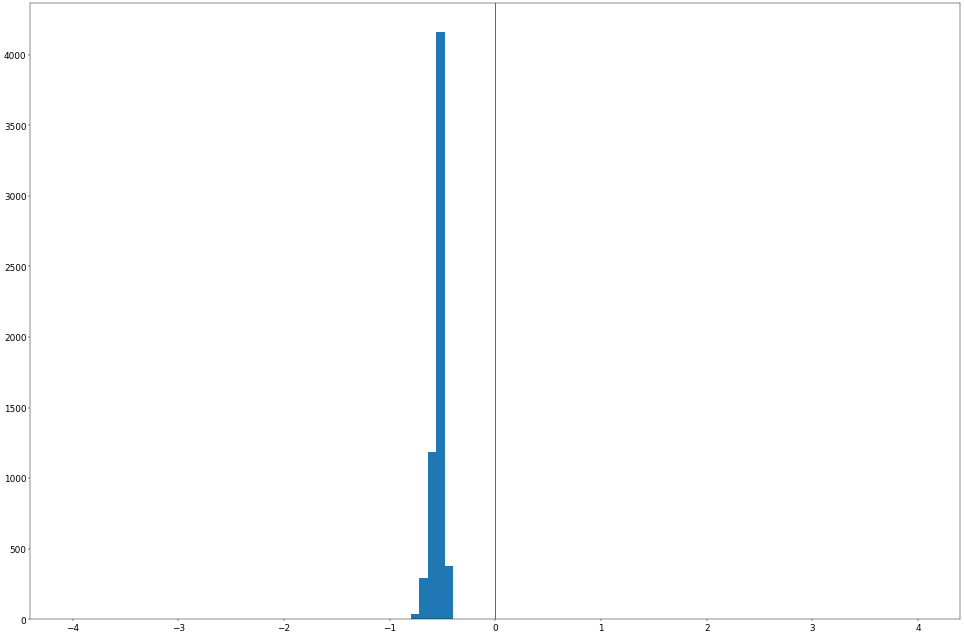

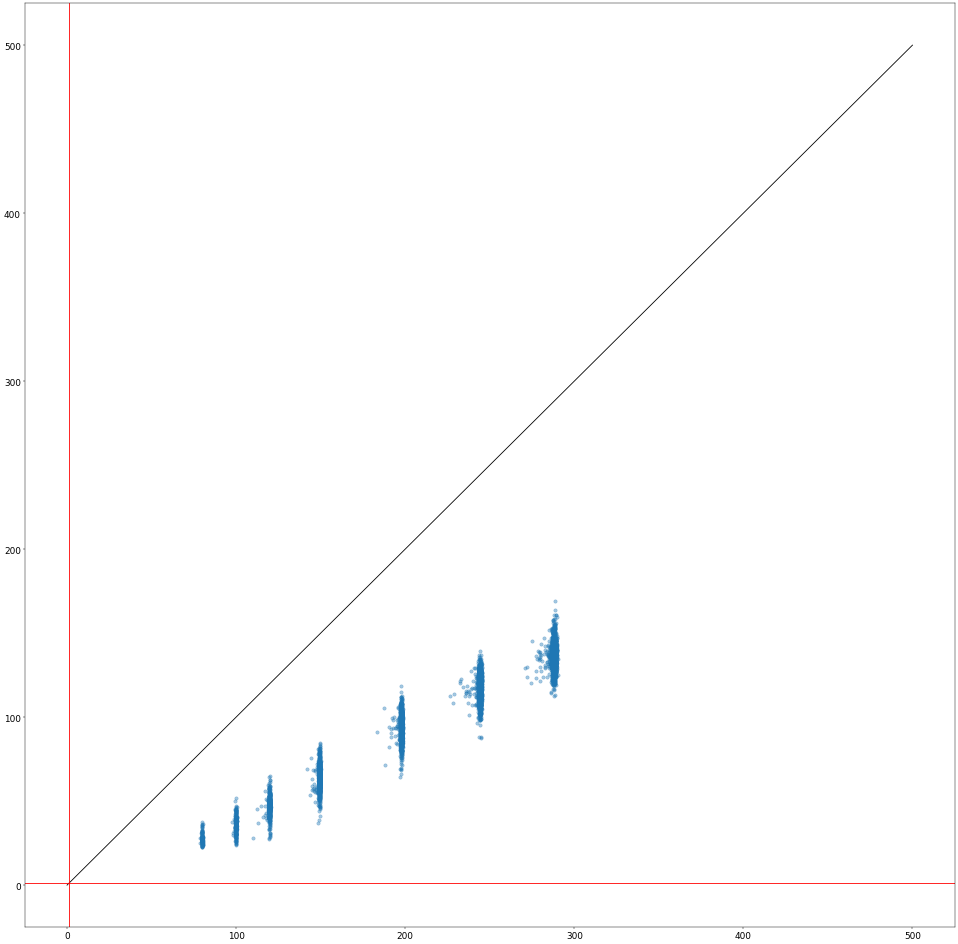

epoch: 15


100%|██████████| 121/121 [00:17<00:00,  7.07it/s]


batches for train: 121
train loss: 4615.407446490832


100%|██████████| 61/61 [00:03<00:00, 16.00it/s]


batches for test: 61
test loss: 15471.823914574796
pred - true / true mean: -0.53556293
pred - true / true std: 0.040164415
mu,sig: -0.53556293 0.040164415


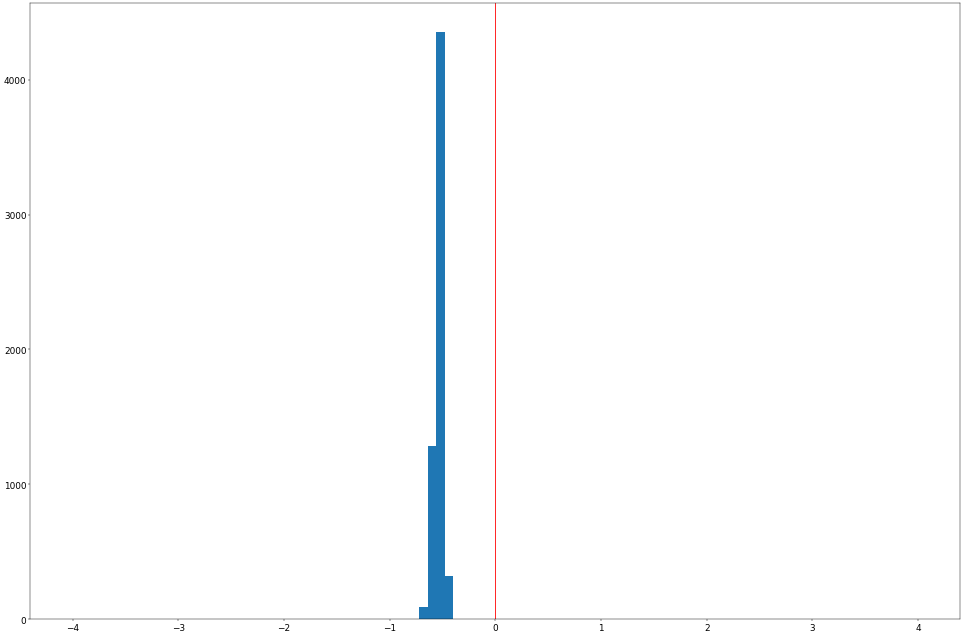

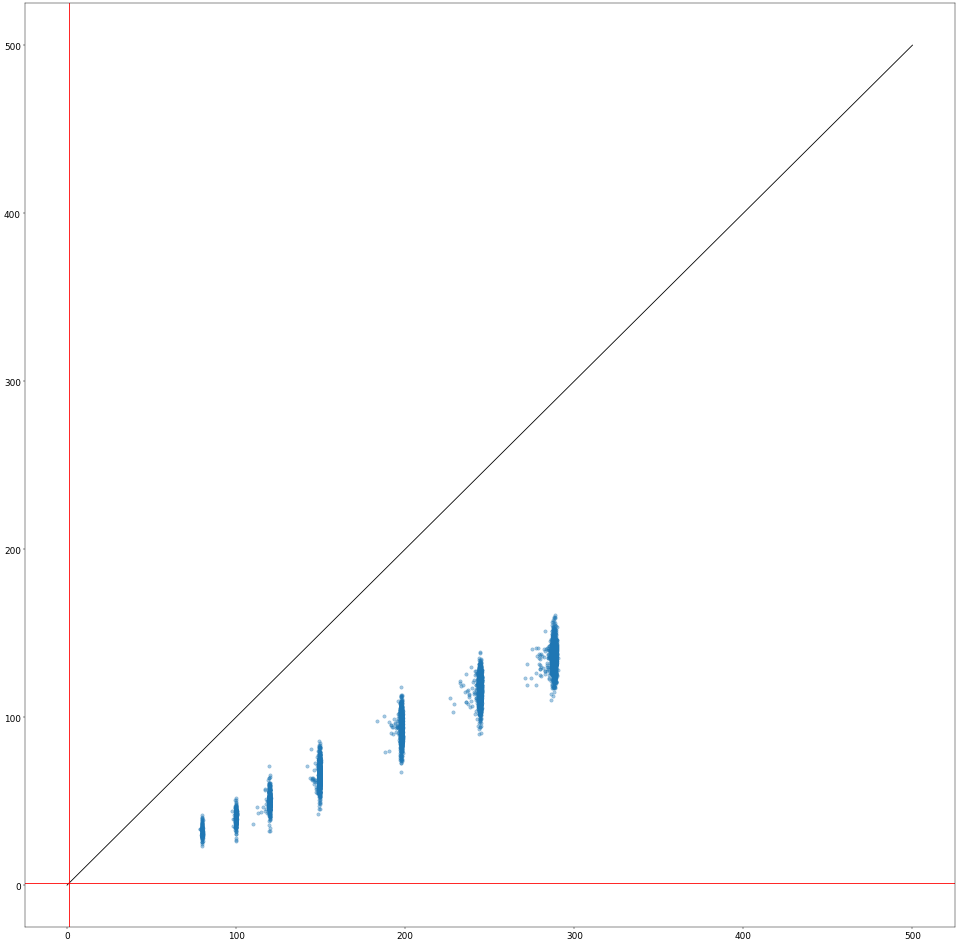

epoch: 16


100%|██████████| 121/121 [00:17<00:00,  7.06it/s]


batches for train: 121
train loss: 4548.856556285511


100%|██████████| 61/61 [00:03<00:00, 16.01it/s]


batches for test: 61
test loss: 15423.223472720287
pred - true / true mean: -0.53354955
pred - true / true std: 0.03834977
mu,sig: -0.53354955 0.03834977


<Figure size 640x480 with 0 Axes>

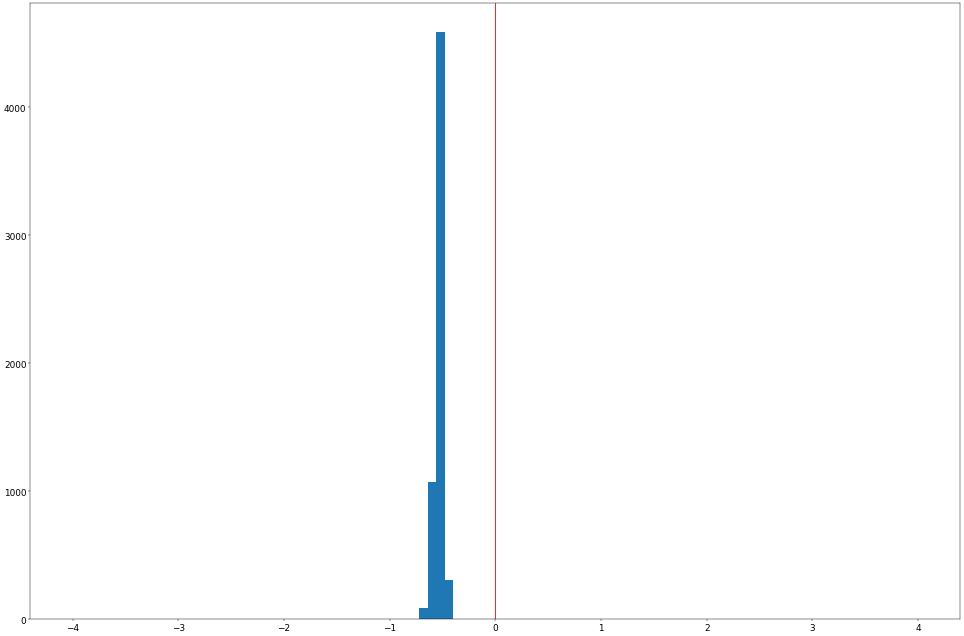

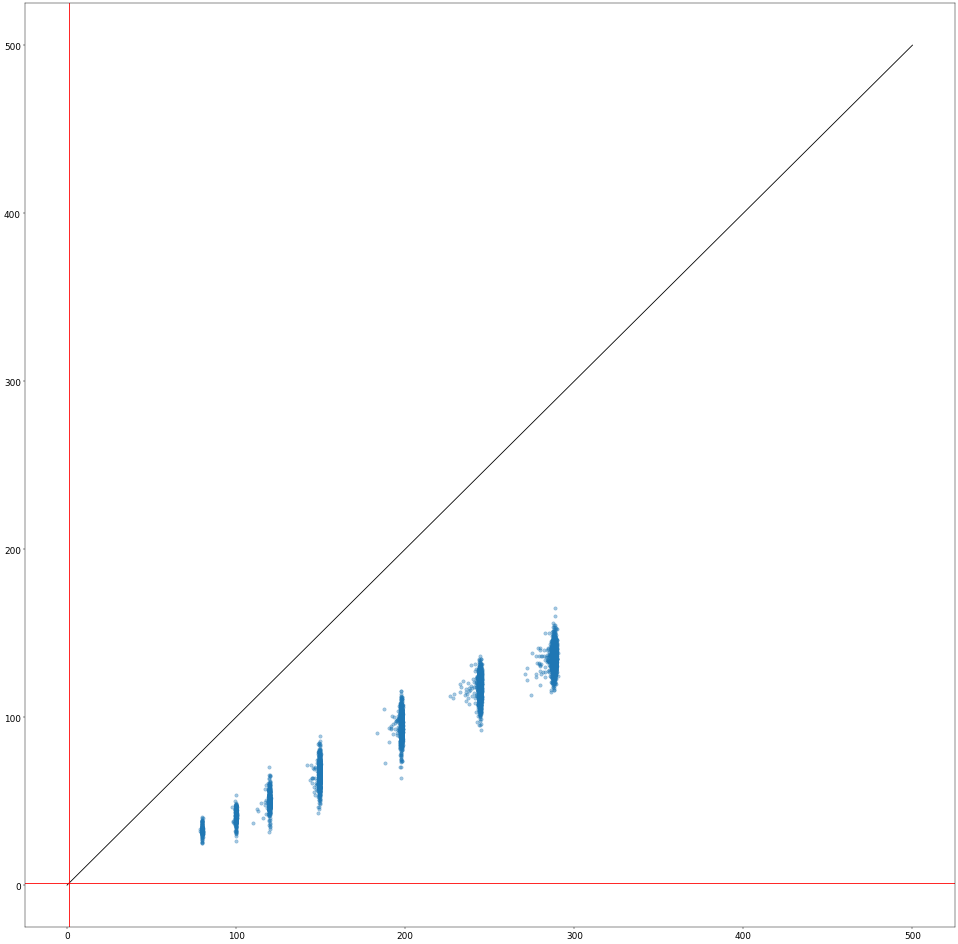

new best test loss: 15423.223472720287
epoch: 17


100%|██████████| 121/121 [00:17<00:00,  7.00it/s]


batches for train: 121
train loss: 4566.289449896694


100%|██████████| 61/61 [00:03<00:00, 16.25it/s]


batches for test: 61
test loss: 15326.374967981557
pred - true / true mean: -0.5318262
pred - true / true std: 0.03723979
mu,sig: -0.5318262 0.03723979


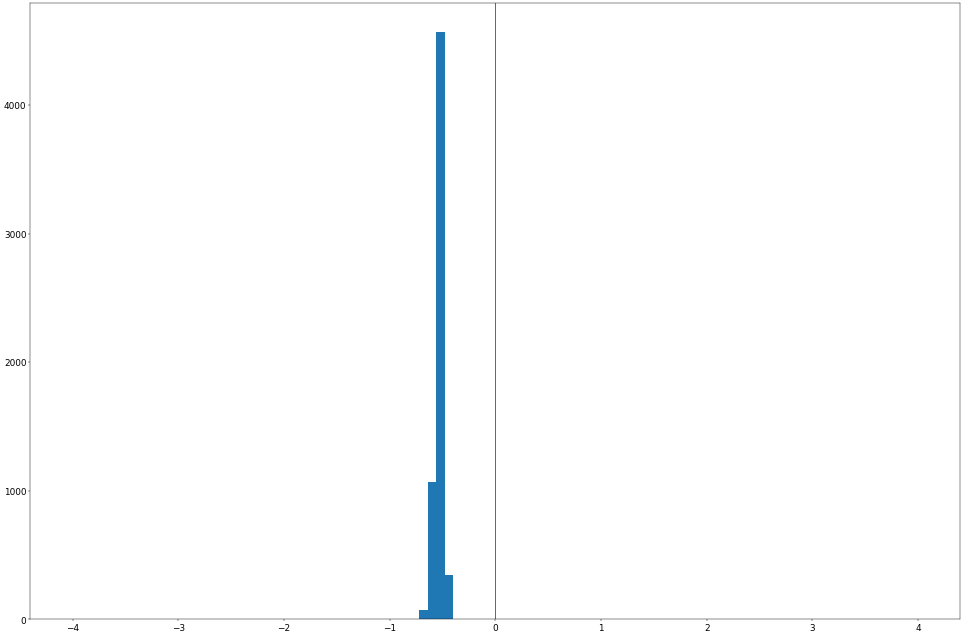

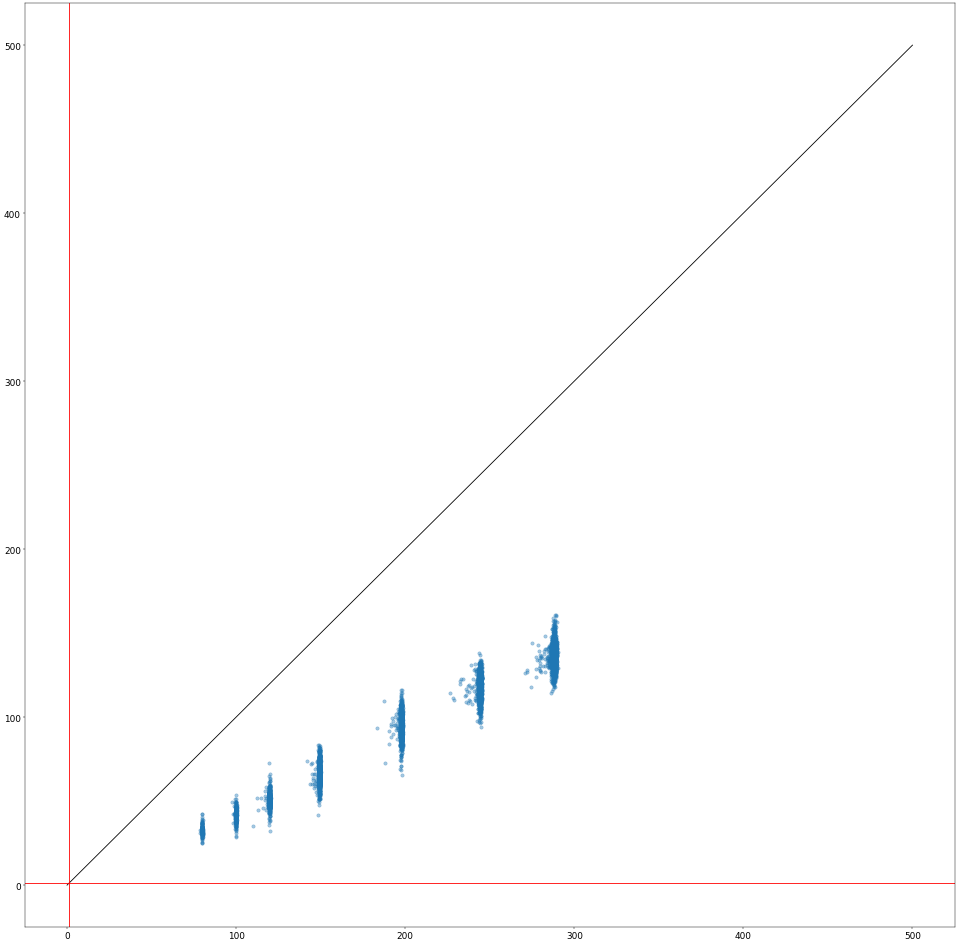

new best test loss: 15326.374967981557
epoch: 18


100%|██████████| 121/121 [00:17<00:00,  7.07it/s]


batches for train: 121
train loss: 4615.983862506457


100%|██████████| 61/61 [00:03<00:00, 16.19it/s]


batches for test: 61
test loss: 15066.72669057377
pred - true / true mean: -0.528991
pred - true / true std: 0.03845483
mu,sig: -0.528991 0.03845483


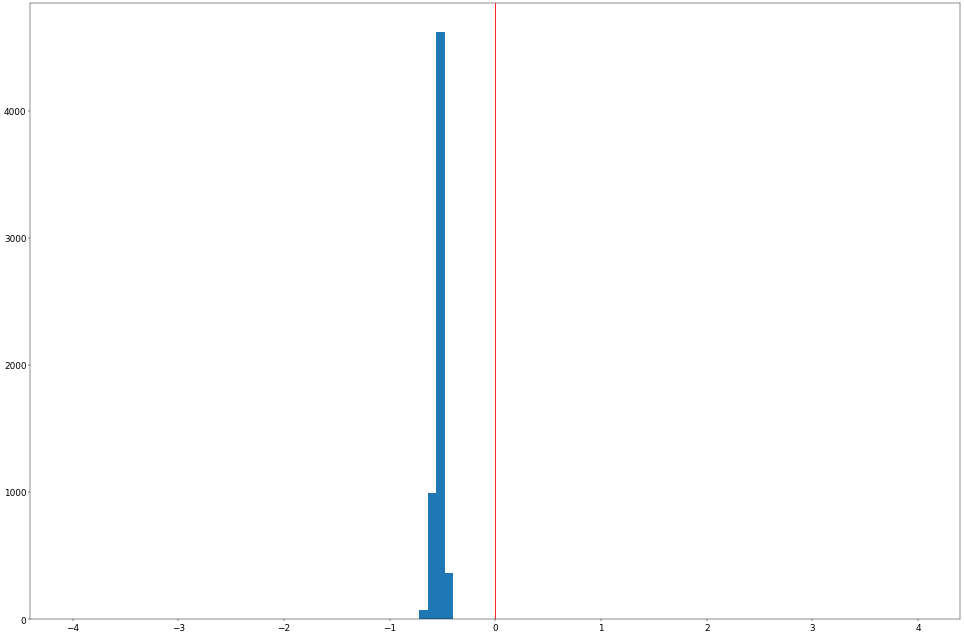

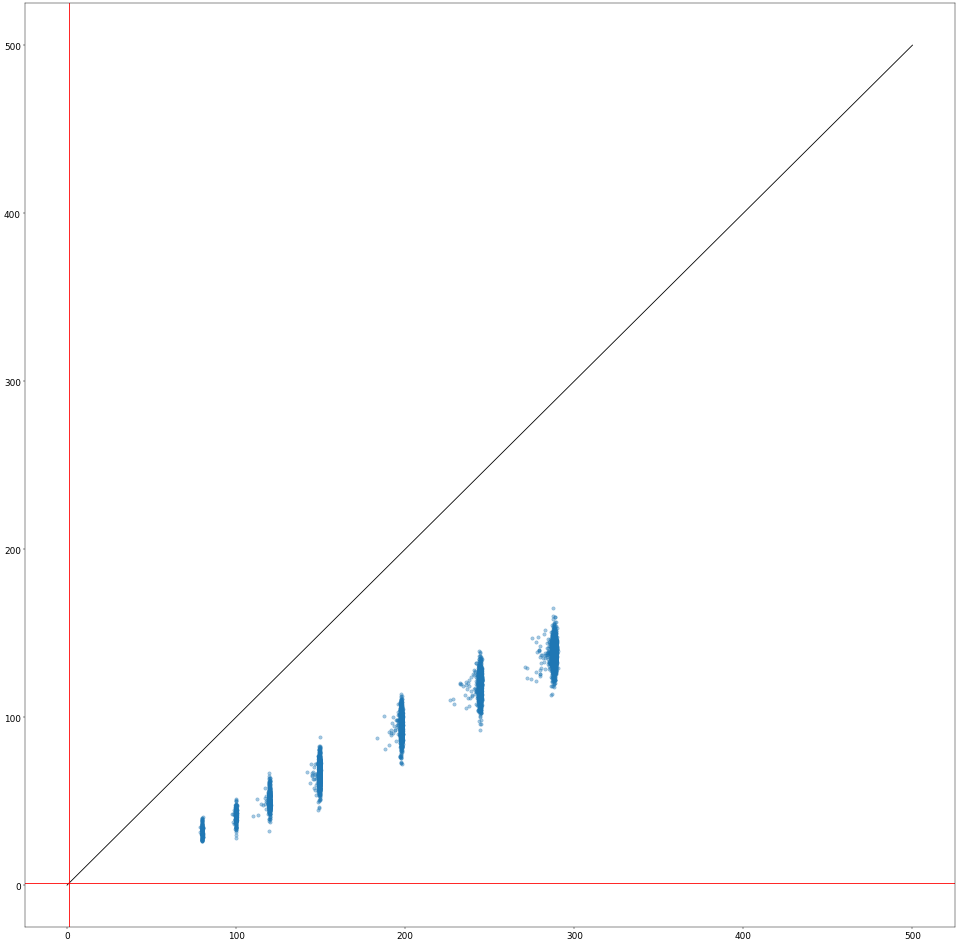

new best test loss: 15066.72669057377
epoch: 19


100%|██████████| 121/121 [00:17<00:00,  7.10it/s]


batches for train: 121
train loss: 4591.809626807852


100%|██████████| 61/61 [00:03<00:00, 16.30it/s]


batches for test: 61
test loss: 13936.359519082991
pred - true / true mean: -0.5055121
pred - true / true std: 0.034003418
mu,sig: -0.5055121 0.034003418


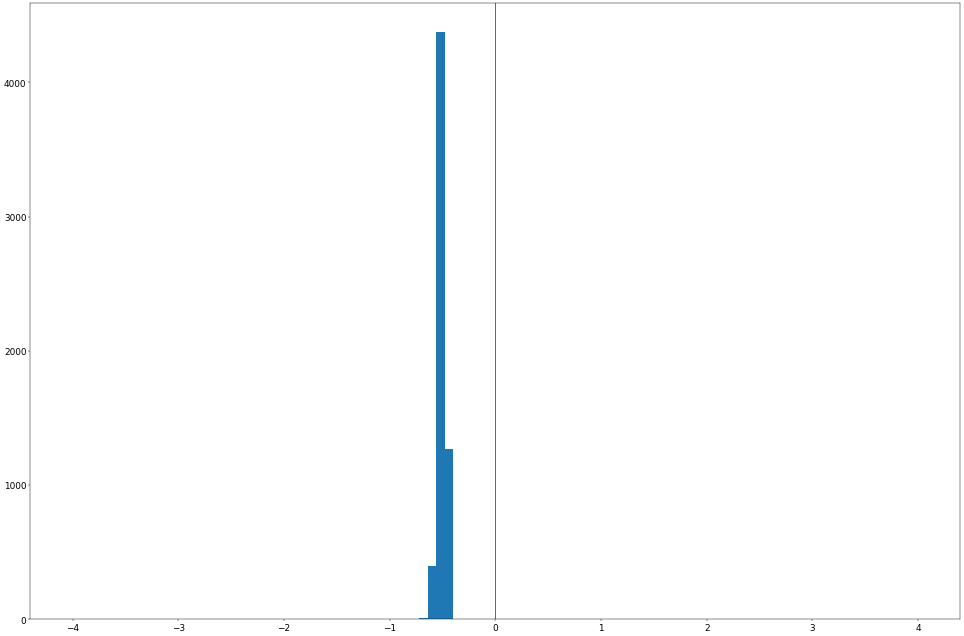

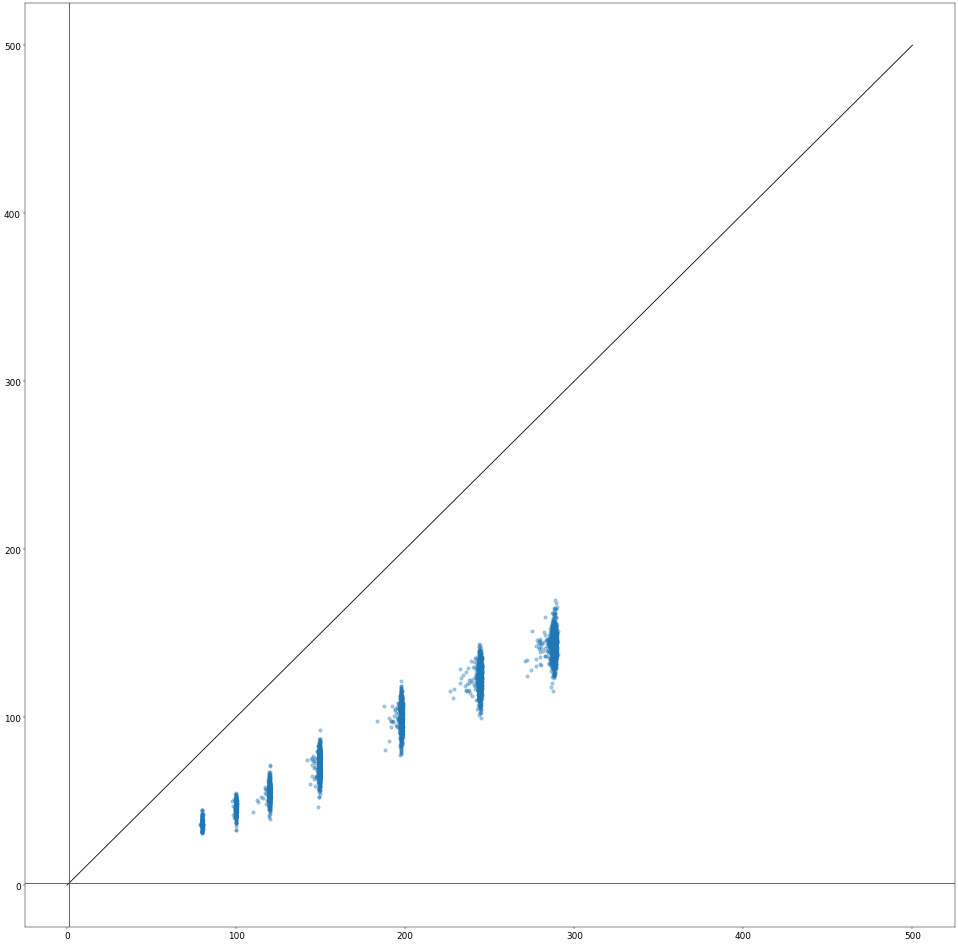

new best test loss: 13936.359519082991


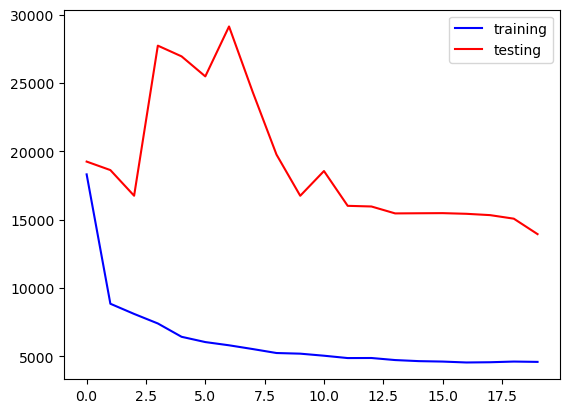

epoch: 20


100%|██████████| 121/121 [00:17<00:00,  7.10it/s]


batches for train: 121
train loss: 4537.4196736989925


100%|██████████| 61/61 [00:03<00:00, 16.21it/s]


batches for test: 61
test loss: 13153.1767578125
pred - true / true mean: -0.49096712
pred - true / true std: 0.035632398
mu,sig: -0.49096712 0.035632398


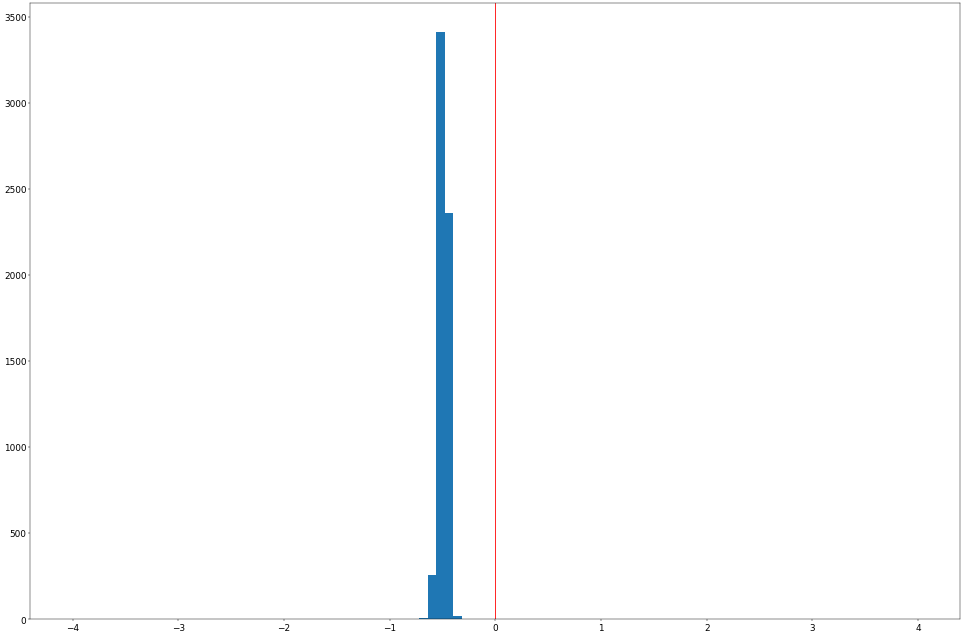

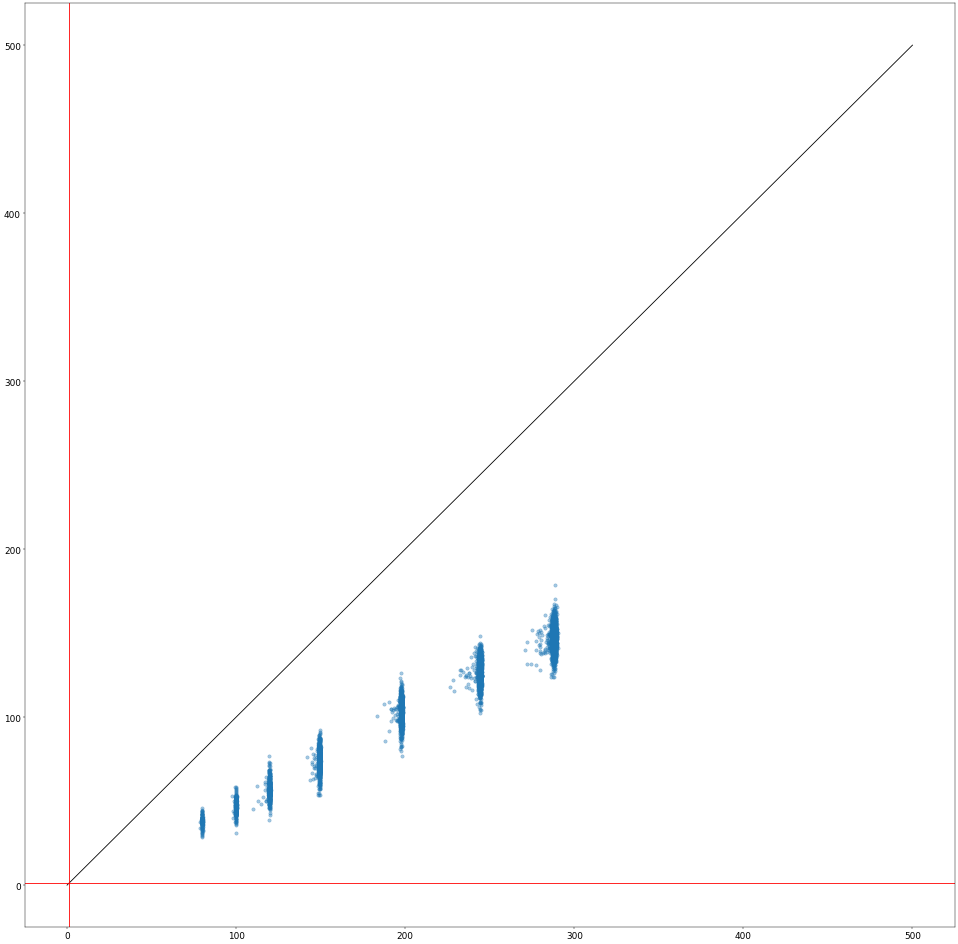

new best test loss: 13153.1767578125
epoch: 21


100%|██████████| 121/121 [00:16<00:00,  7.15it/s]


batches for train: 121
train loss: 4481.528709726886


100%|██████████| 61/61 [00:03<00:00, 16.60it/s]


batches for test: 61
test loss: 13630.194720158812
pred - true / true mean: -0.49800456
pred - true / true std: 0.032094475
mu,sig: -0.49800456 0.032094475


<Figure size 640x480 with 0 Axes>

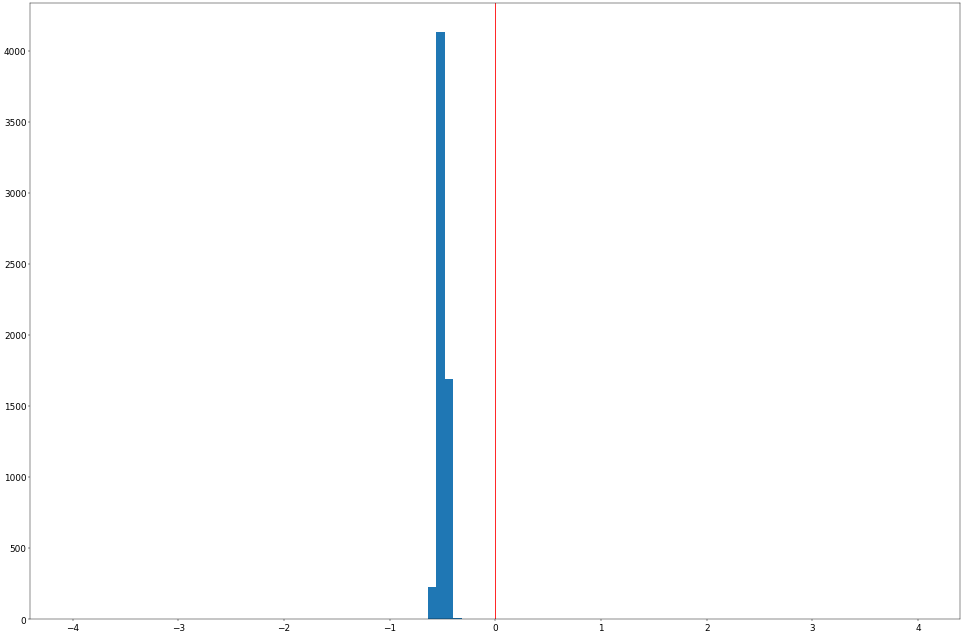

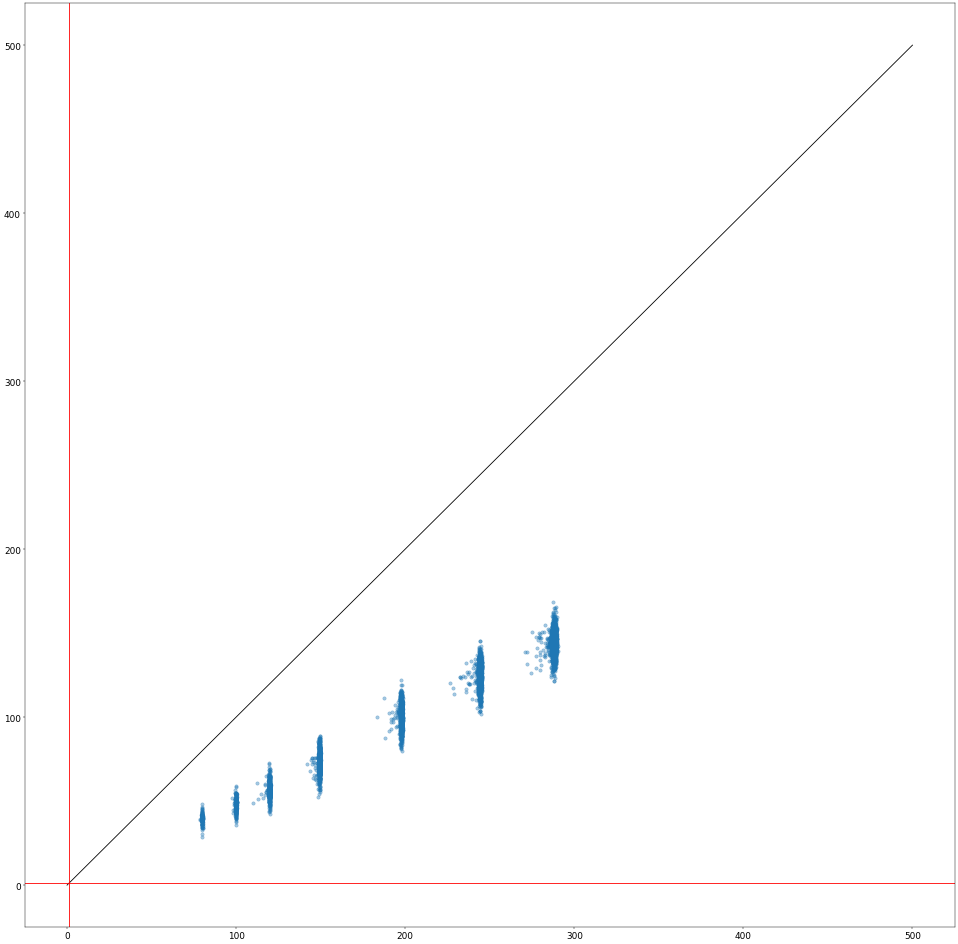

epoch: 22


100%|██████████| 121/121 [00:16<00:00,  7.19it/s]


batches for train: 121
train loss: 4415.728959517045


100%|██████████| 61/61 [00:03<00:00, 16.58it/s]


batches for test: 61
test loss: 13402.854188012296
pred - true / true mean: -0.4931136
pred - true / true std: 0.03005013
mu,sig: -0.4931136 0.03005013


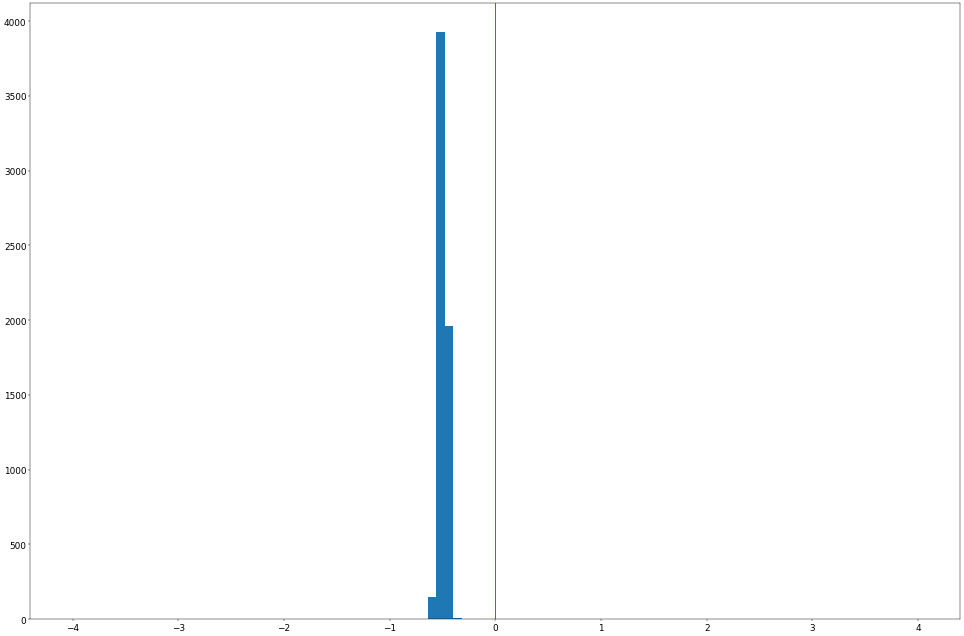

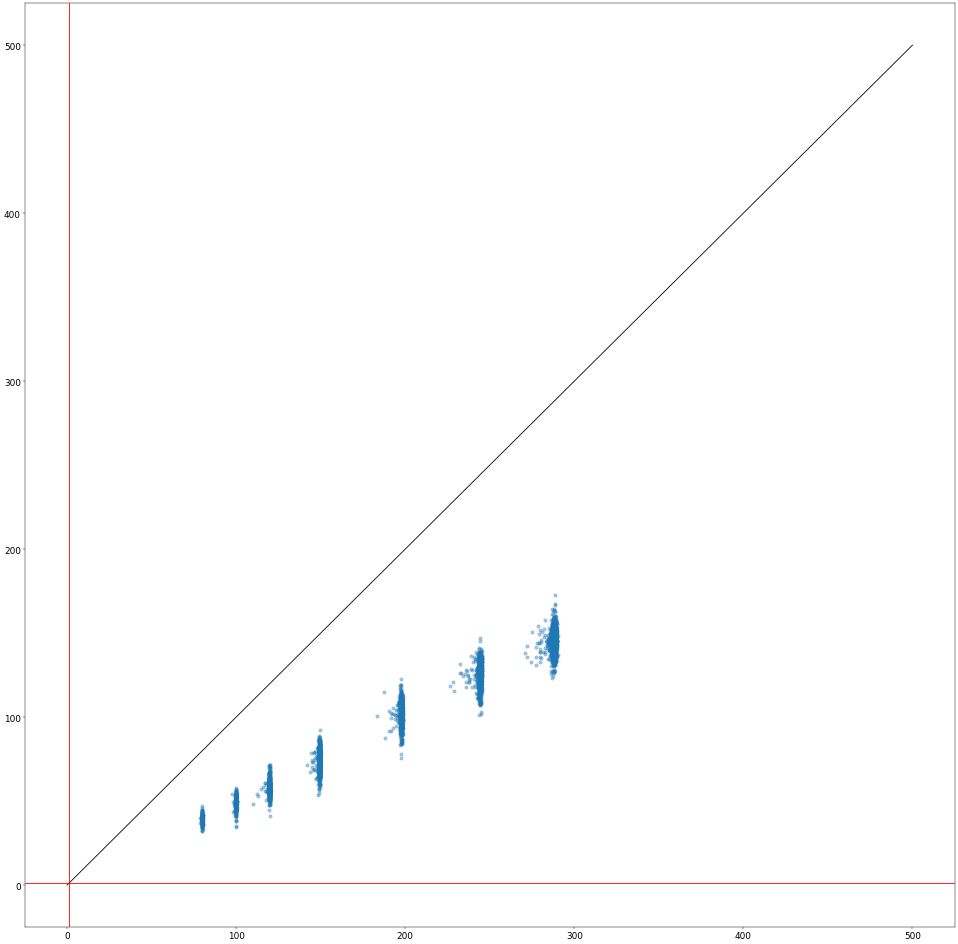

epoch: 23


100%|██████████| 121/121 [00:16<00:00,  7.21it/s]


batches for train: 121
train loss: 4399.246626420455


100%|██████████| 61/61 [00:03<00:00, 16.50it/s]


batches for test: 61
test loss: 12022.78747758709
pred - true / true mean: -0.46867314
pred - true / true std: 0.032278955
mu,sig: -0.46867314 0.032278955


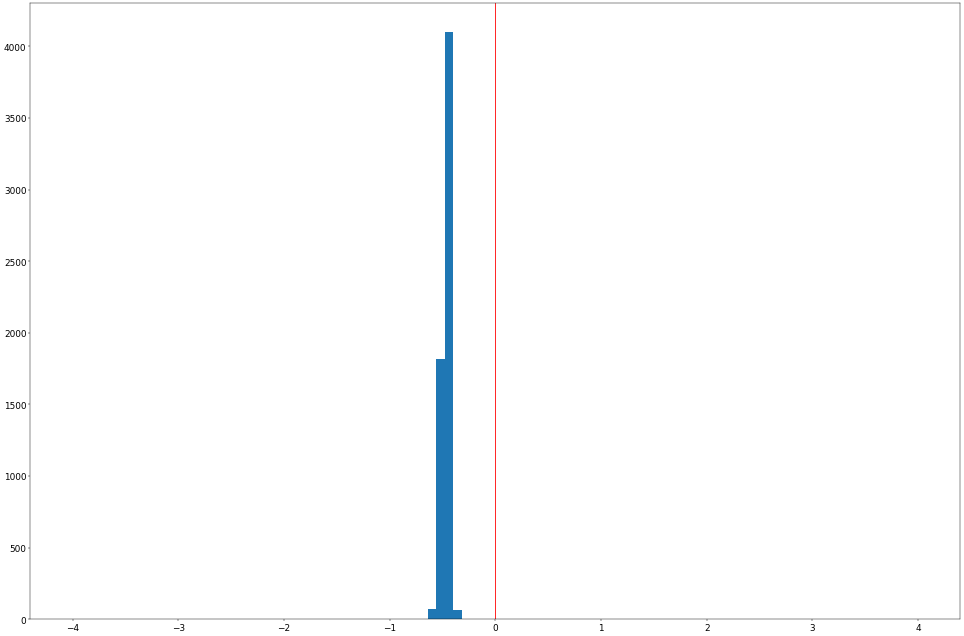

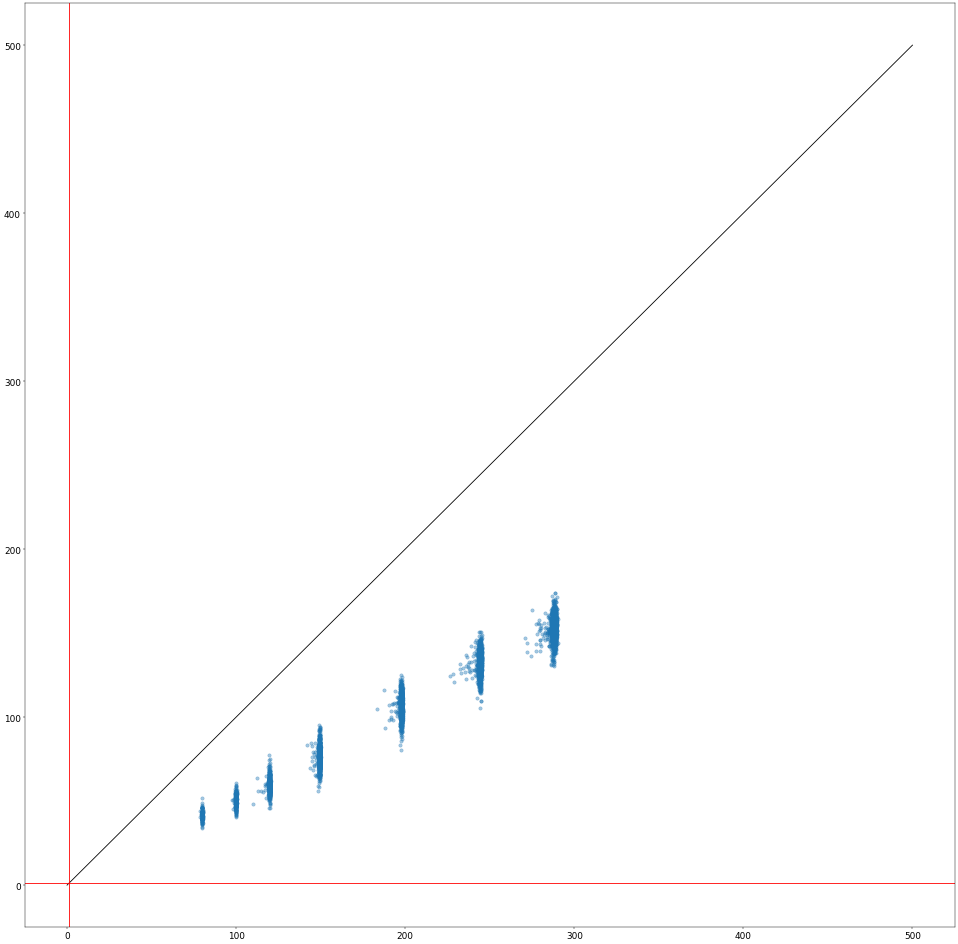

new best test loss: 12022.78747758709
epoch: 24


100%|██████████| 121/121 [00:16<00:00,  7.22it/s]


batches for train: 121
train loss: 4387.463675506844


100%|██████████| 61/61 [00:03<00:00, 16.56it/s]


batches for test: 61
test loss: 12761.987240650615
pred - true / true mean: -0.48072952
pred - true / true std: 0.029802907
mu,sig: -0.48072952 0.029802907


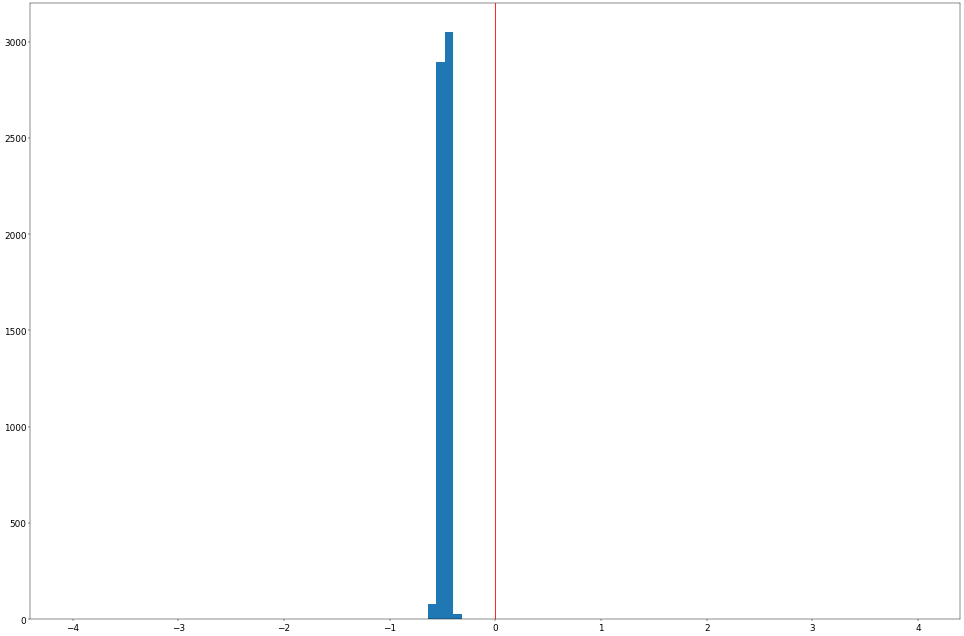

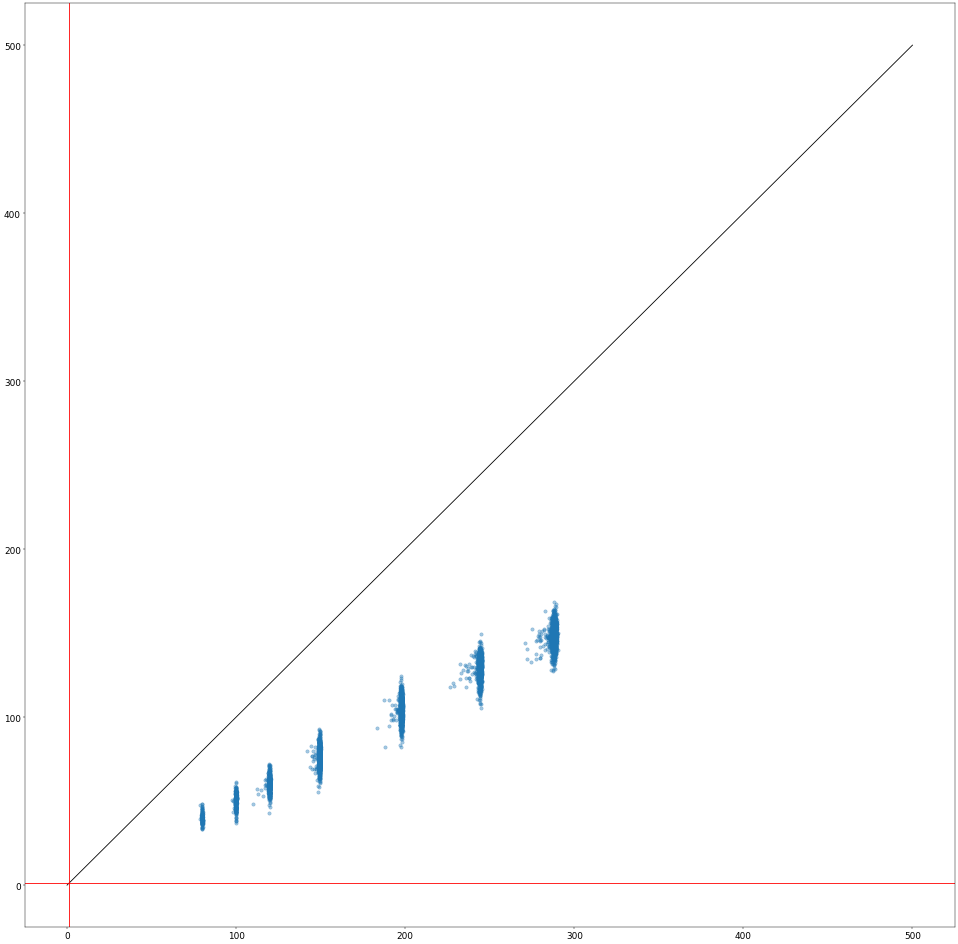

epoch: 25


100%|██████████| 121/121 [00:16<00:00,  7.20it/s]


batches for train: 121
train loss: 4351.439233196668


100%|██████████| 61/61 [00:03<00:00, 16.12it/s]


batches for test: 61
test loss: 11962.555952228484
pred - true / true mean: -0.46391675
pred - true / true std: 0.029030249
mu,sig: -0.46391675 0.029030249


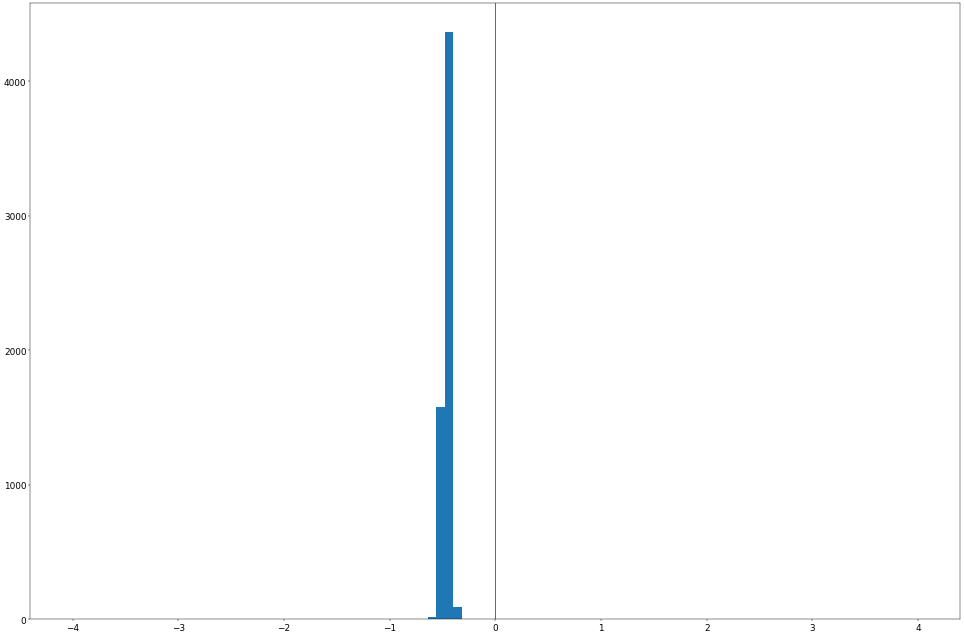

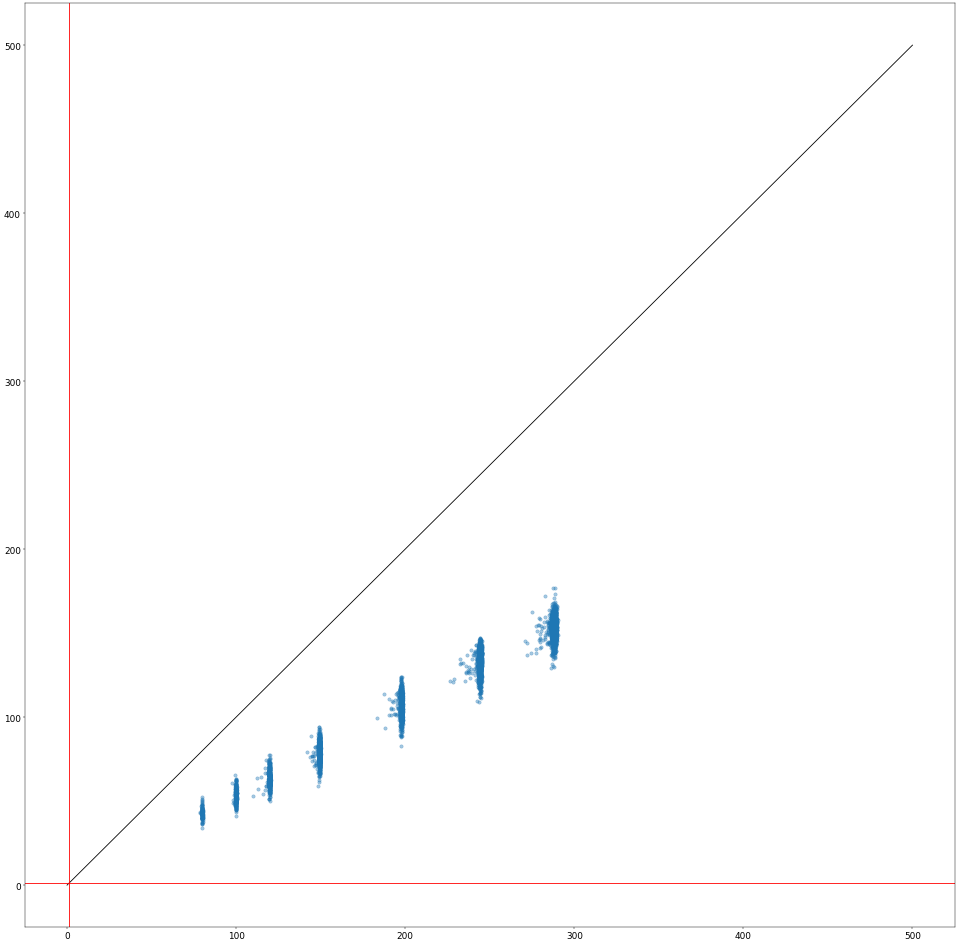

new best test loss: 11962.555952228484
epoch: 26


100%|██████████| 121/121 [00:16<00:00,  7.22it/s]


batches for train: 121
train loss: 4248.0482692245605


100%|██████████| 61/61 [00:03<00:00, 16.54it/s]


batches for test: 61
test loss: 11949.57029649078
pred - true / true mean: -0.46246782
pred - true / true std: 0.029009137
mu,sig: -0.46246782 0.029009137


<Figure size 640x480 with 0 Axes>

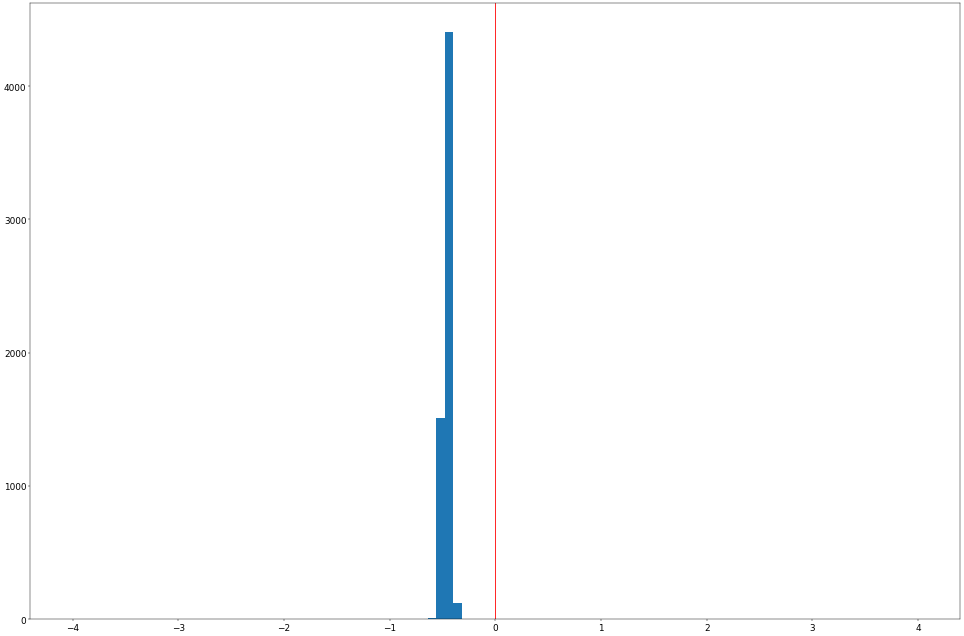

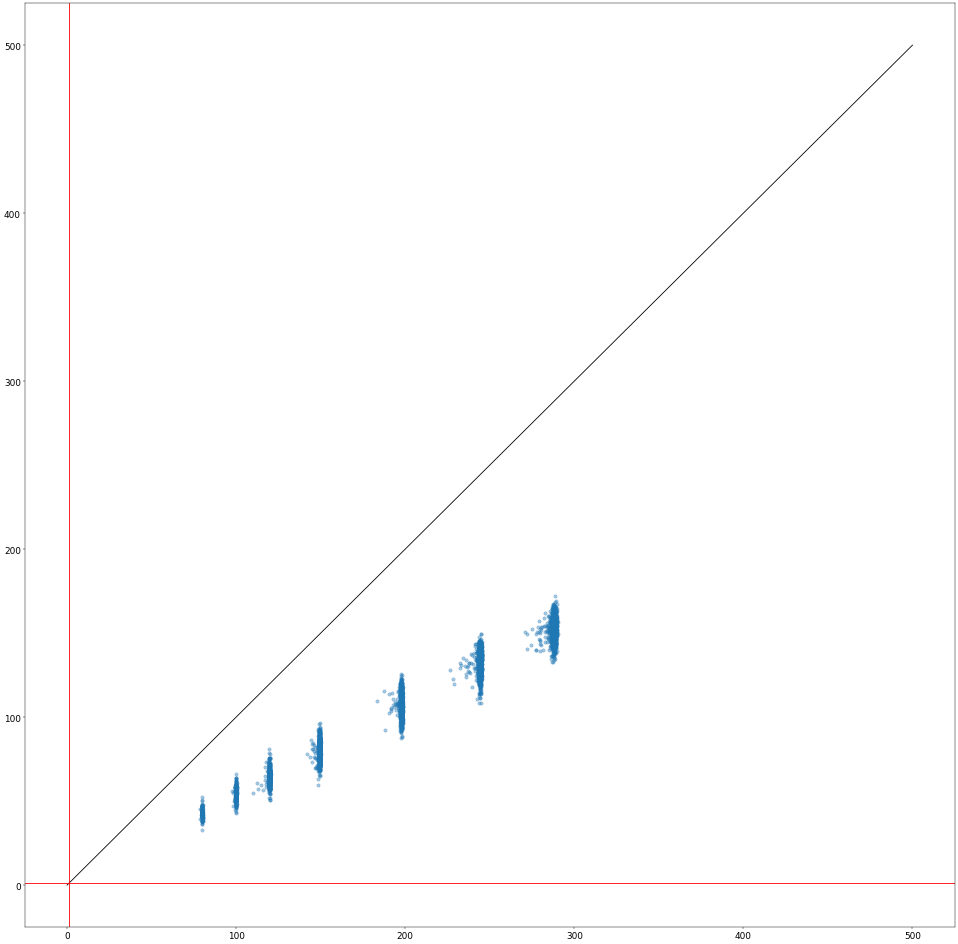

new best test loss: 11949.57029649078
epoch: 27


100%|██████████| 121/121 [00:16<00:00,  7.24it/s]


batches for train: 121
train loss: 4217.310938307077


100%|██████████| 61/61 [00:03<00:00, 16.61it/s]


batches for test: 61
test loss: 13039.818391393443
pred - true / true mean: -0.48445725
pred - true / true std: 0.028036049
mu,sig: -0.48445725 0.028036049


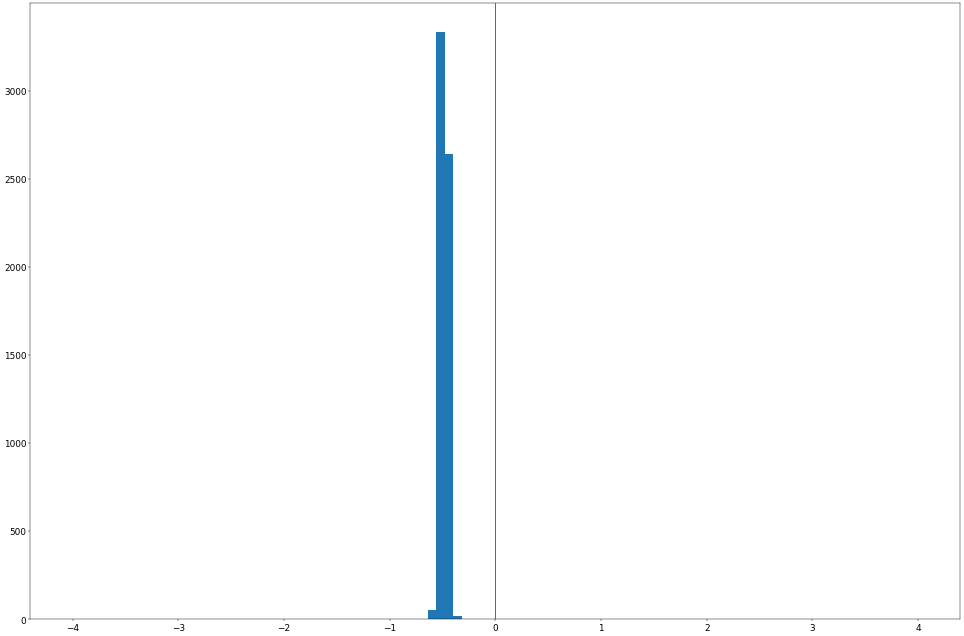

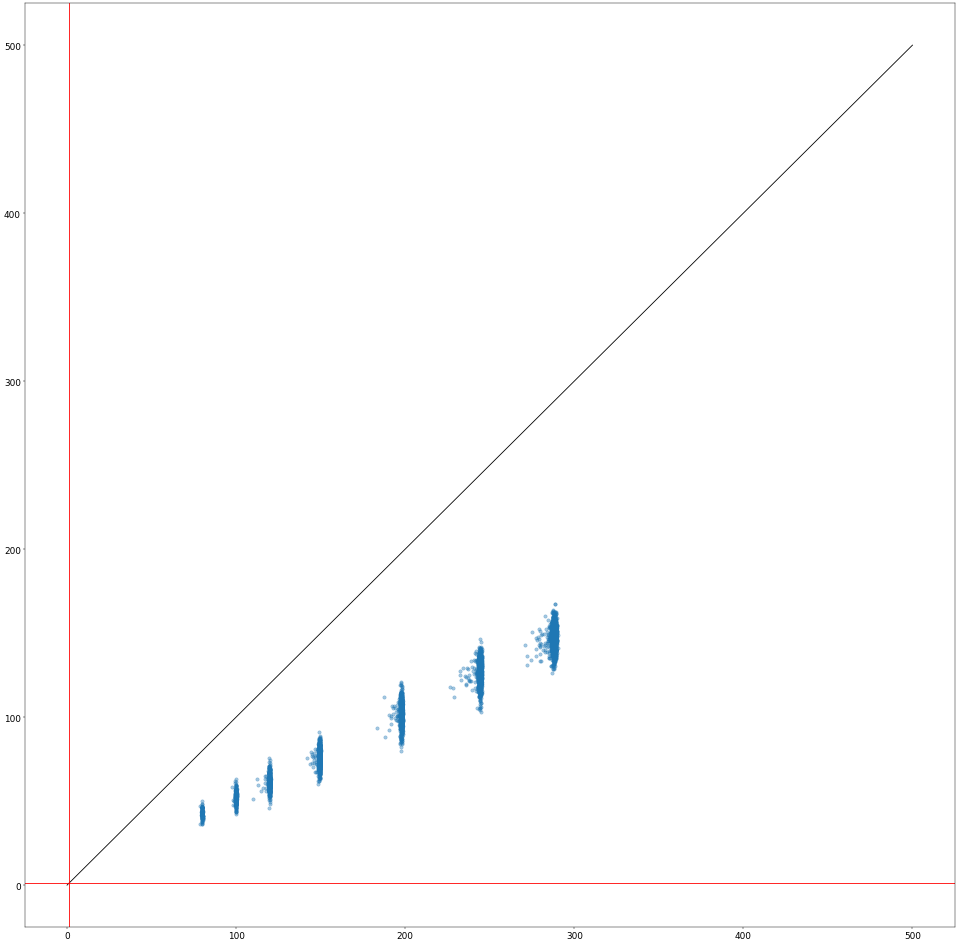

epoch: 28


100%|██████████| 121/121 [00:16<00:00,  7.22it/s]


batches for train: 121
train loss: 4169.456738684788


100%|██████████| 61/61 [00:04<00:00, 14.72it/s]


batches for test: 61
test loss: 12229.241979380124
pred - true / true mean: -0.46887222
pred - true / true std: 0.026956487
mu,sig: -0.46887222 0.026956487


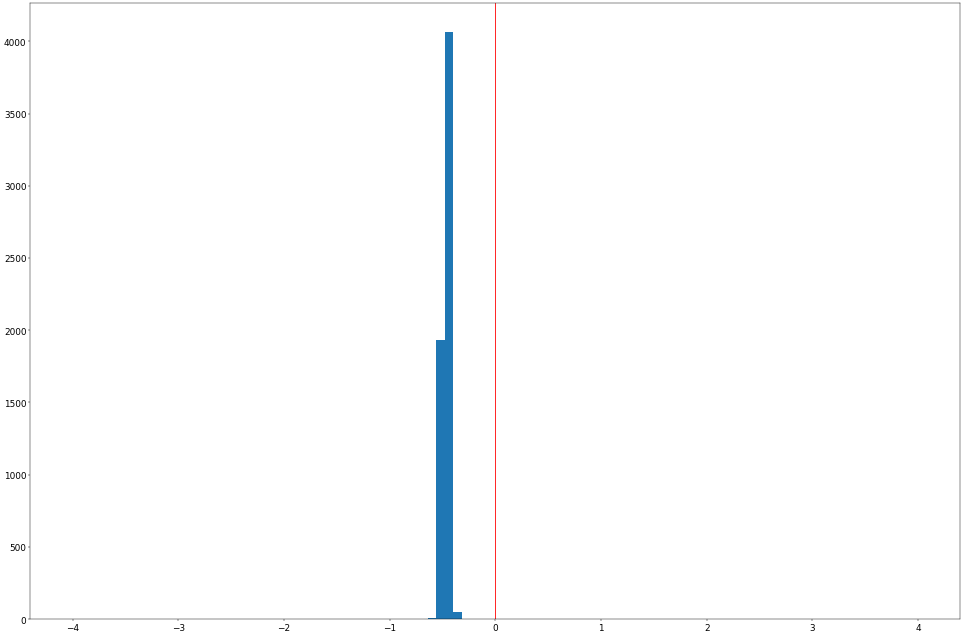

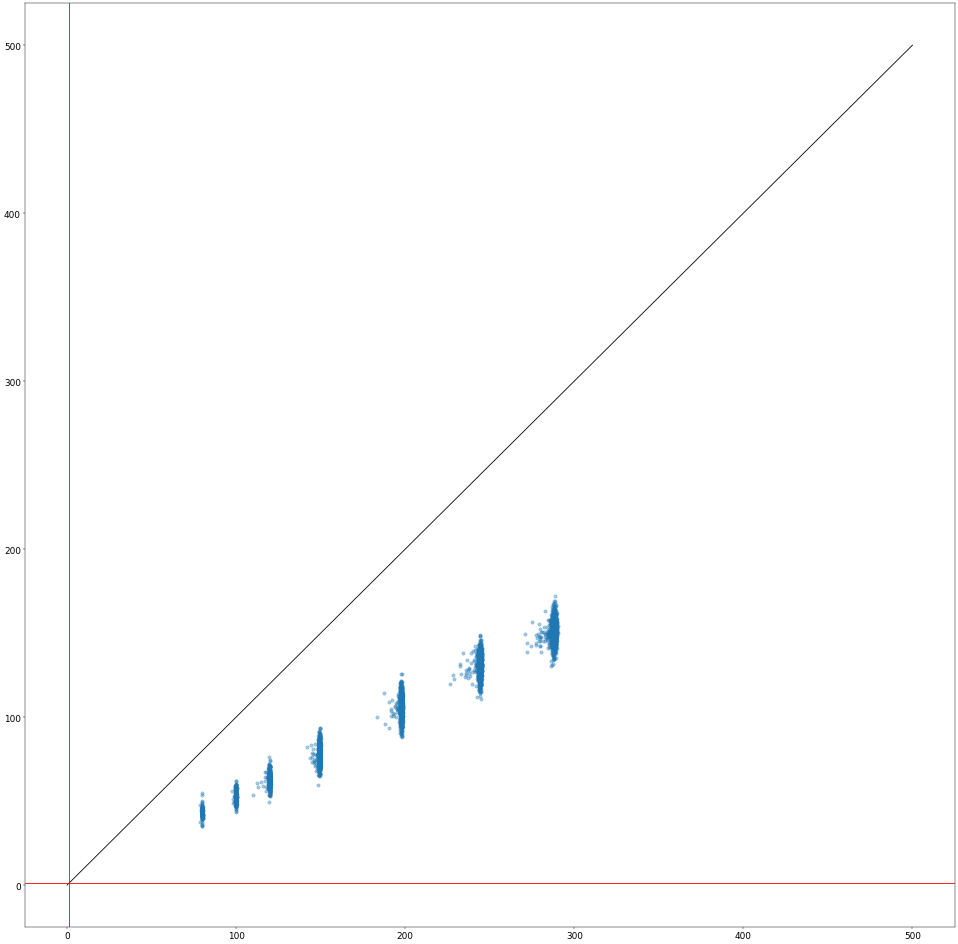

epoch: 29


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 4114.106300038739


100%|██████████| 61/61 [00:03<00:00, 16.75it/s]


batches for test: 61
test loss: 14769.899478099385
pred - true / true mean: -0.5195758
pred - true / true std: 0.027219625
mu,sig: -0.5195758 0.027219625


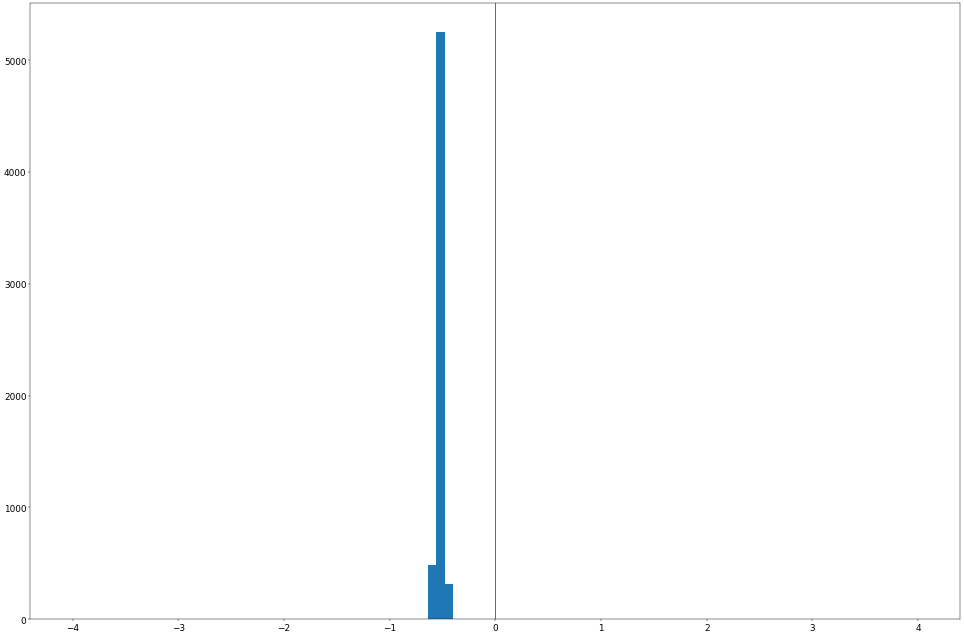

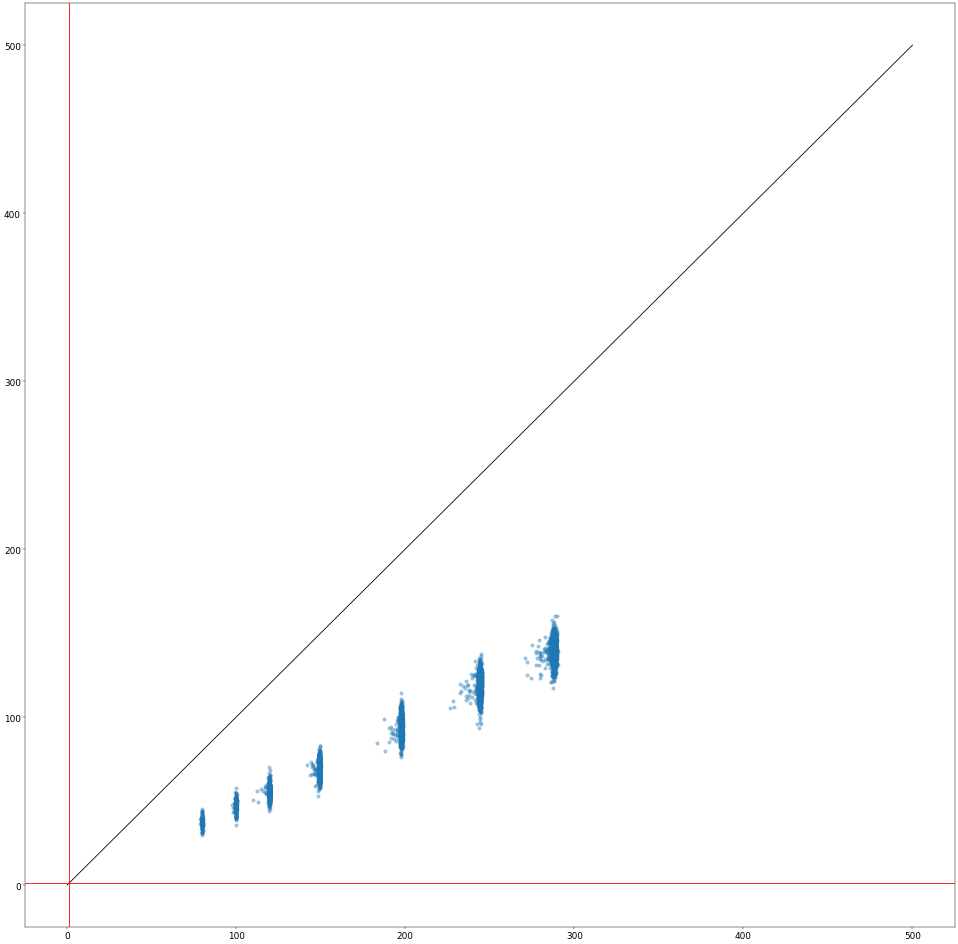

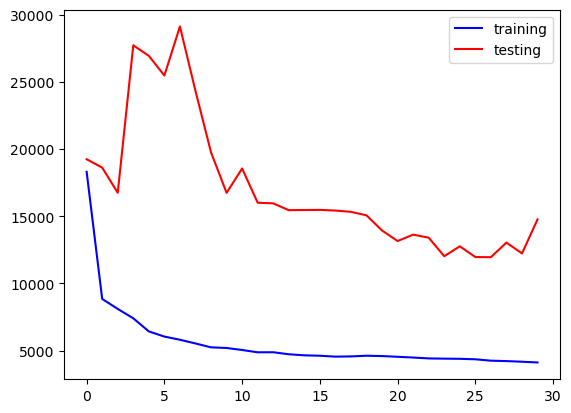

epoch: 30


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 4083.7175898276087


100%|██████████| 61/61 [00:03<00:00, 16.80it/s]


batches for test: 61
test loss: 12024.462730532787
pred - true / true mean: -0.46101502
pred - true / true std: 0.02861679
mu,sig: -0.46101502 0.02861679


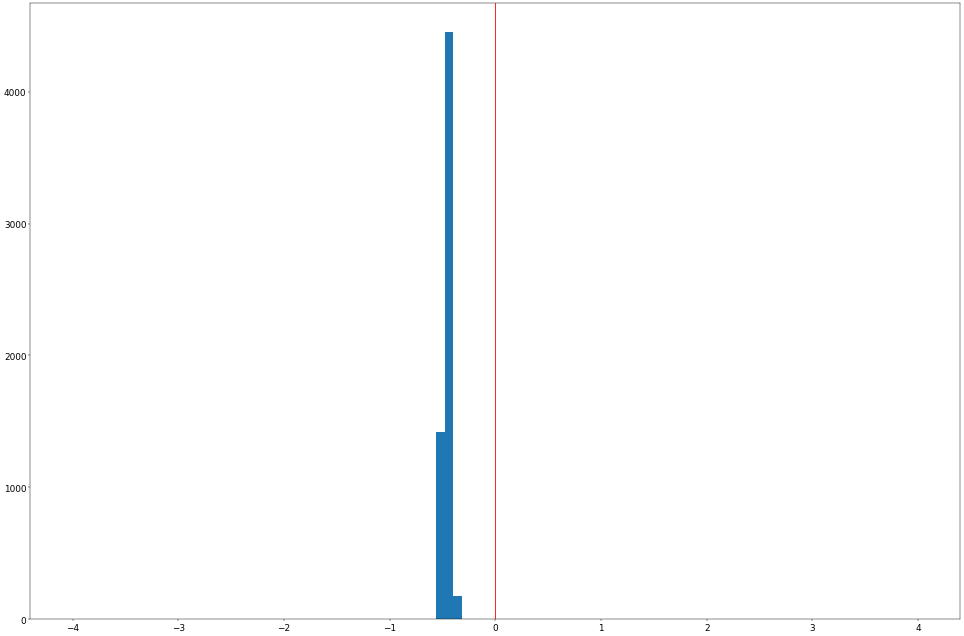

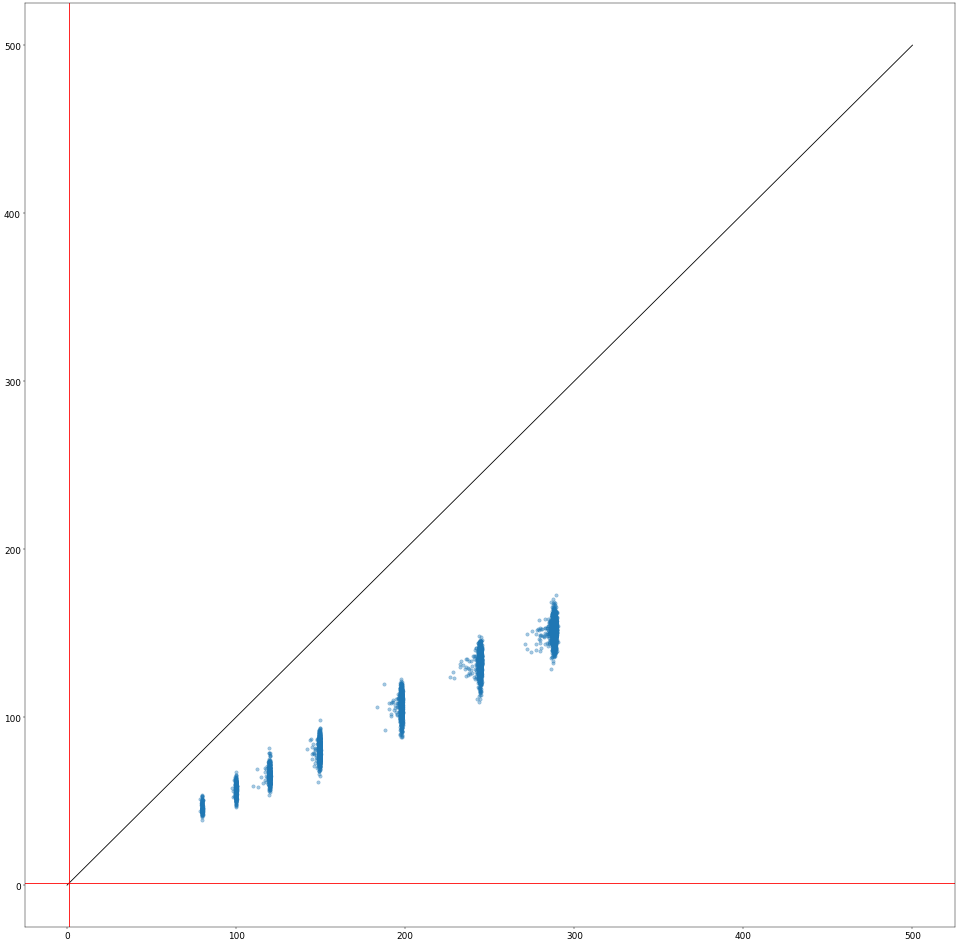

epoch: 31


100%|██████████| 121/121 [00:16<00:00,  7.29it/s]


batches for train: 121
train loss: 4112.401320780605


100%|██████████| 61/61 [00:03<00:00, 16.90it/s]


batches for test: 61
test loss: 12495.534419825819
pred - true / true mean: -0.47159976
pred - true / true std: 0.02790281
mu,sig: -0.47159976 0.02790281


<Figure size 640x480 with 0 Axes>

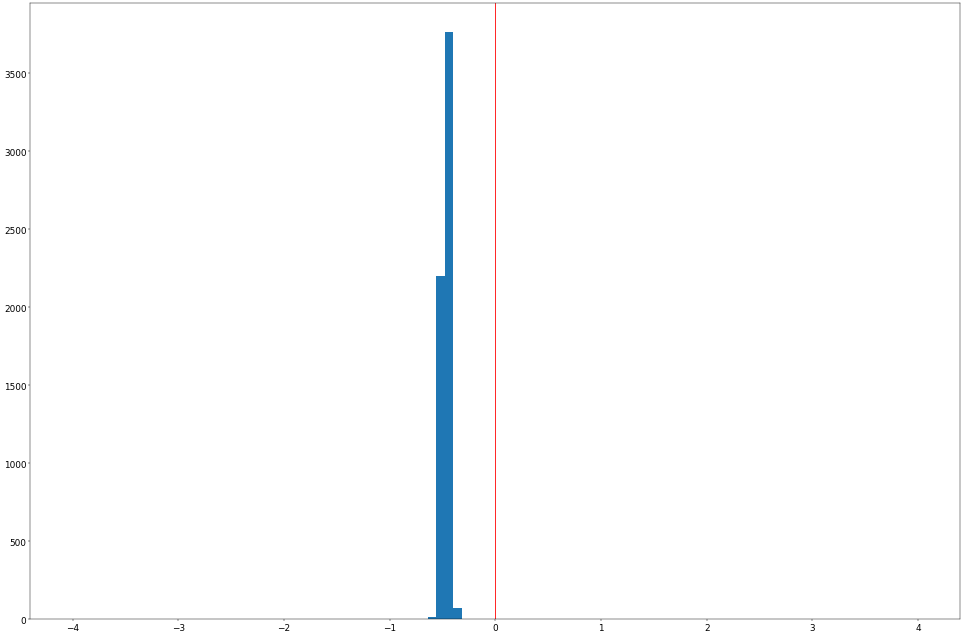

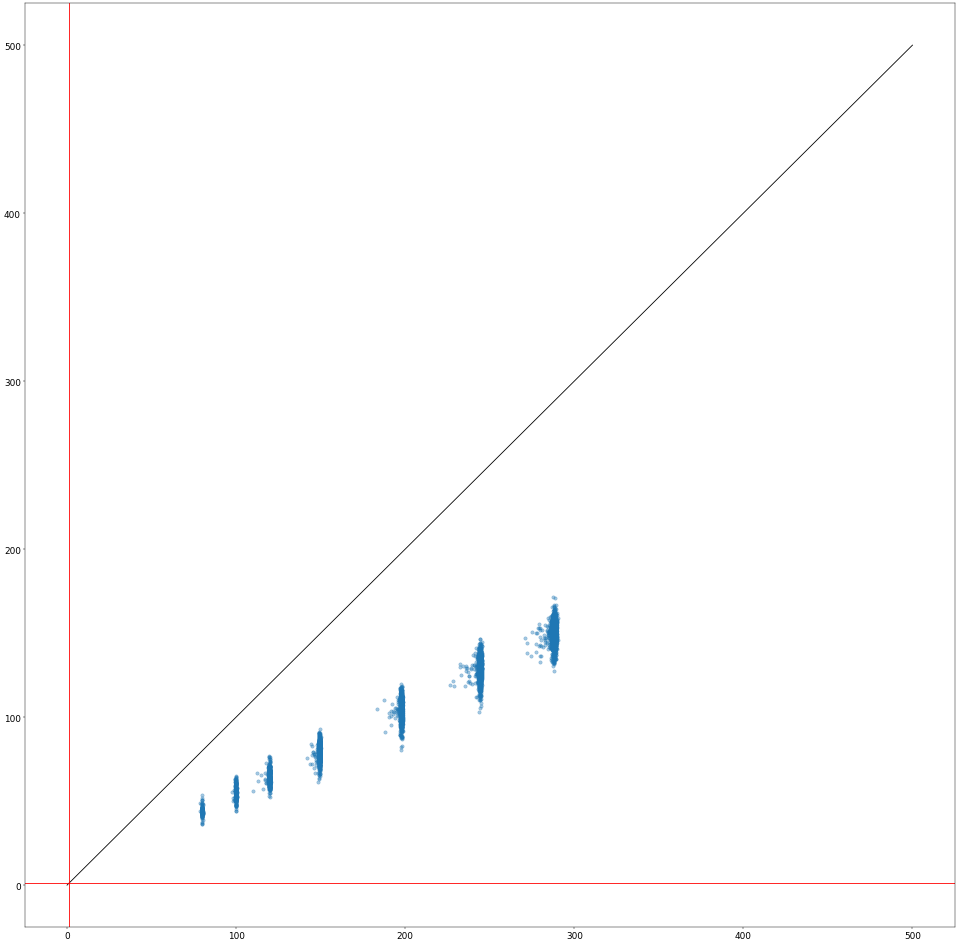

epoch: 32


100%|██████████| 121/121 [00:16<00:00,  7.28it/s]


batches for train: 121
train loss: 4137.890909494447


100%|██████████| 61/61 [00:03<00:00, 16.87it/s]


batches for test: 61
test loss: 12794.45959272541
pred - true / true mean: -0.47806132
pred - true / true std: 0.02685002
mu,sig: -0.47806132 0.02685002


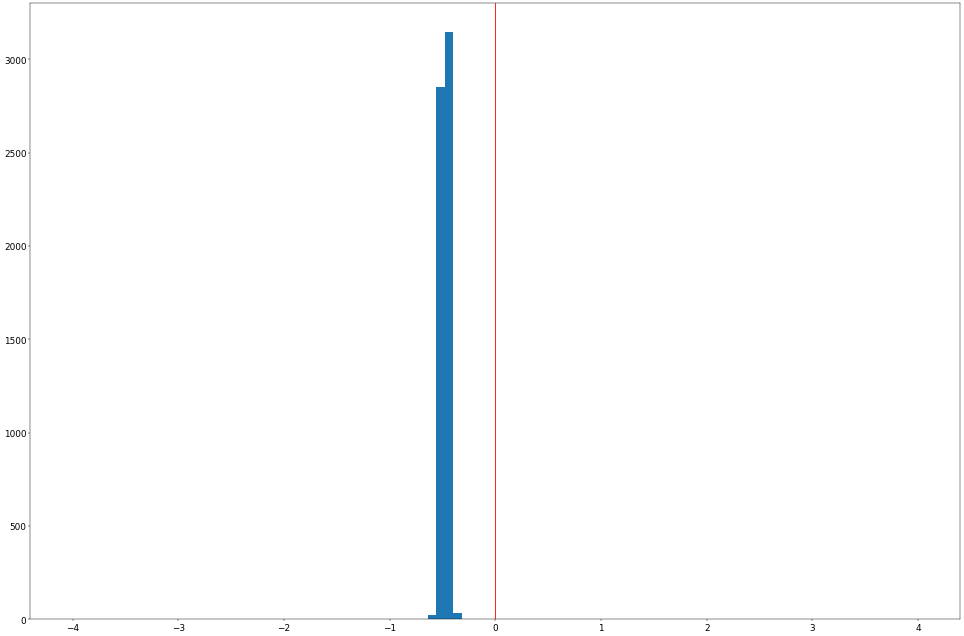

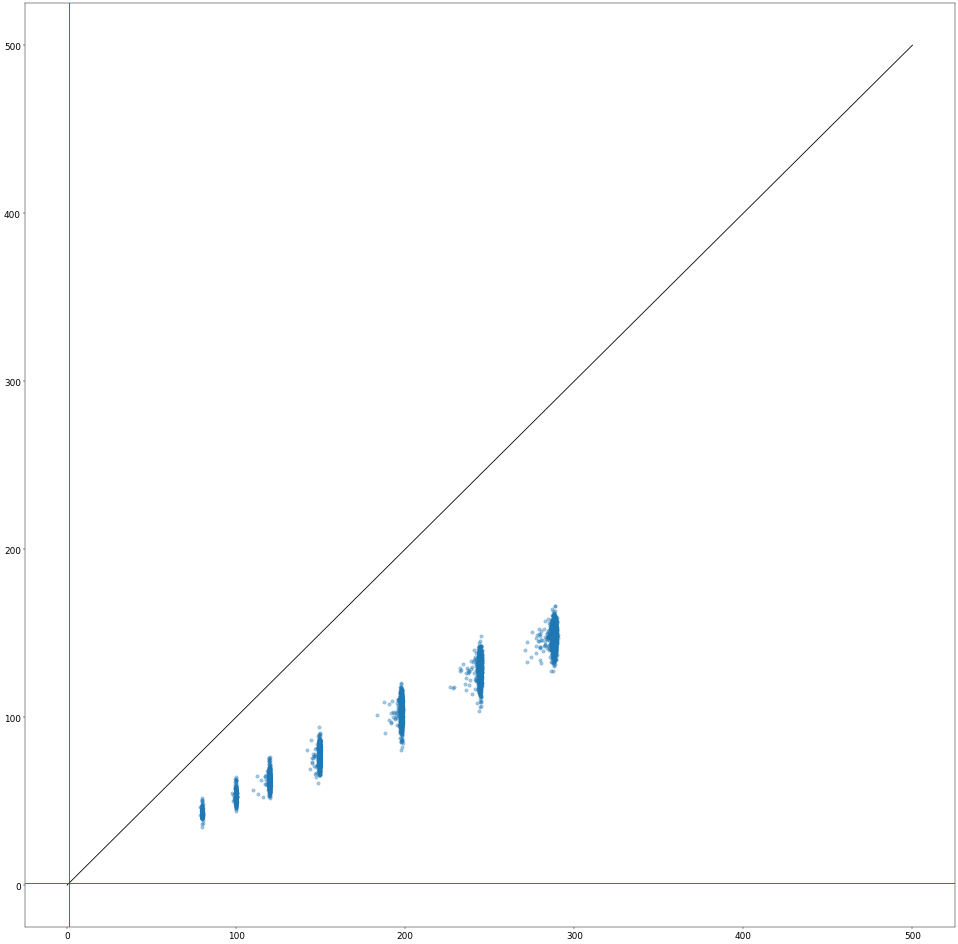

epoch: 33


100%|██████████| 121/121 [00:16<00:00,  7.28it/s]


batches for train: 121
train loss: 4021.997609036028


100%|██████████| 61/61 [00:03<00:00, 16.76it/s]


batches for test: 61
test loss: 12015.187451972337
pred - true / true mean: -0.45816645
pred - true / true std: 0.029757235
mu,sig: -0.45816645 0.029757235


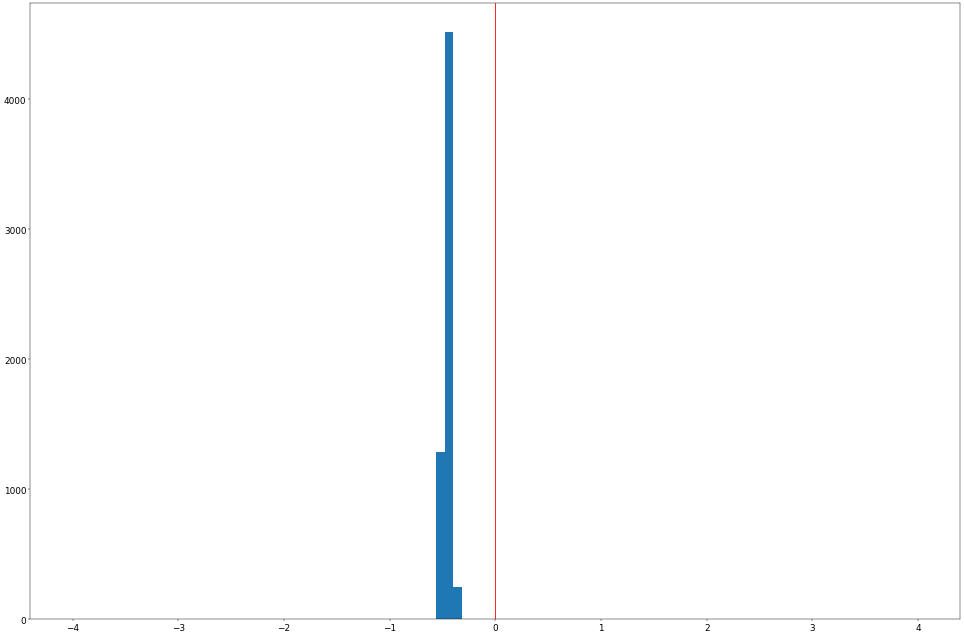

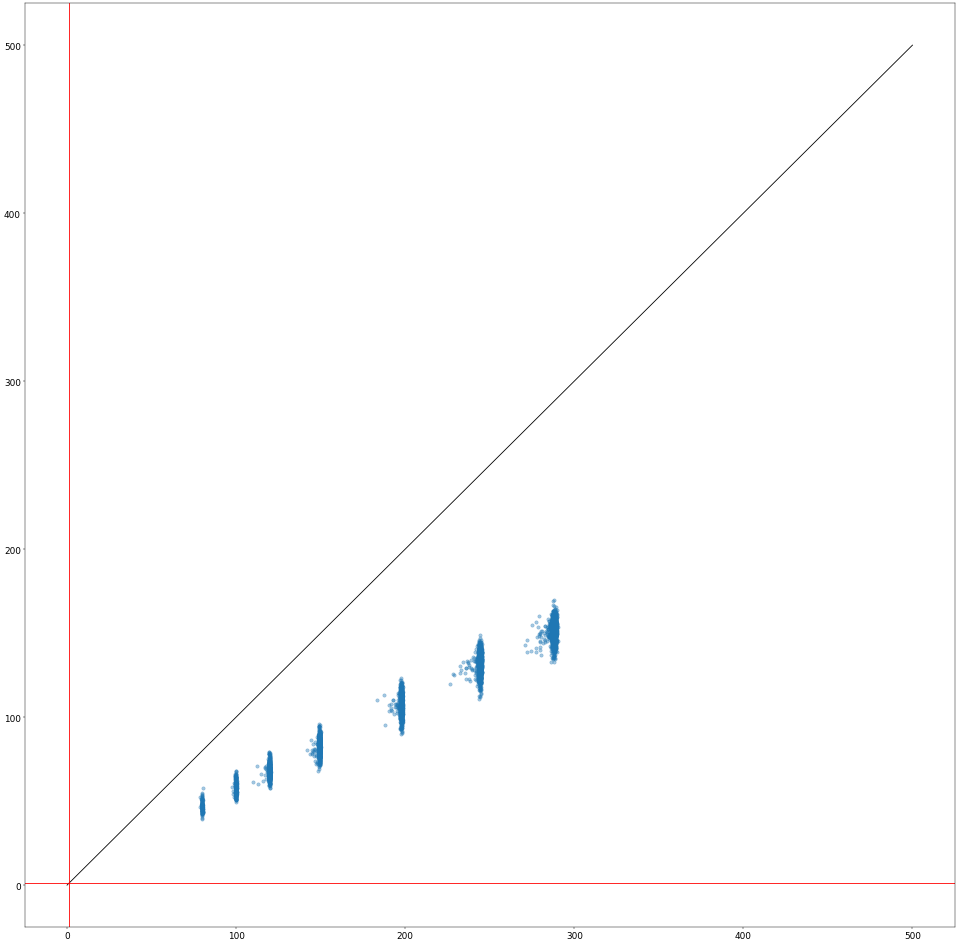

epoch: 34


100%|██████████| 121/121 [00:16<00:00,  7.24it/s]


batches for train: 121
train loss: 3992.7348188920455


100%|██████████| 61/61 [00:03<00:00, 16.59it/s]


batches for test: 61
test loss: 11805.999823898566
pred - true / true mean: -0.45594117
pred - true / true std: 0.028599815
mu,sig: -0.45594117 0.028599815


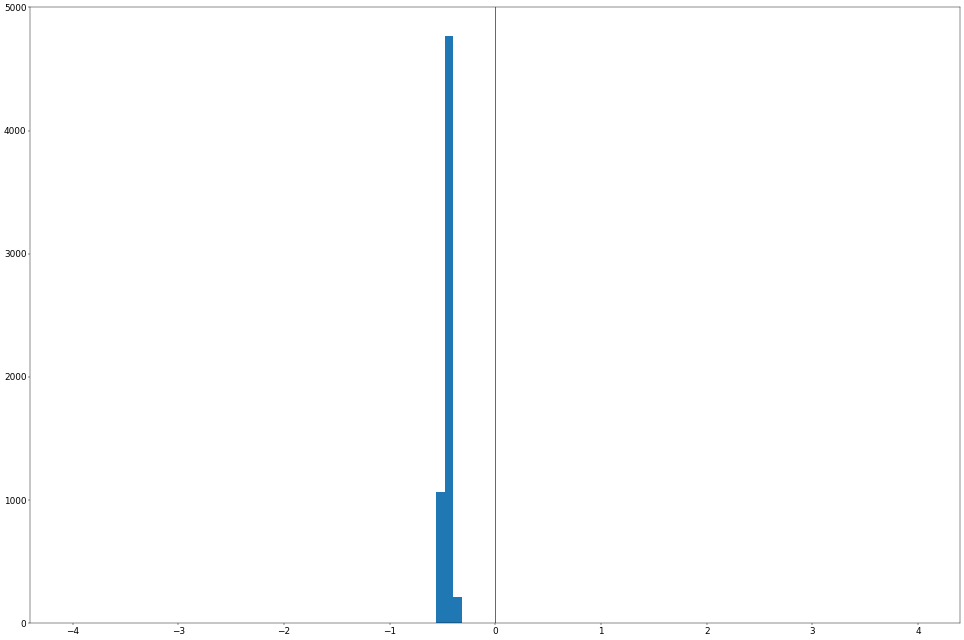

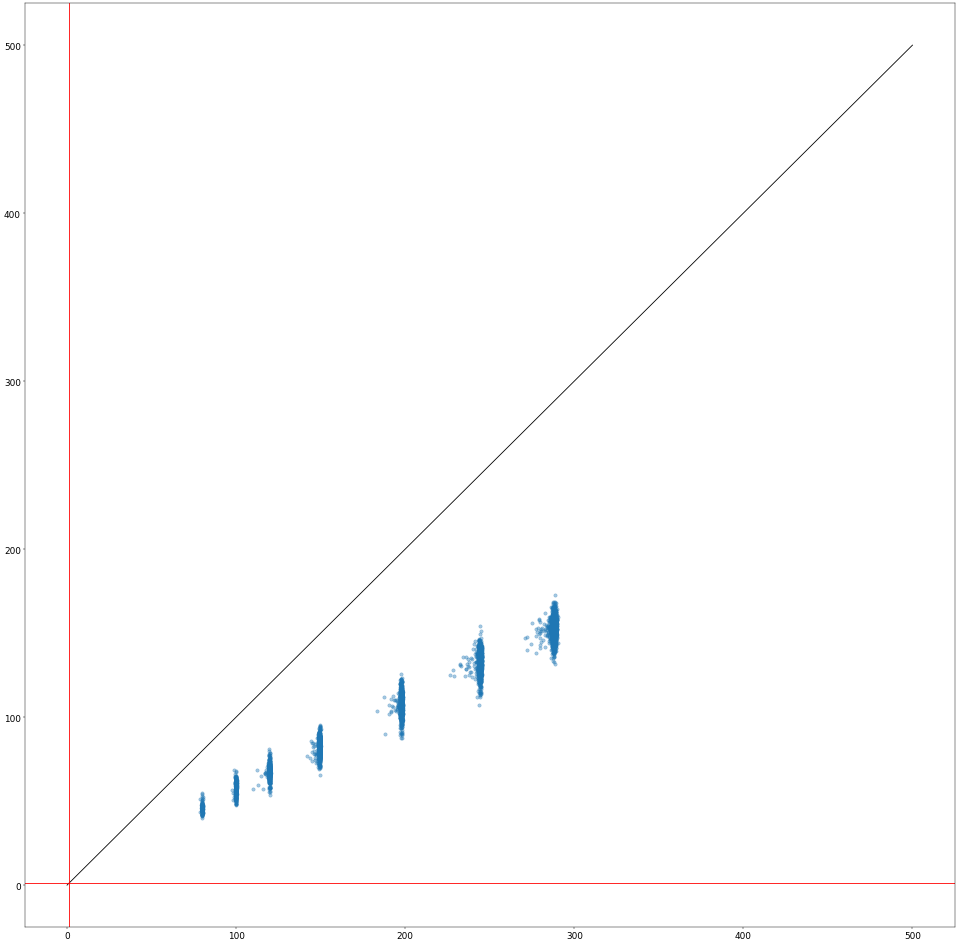

new best test loss: 11805.999823898566
epoch: 35


100%|██████████| 121/121 [00:16<00:00,  7.26it/s]


batches for train: 121
train loss: 4001.63755003874


100%|██████████| 61/61 [00:03<00:00, 16.63it/s]


batches for test: 61
test loss: 12761.069063780738
pred - true / true mean: -0.4781278
pred - true / true std: 0.023222784
mu,sig: -0.4781278 0.023222784


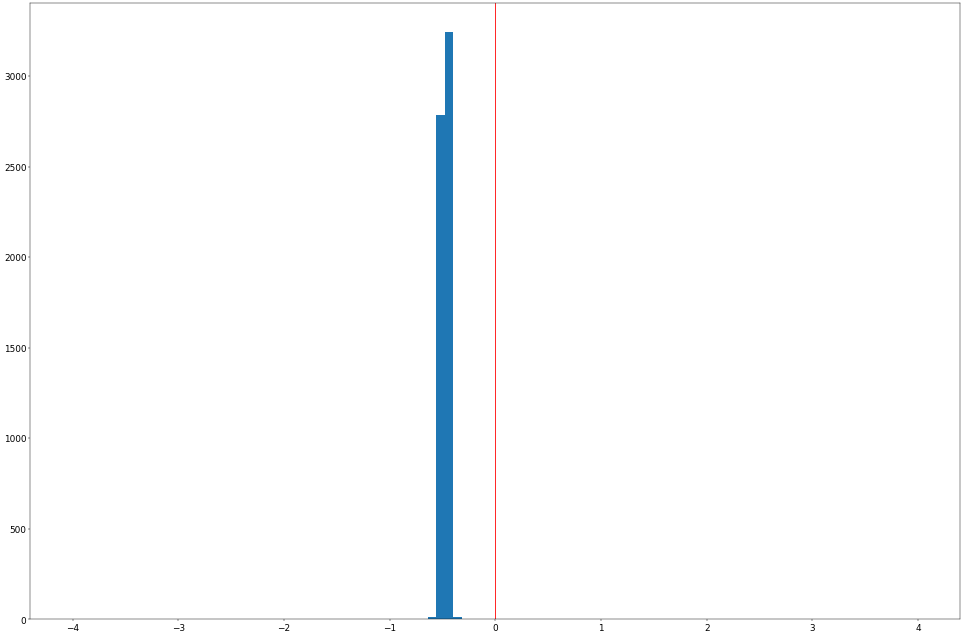

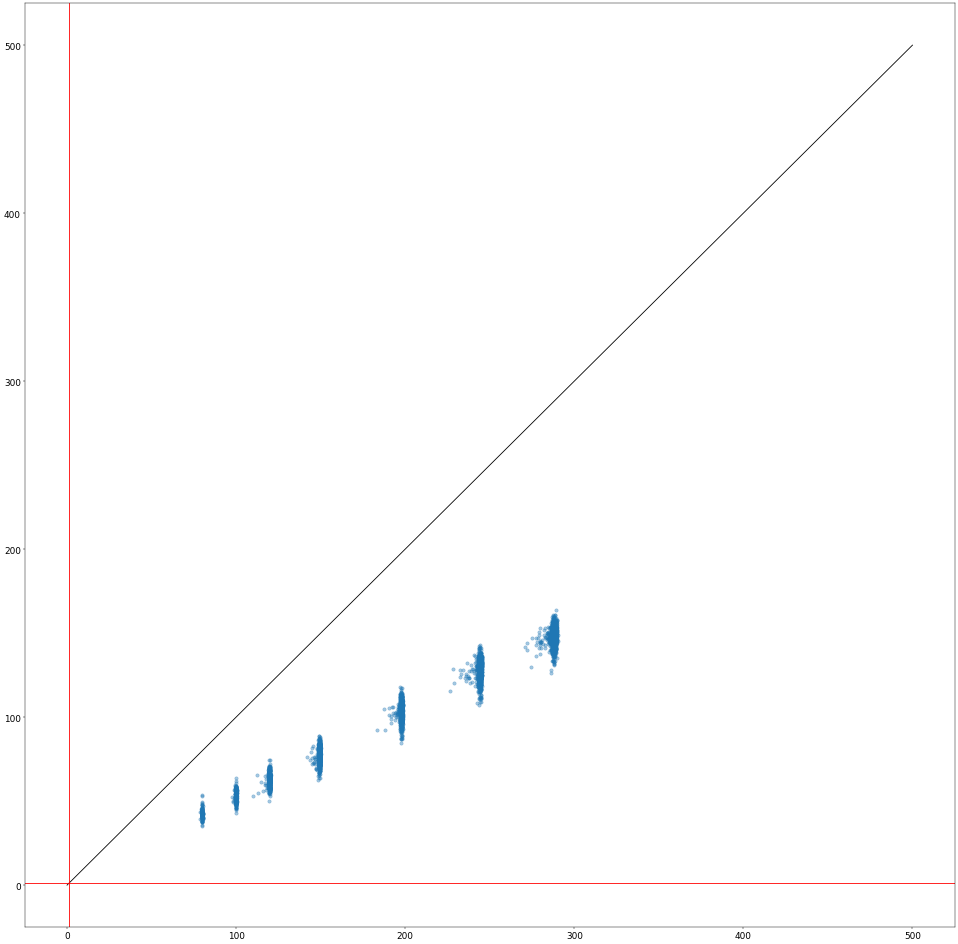

epoch: 36


100%|██████████| 121/121 [00:16<00:00,  7.29it/s]


batches for train: 121
train loss: 4011.473998014592


100%|██████████| 61/61 [00:04<00:00, 14.76it/s]


batches for test: 61
test loss: 12219.873367059427
pred - true / true mean: -0.46750274
pred - true / true std: 0.02416514
mu,sig: -0.46750274 0.02416514


<Figure size 640x480 with 0 Axes>

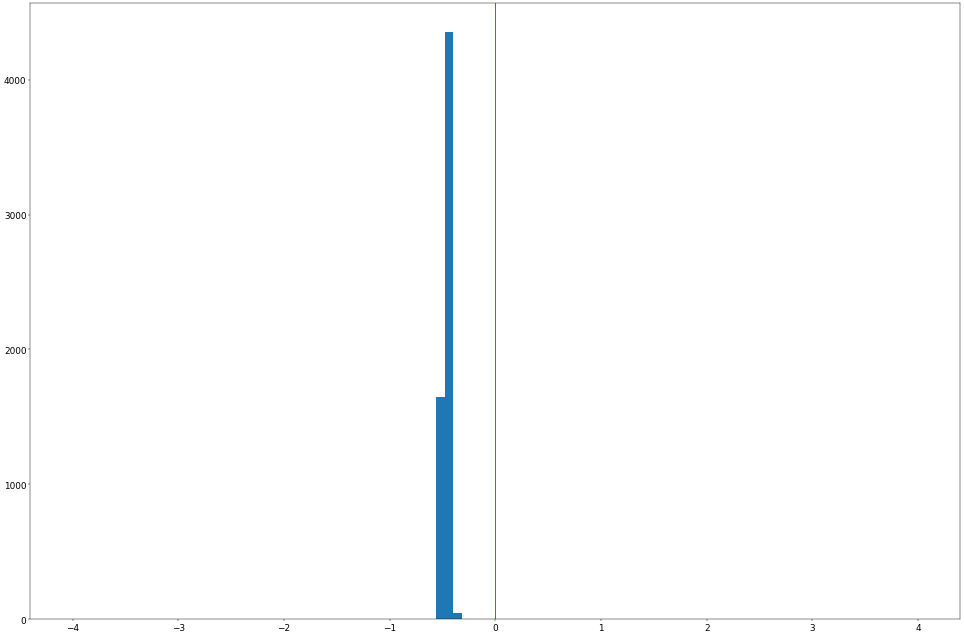

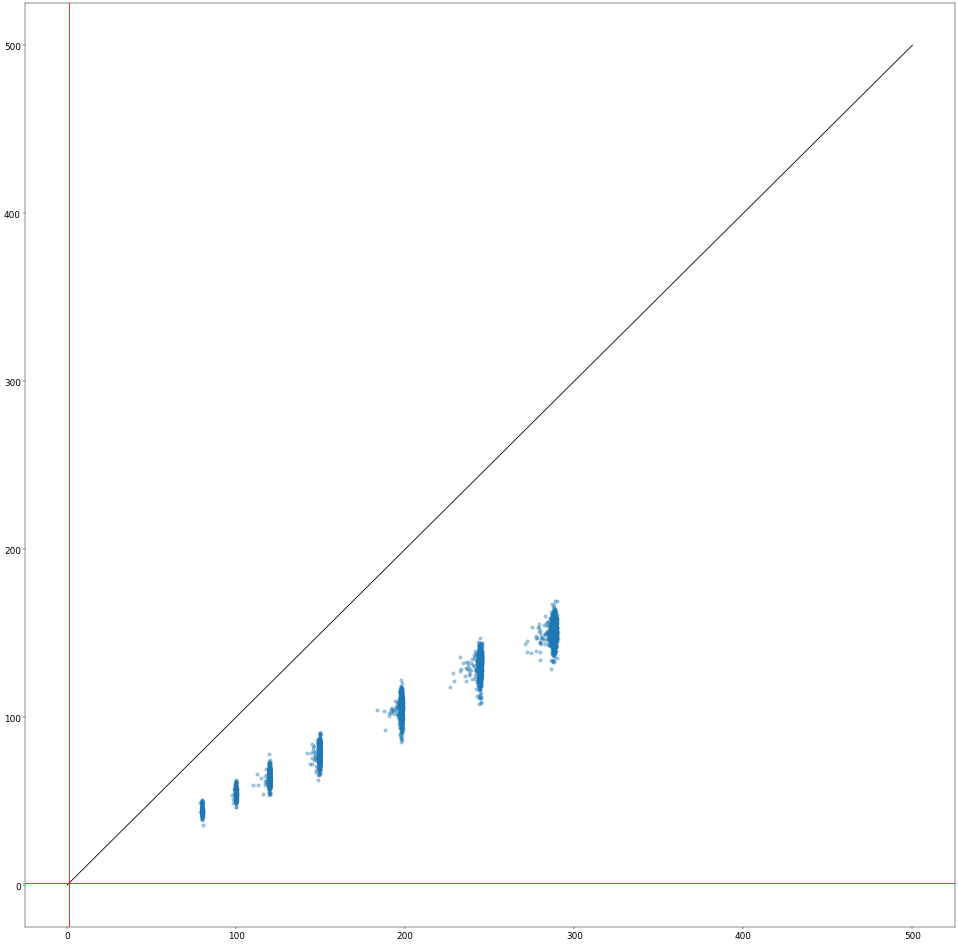

epoch: 37


100%|██████████| 121/121 [00:16<00:00,  7.28it/s]


batches for train: 121
train loss: 3984.8195498127584


100%|██████████| 61/61 [00:03<00:00, 16.35it/s]


batches for test: 61
test loss: 12624.971855788934
pred - true / true mean: -0.47365397
pred - true / true std: 0.024083687
mu,sig: -0.47365397 0.024083687


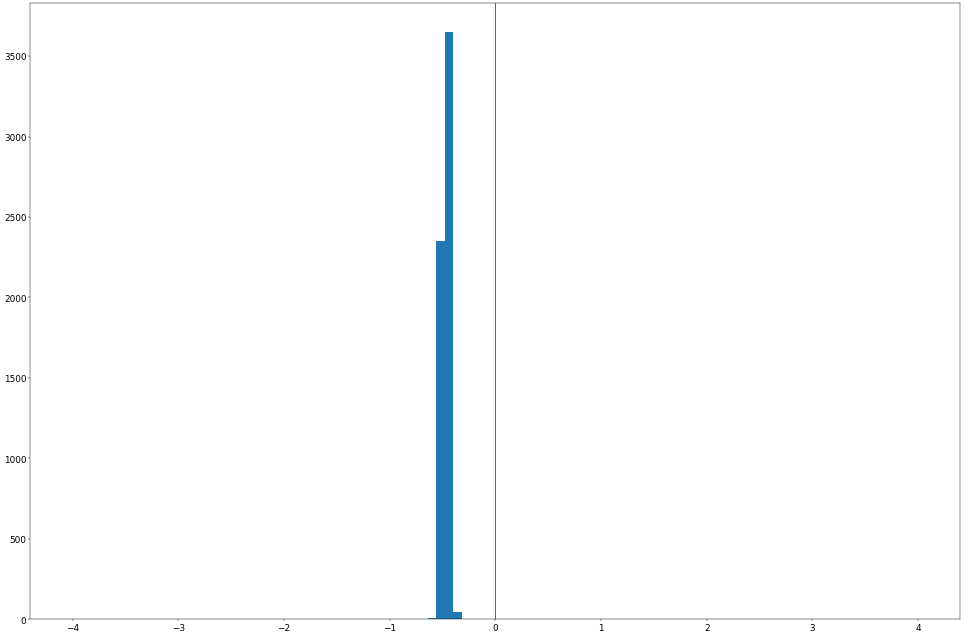

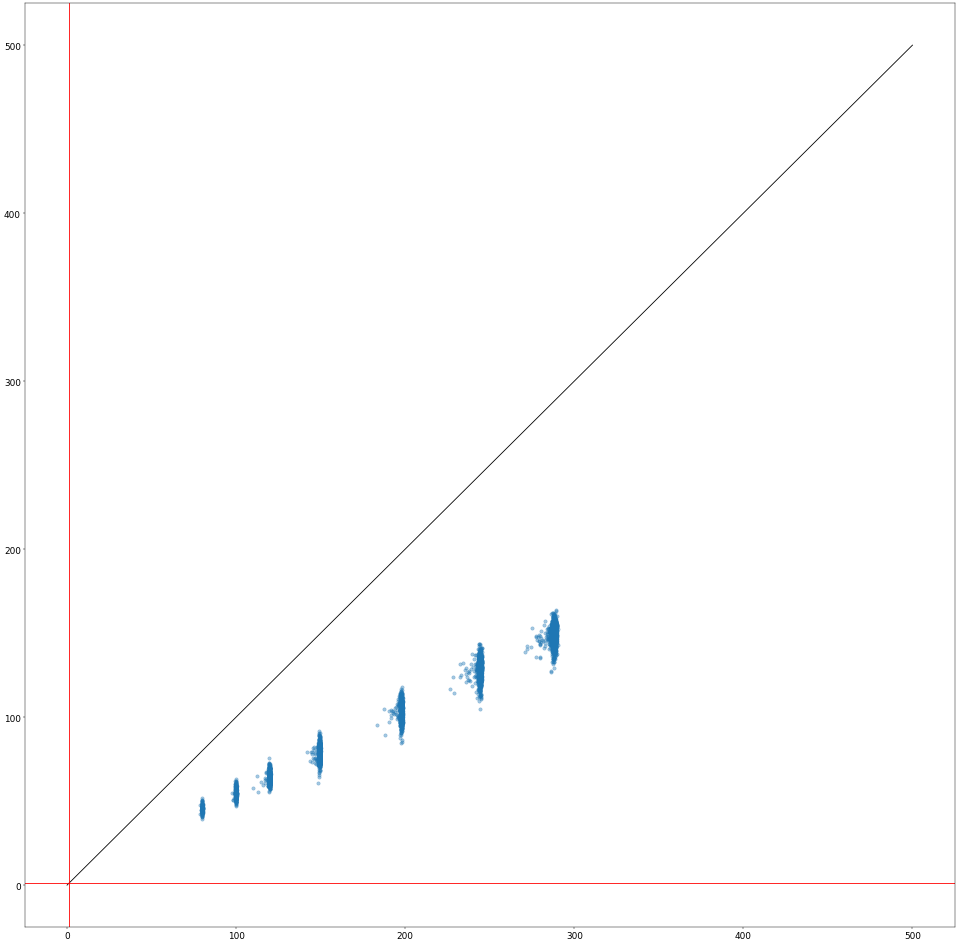

epoch: 38


100%|██████████| 121/121 [00:16<00:00,  7.35it/s]


batches for train: 121
train loss: 3932.3495670034868


100%|██████████| 61/61 [00:03<00:00, 16.91it/s]


batches for test: 61
test loss: 11488.737640881147
pred - true / true mean: -0.45106548
pred - true / true std: 0.025772702
mu,sig: -0.45106548 0.025772702


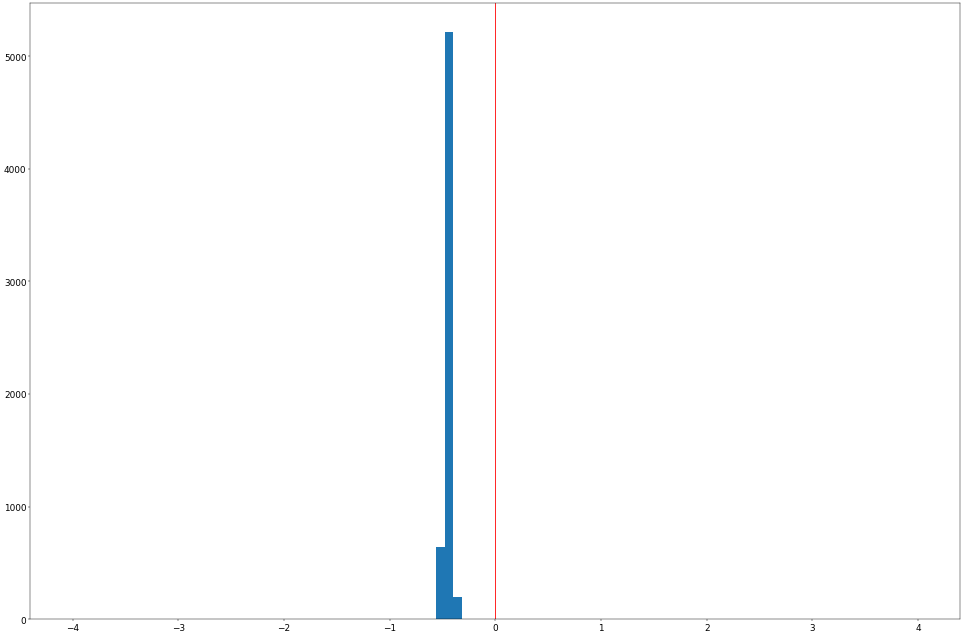

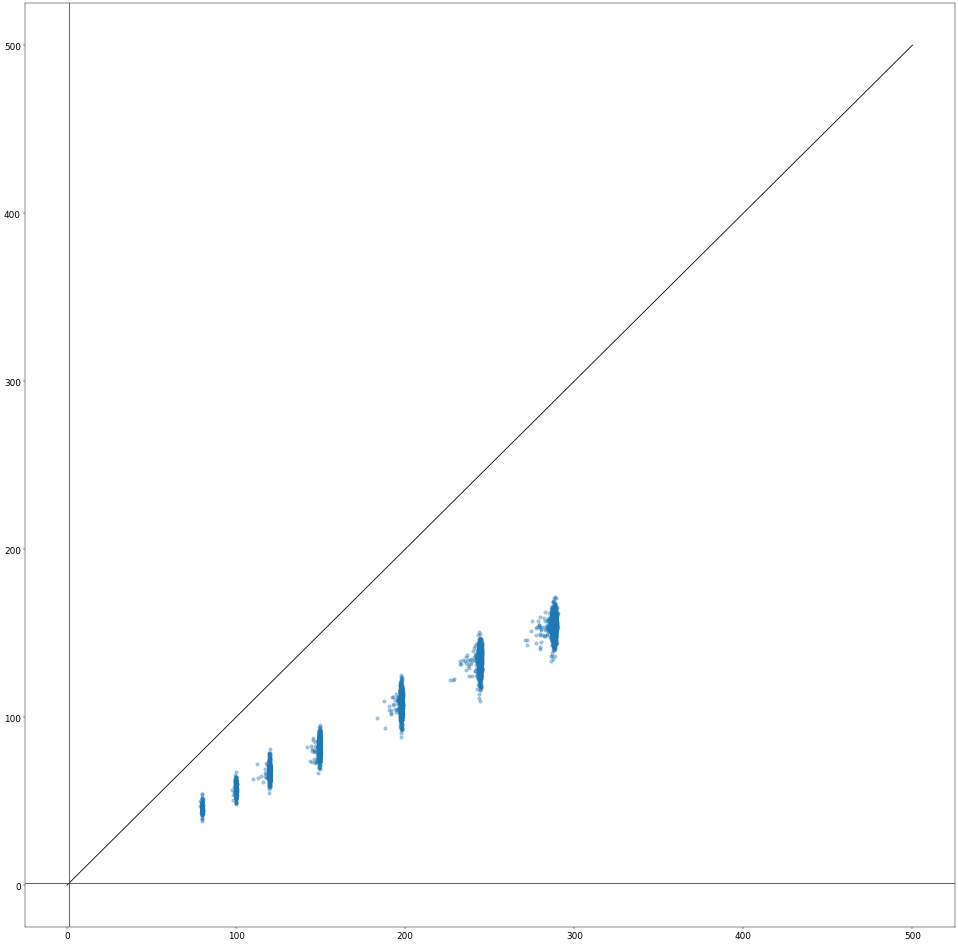

new best test loss: 11488.737640881147
epoch: 39


100%|██████████| 121/121 [00:16<00:00,  7.35it/s]


batches for train: 121
train loss: 3948.9262110182076


100%|██████████| 61/61 [00:03<00:00, 16.86it/s]


batches for test: 61
test loss: 12196.88233222336
pred - true / true mean: -0.4655173
pred - true / true std: 0.022779964
mu,sig: -0.4655173 0.022779964


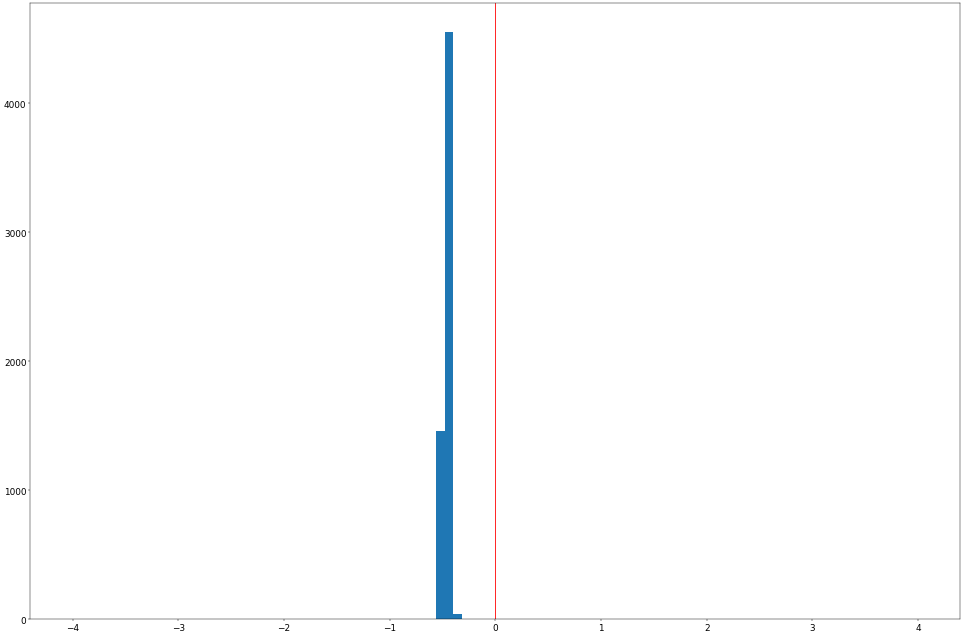

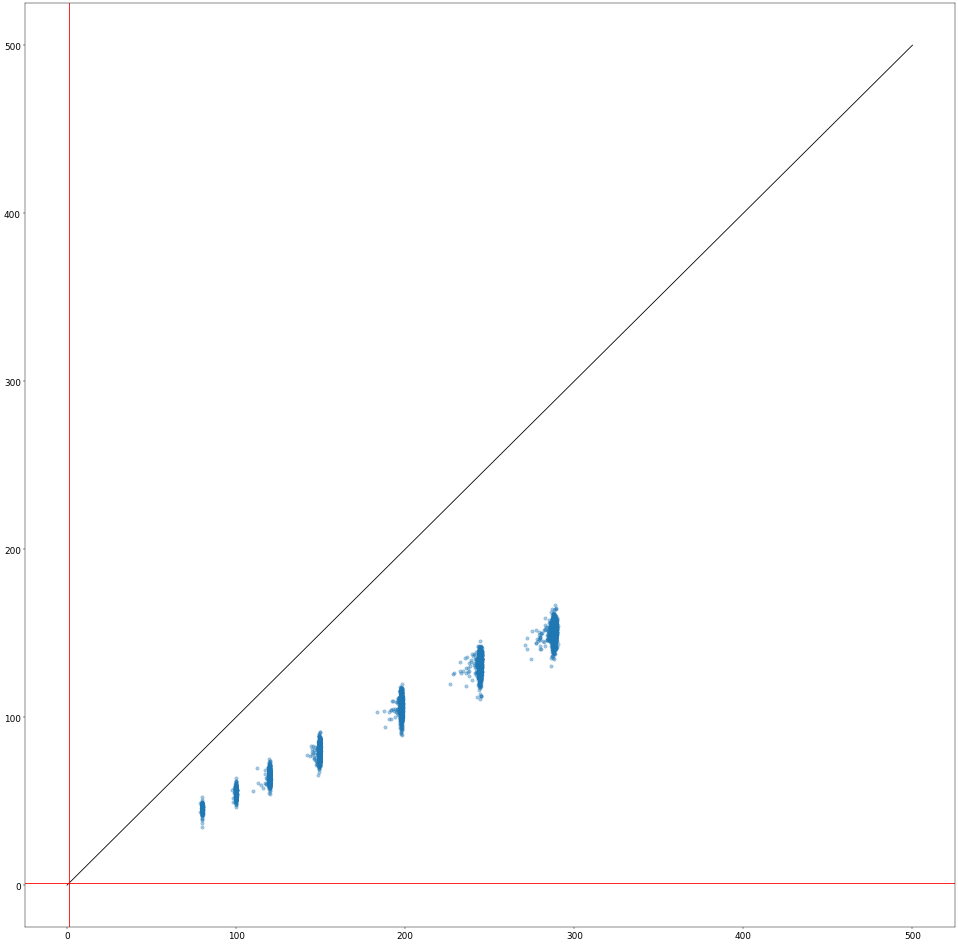

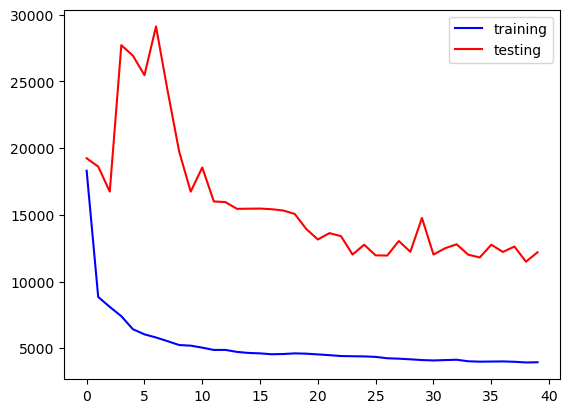

epoch: 40


100%|██████████| 121/121 [00:16<00:00,  7.35it/s]


batches for train: 121
train loss: 3788.6625169486056


100%|██████████| 61/61 [00:03<00:00, 16.83it/s]


batches for test: 61
test loss: 13632.118068007172
pred - true / true mean: -0.49146944
pred - true / true std: 0.023952914
mu,sig: -0.49146944 0.023952914


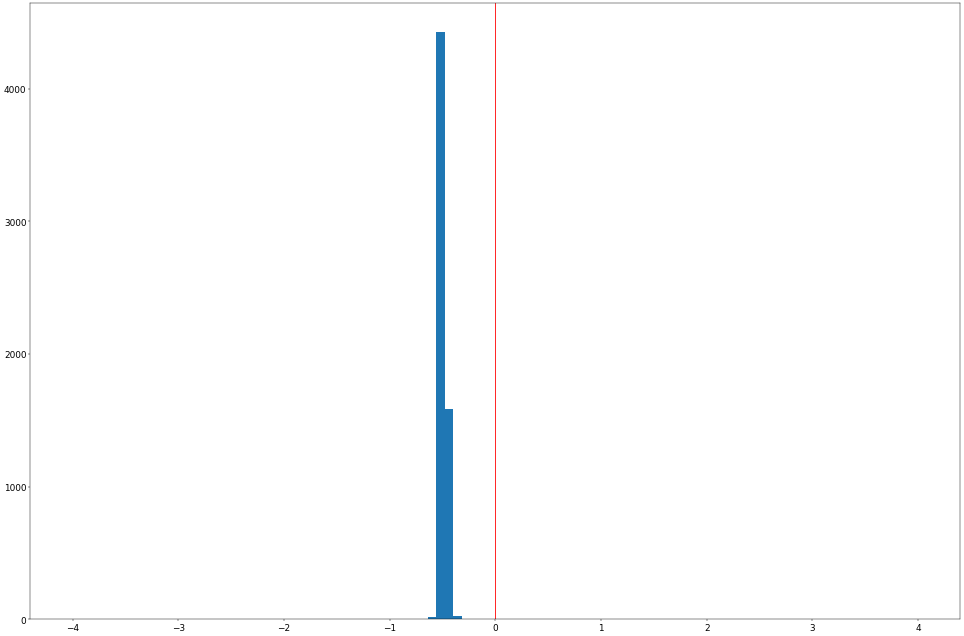

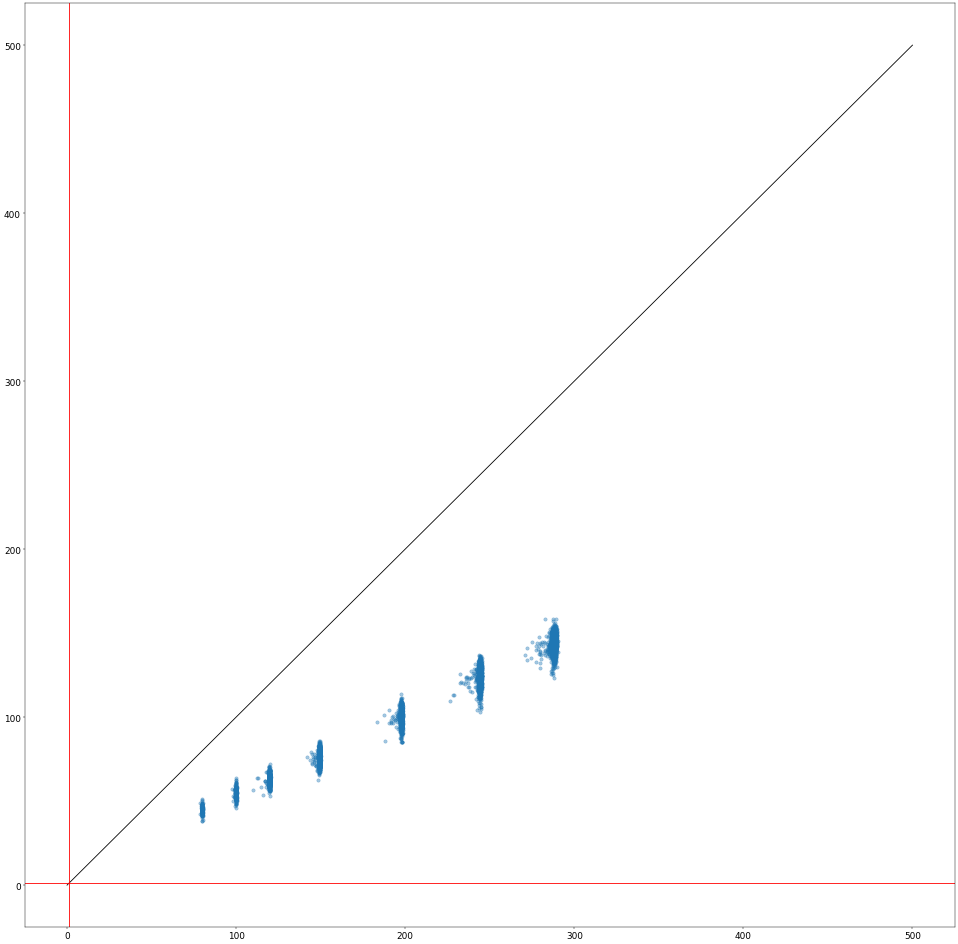

epoch: 41


100%|██████████| 121/121 [00:16<00:00,  7.34it/s]


batches for train: 121
train loss: 3845.86861602531


100%|██████████| 61/61 [00:03<00:00, 16.88it/s]


batches for test: 61
test loss: 11856.345559042009
pred - true / true mean: -0.45837894
pred - true / true std: 0.025006415
mu,sig: -0.45837894 0.025006415


<Figure size 640x480 with 0 Axes>

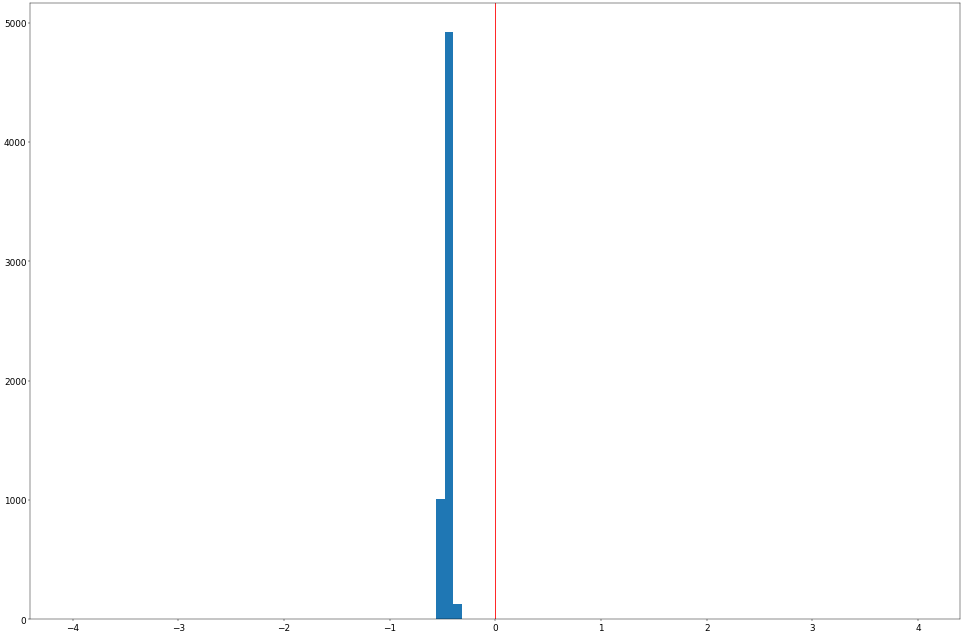

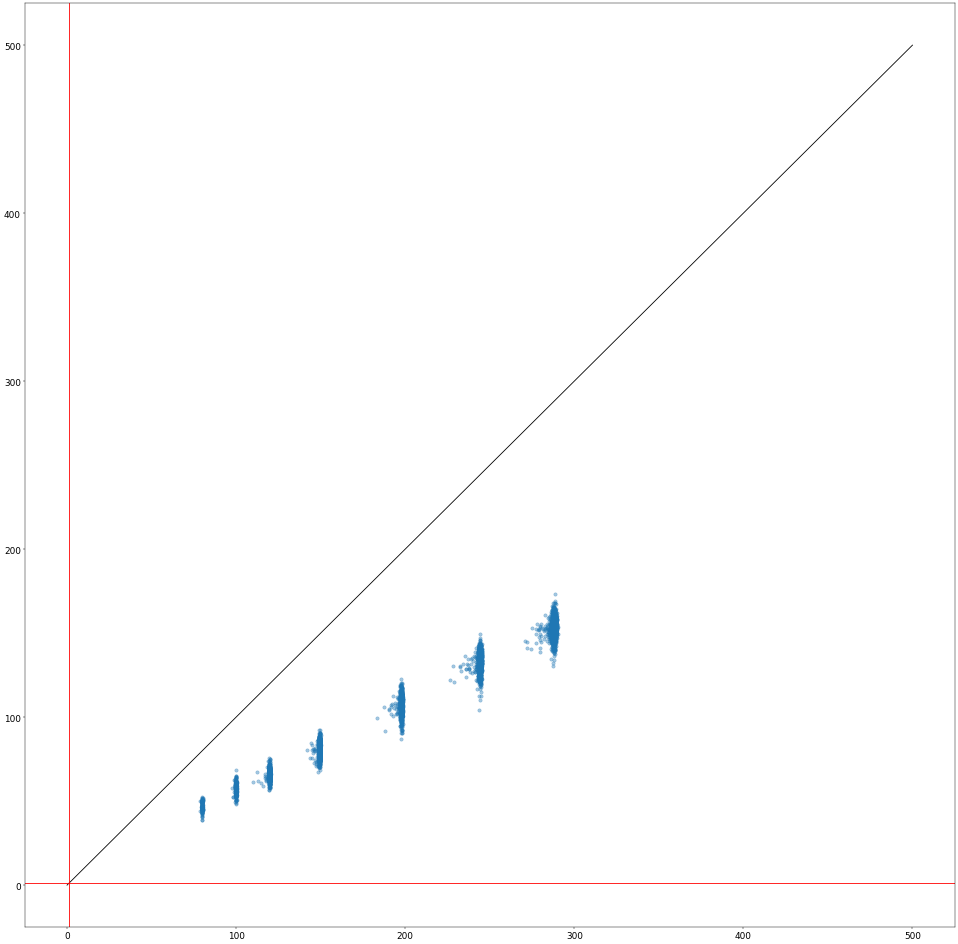

epoch: 42


100%|██████████| 121/121 [00:16<00:00,  7.33it/s]


batches for train: 121
train loss: 3880.402900632748


100%|██████████| 61/61 [00:03<00:00, 16.89it/s]


batches for test: 61
test loss: 11979.889824538934
pred - true / true mean: -0.46249482
pred - true / true std: 0.02352389
mu,sig: -0.46249482 0.02352389


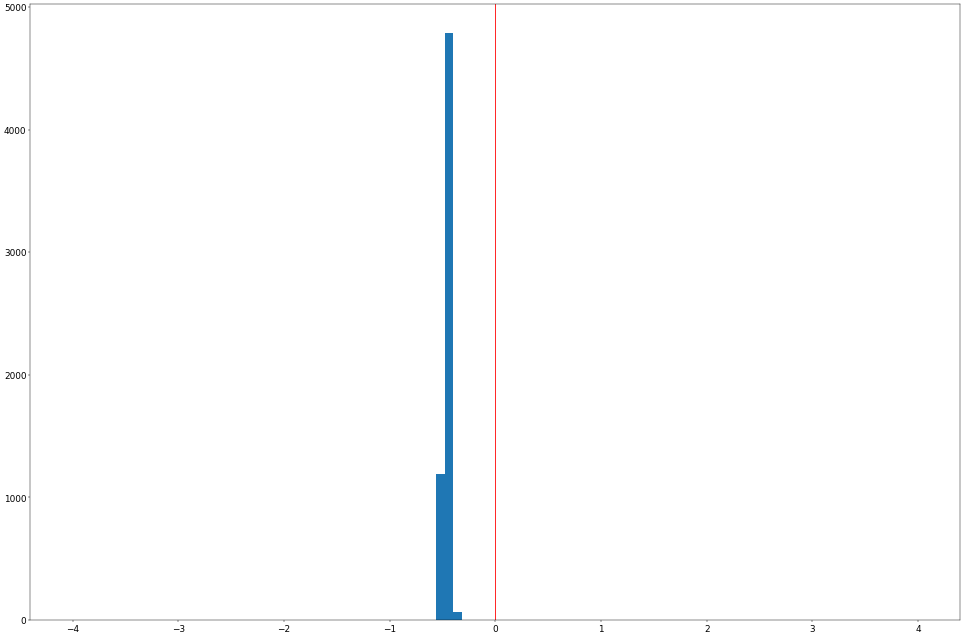

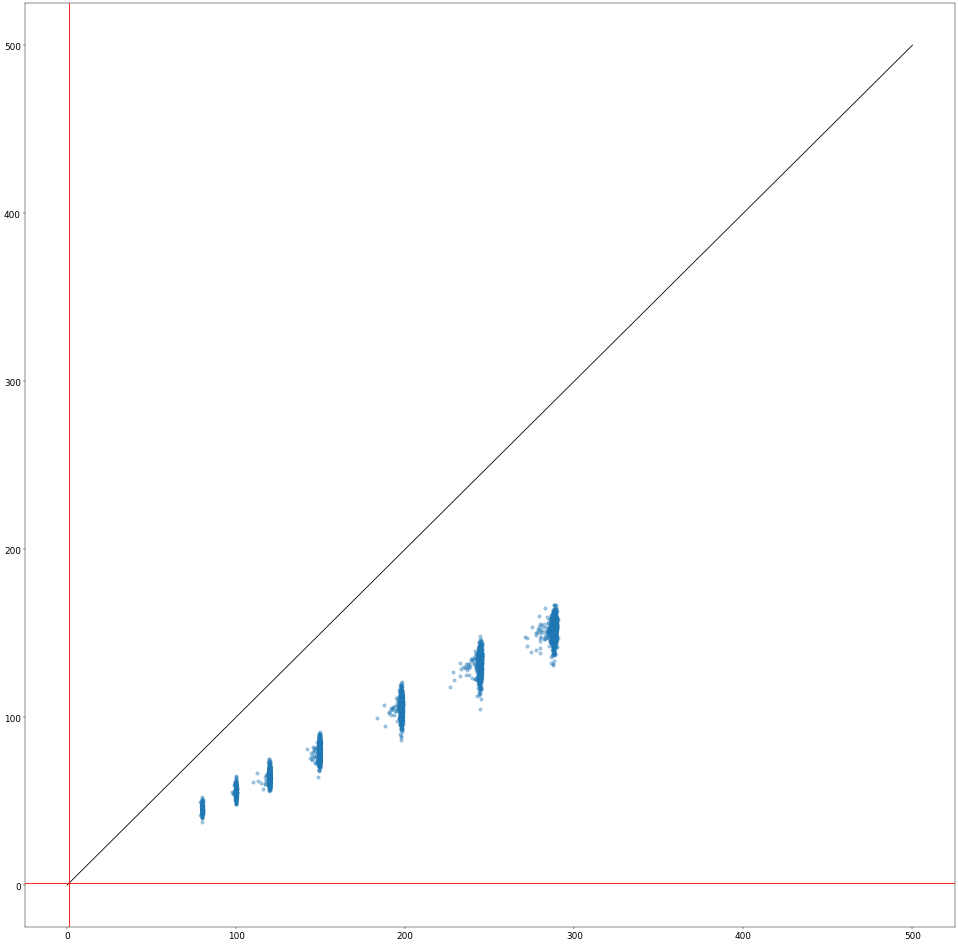

epoch: 43


100%|██████████| 121/121 [00:16<00:00,  7.34it/s]


batches for train: 121
train loss: 3794.759624386622


100%|██████████| 61/61 [00:03<00:00, 17.04it/s]


batches for test: 61
test loss: 11978.252001152663
pred - true / true mean: -0.46292475
pred - true / true std: 0.023902154
mu,sig: -0.46292475 0.023902154


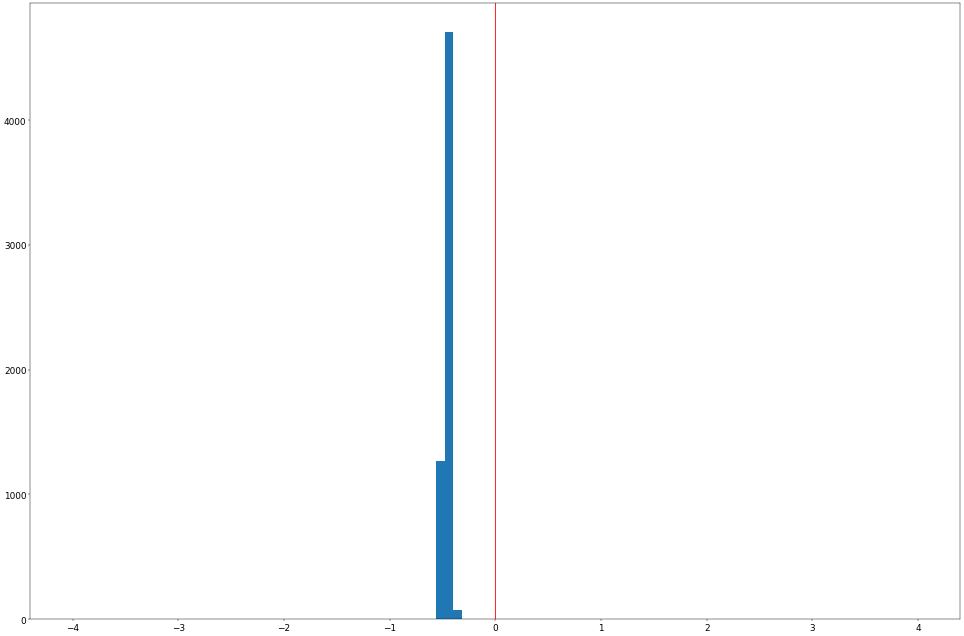

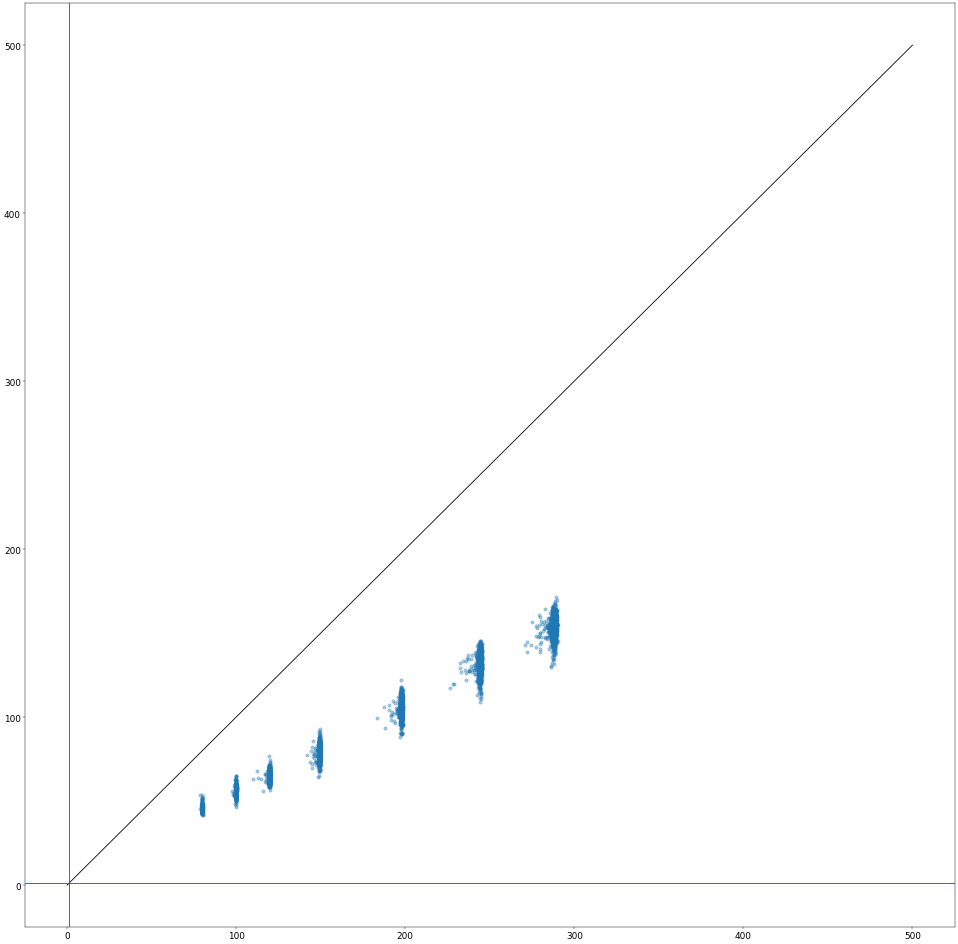

epoch: 44


100%|██████████| 121/121 [00:16<00:00,  7.33it/s]


batches for train: 121
train loss: 3857.371789853435


100%|██████████| 61/61 [00:04<00:00, 14.63it/s]


batches for test: 61
test loss: 11852.214603611681
pred - true / true mean: -0.4595043
pred - true / true std: 0.024481257
mu,sig: -0.4595043 0.024481257


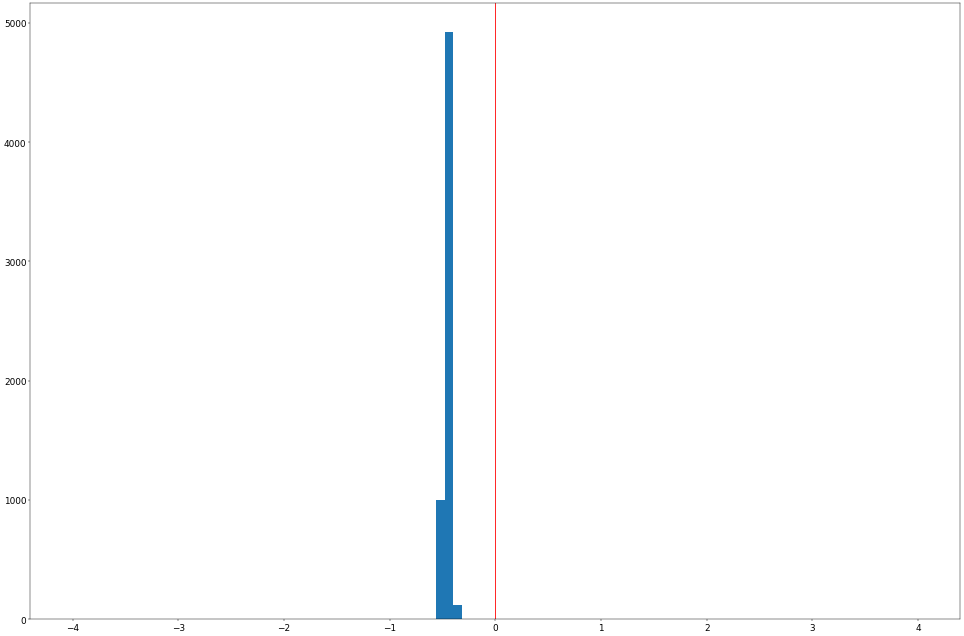

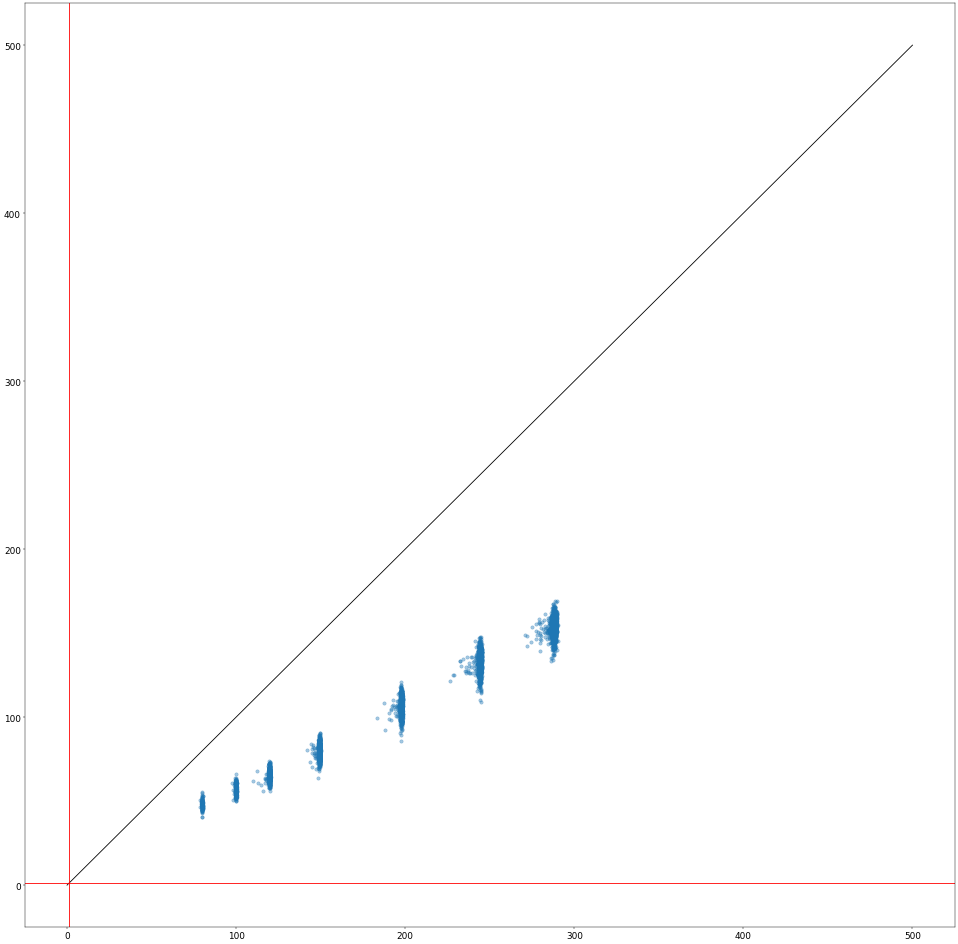

epoch: 45


100%|██████████| 121/121 [00:16<00:00,  7.29it/s]


batches for train: 121
train loss: 3830.591219815341


100%|██████████| 61/61 [00:03<00:00, 16.62it/s]


batches for test: 61
test loss: 11656.856877561475
pred - true / true mean: -0.45358622
pred - true / true std: 0.02813245
mu,sig: -0.45358622 0.02813245


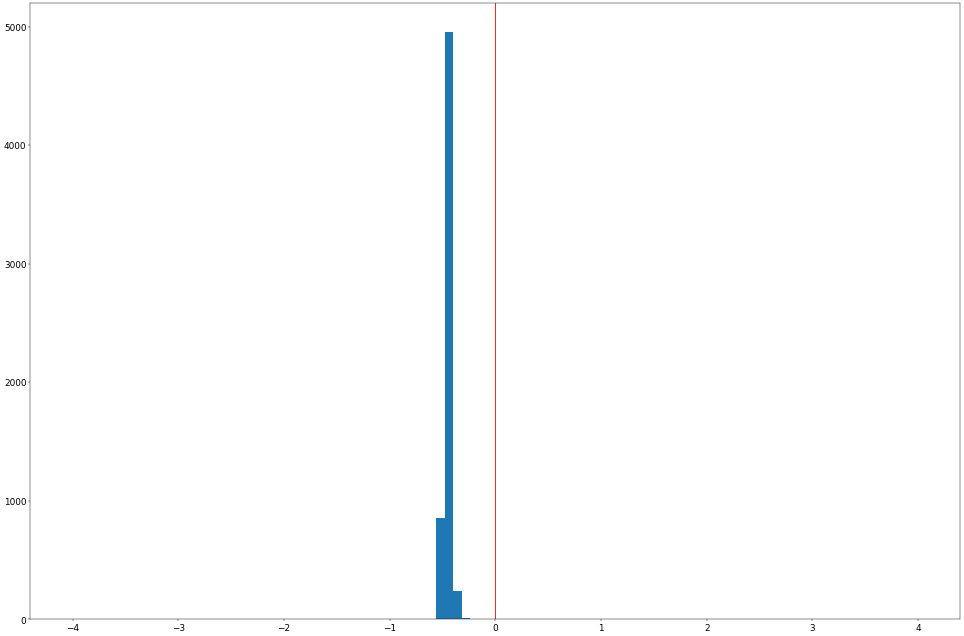

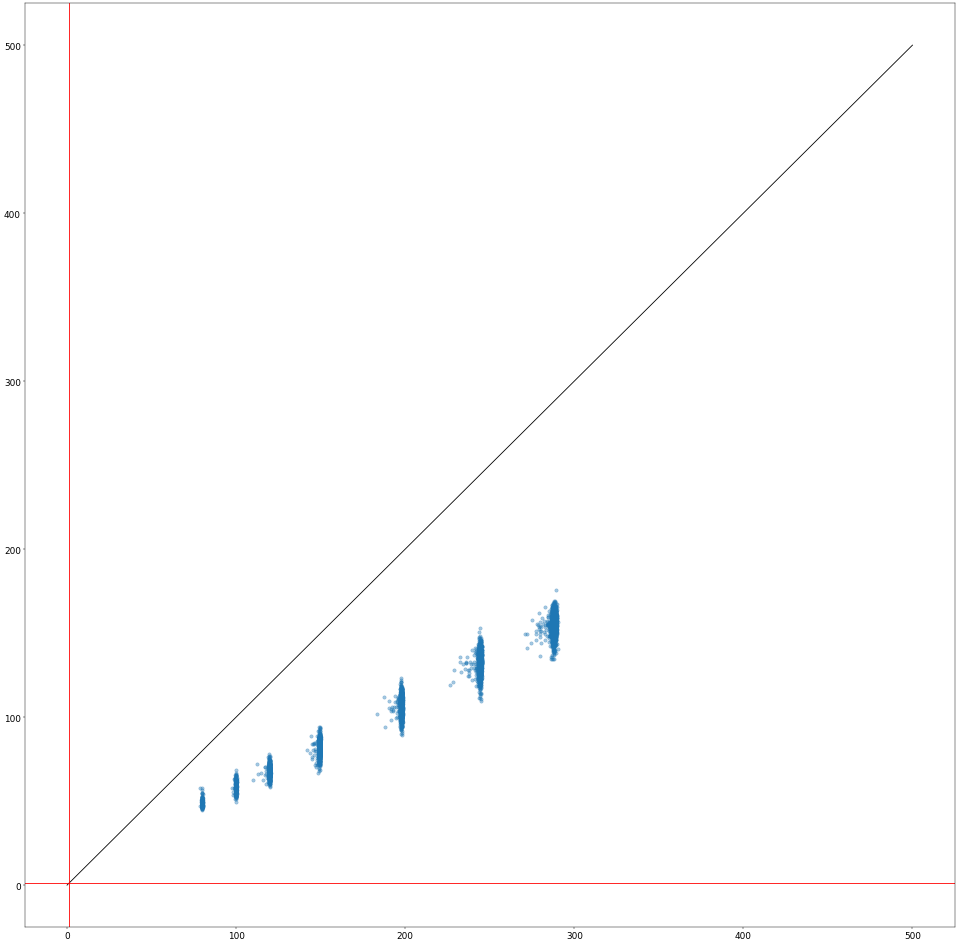

epoch: 46


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 3849.1241545874227


100%|██████████| 61/61 [00:03<00:00, 16.35it/s]


batches for test: 61
test loss: 12071.694912269468
pred - true / true mean: -0.4598393
pred - true / true std: 0.028592506
mu,sig: -0.4598393 0.028592506


<Figure size 640x480 with 0 Axes>

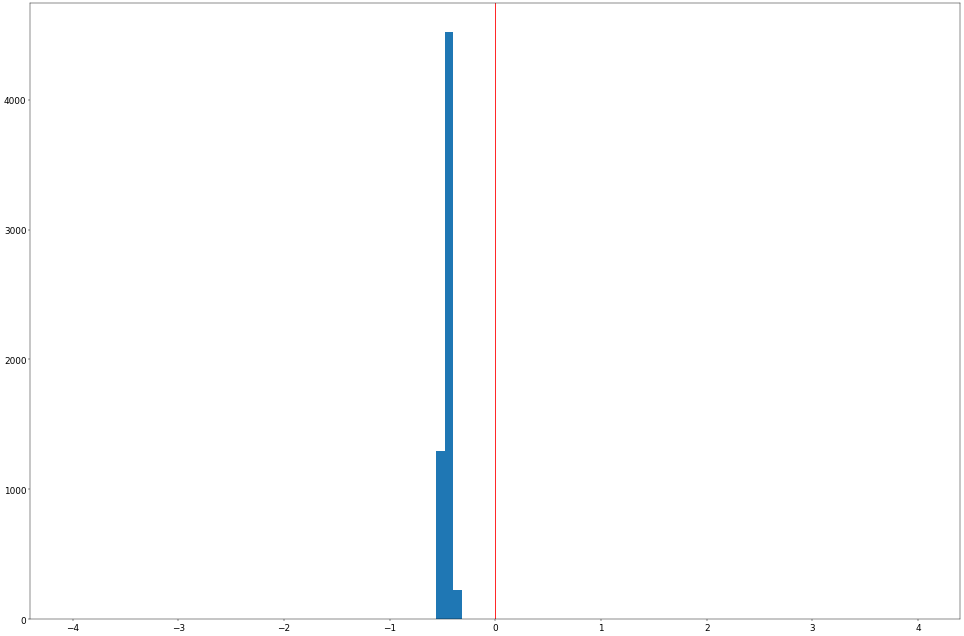

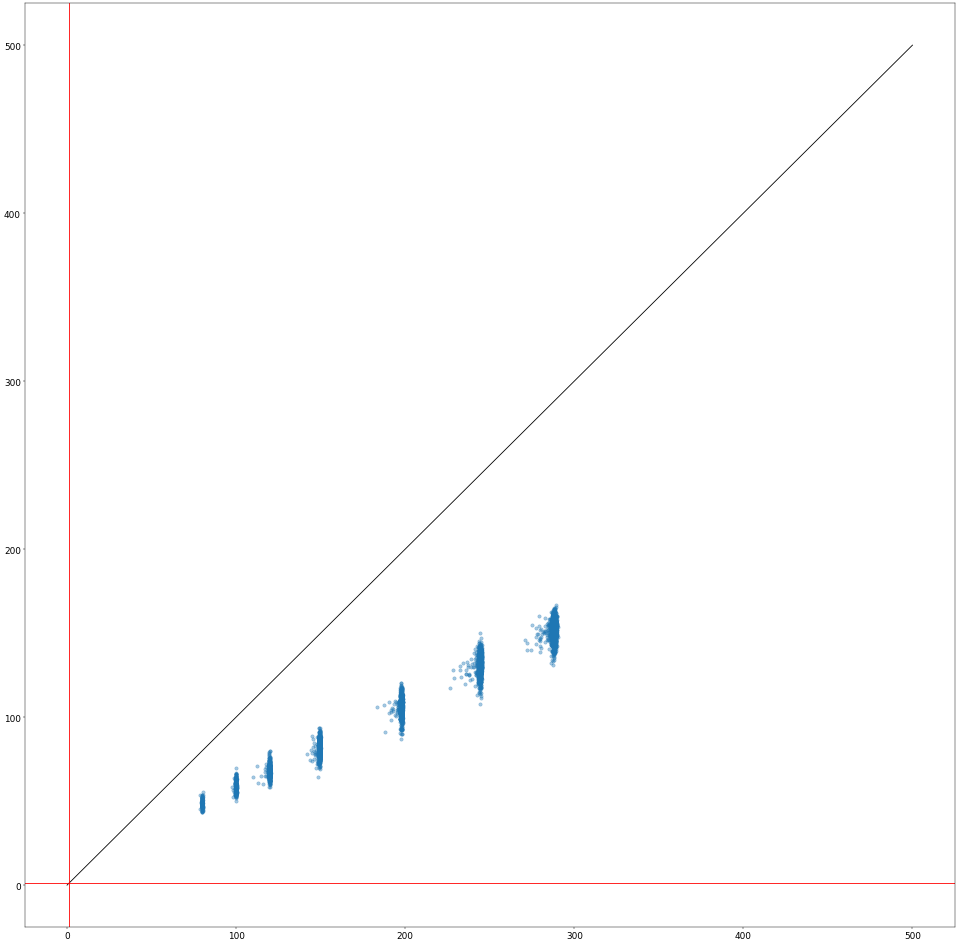

epoch: 47


100%|██████████| 121/121 [00:16<00:00,  7.28it/s]


batches for train: 121
train loss: 3900.013738458807


100%|██████████| 61/61 [00:03<00:00, 16.45it/s]


batches for test: 61
test loss: 11479.010470030738
pred - true / true mean: -0.44745576
pred - true / true std: 0.029888269
mu,sig: -0.44745576 0.029888269


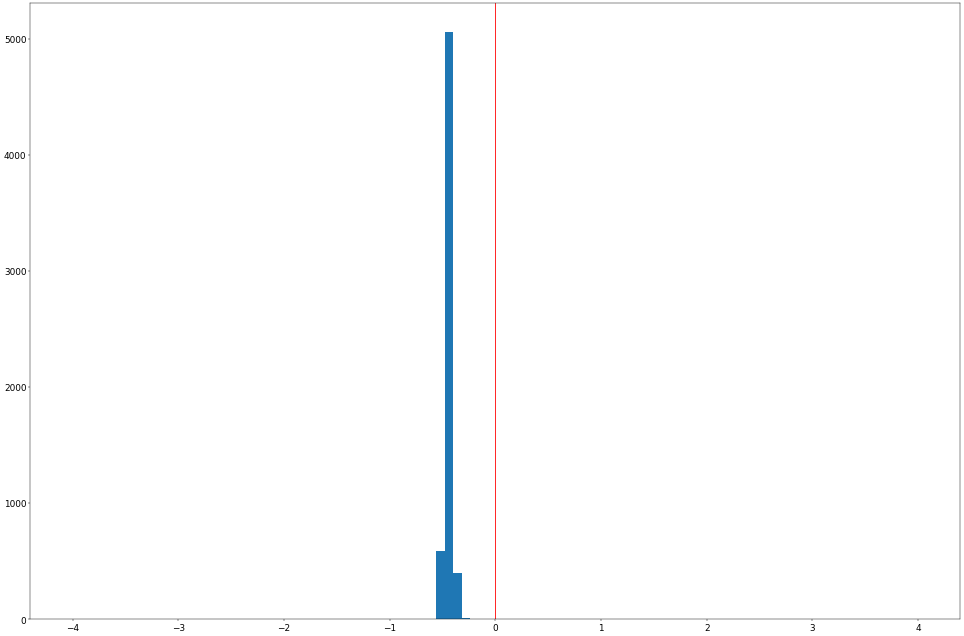

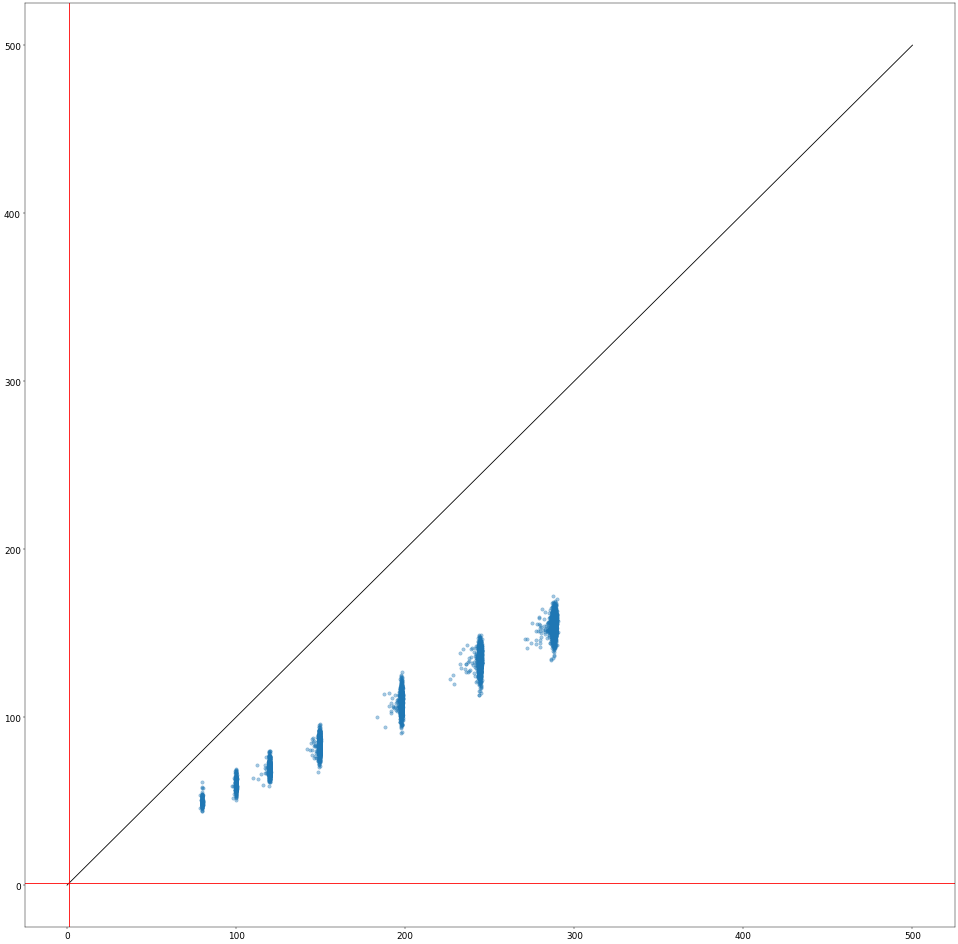

new best test loss: 11479.010470030738
epoch: 48


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 3859.2274946732955


100%|██████████| 61/61 [00:03<00:00, 15.66it/s]


batches for test: 61
test loss: 12065.548892161885
pred - true / true mean: -0.4596594
pred - true / true std: 0.029485278
mu,sig: -0.4596594 0.029485278


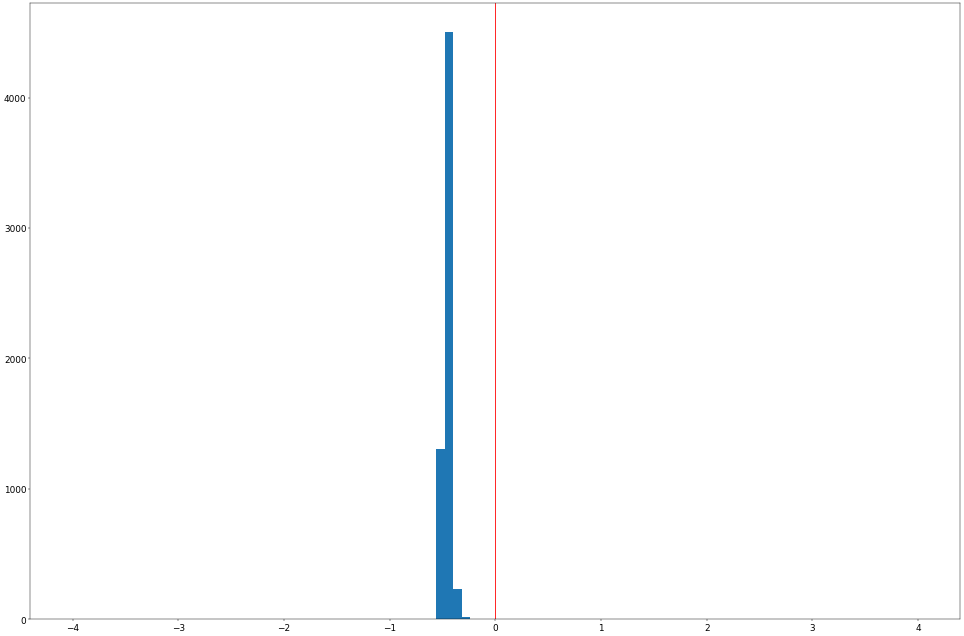

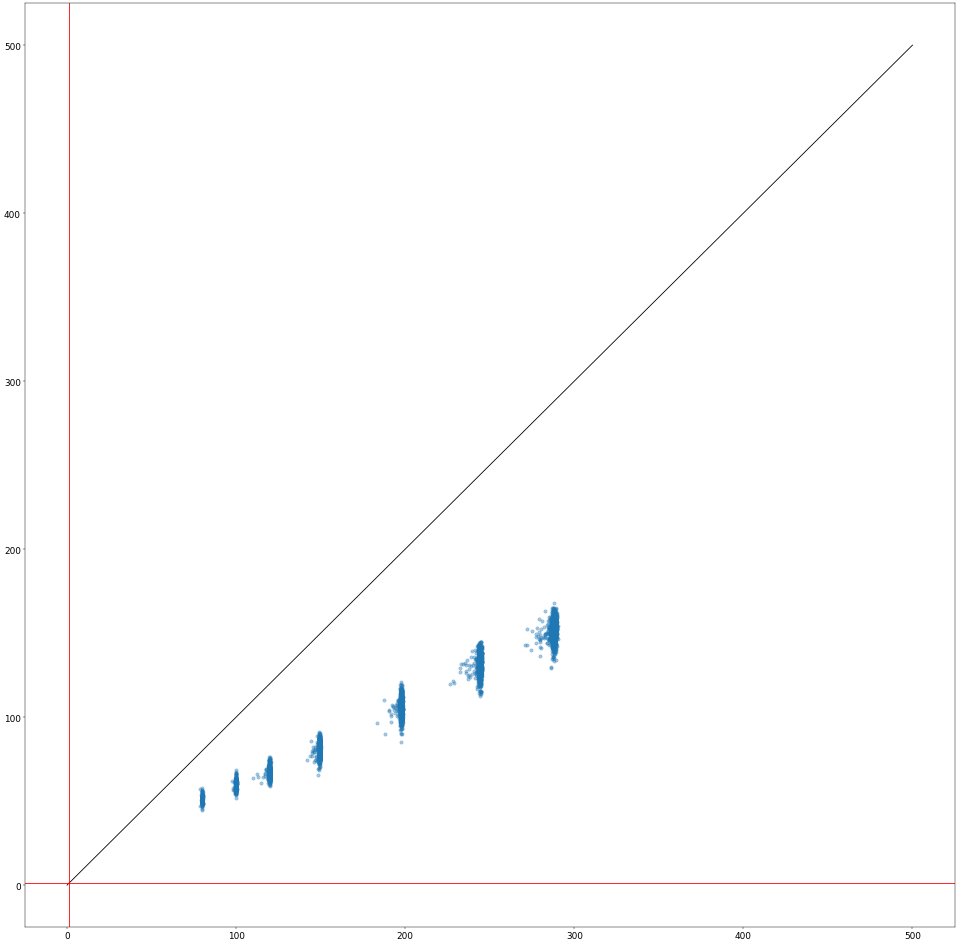

epoch: 49


100%|██████████| 121/121 [00:16<00:00,  7.22it/s]


batches for train: 121
train loss: 3856.134394369835


100%|██████████| 61/61 [00:03<00:00, 15.45it/s]


batches for test: 61
test loss: 12308.26500064037
pred - true / true mean: -0.46899778
pred - true / true std: 0.023497894
mu,sig: -0.46899778 0.023497894


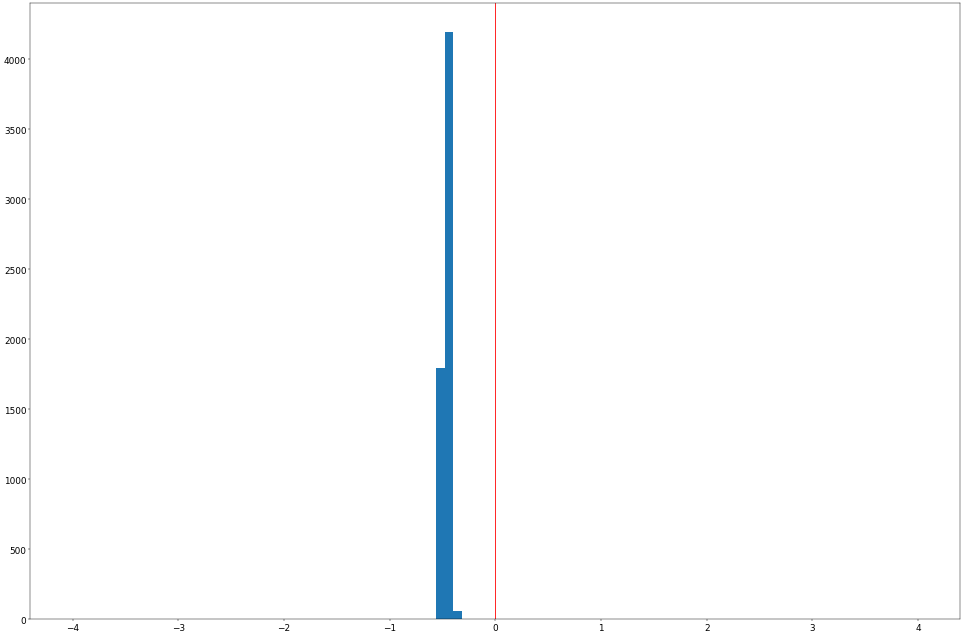

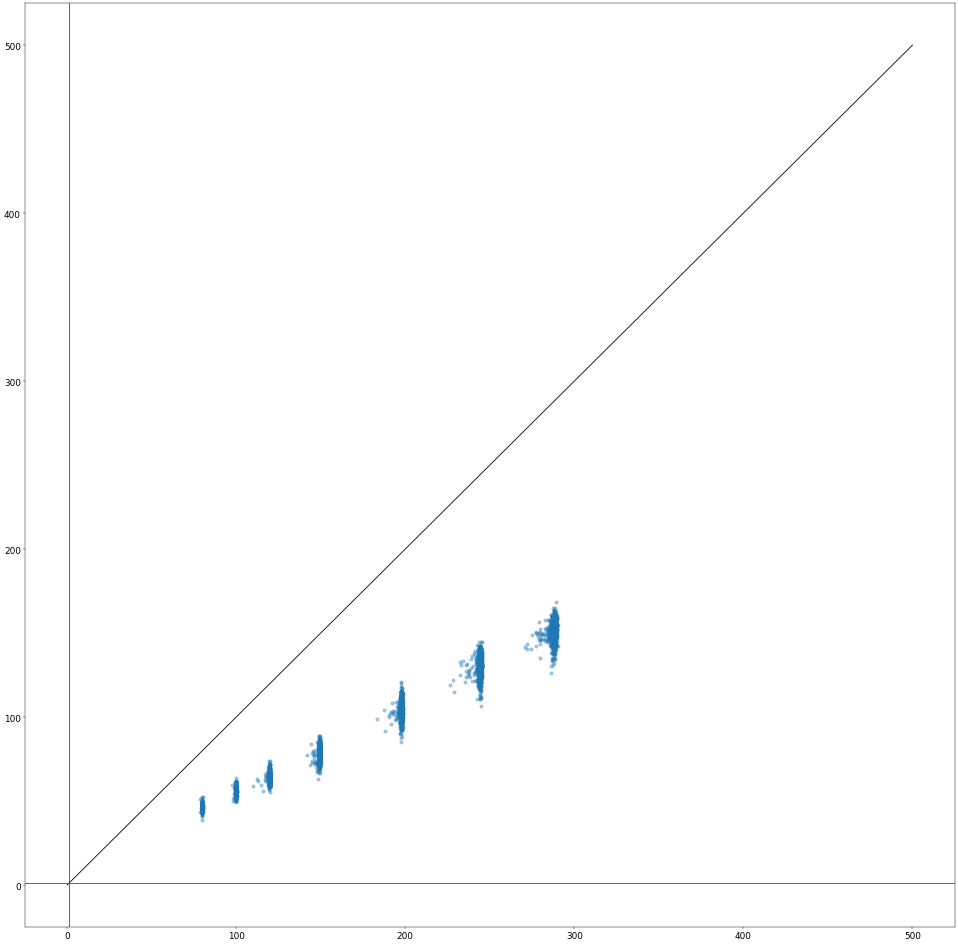

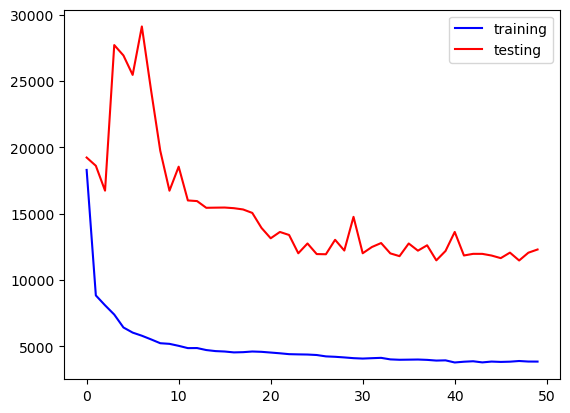

epoch: 50


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 3804.217979241994


100%|██████████| 61/61 [00:03<00:00, 16.22it/s]


batches for test: 61
test loss: 12080.768522669057
pred - true / true mean: -0.46143314
pred - true / true std: 0.026677754
mu,sig: -0.46143314 0.026677754


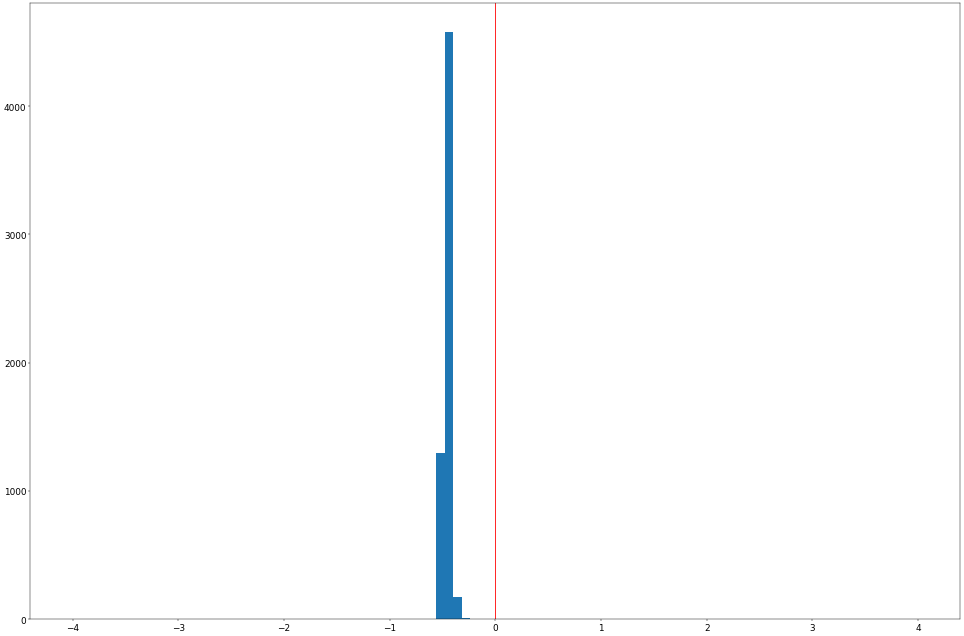

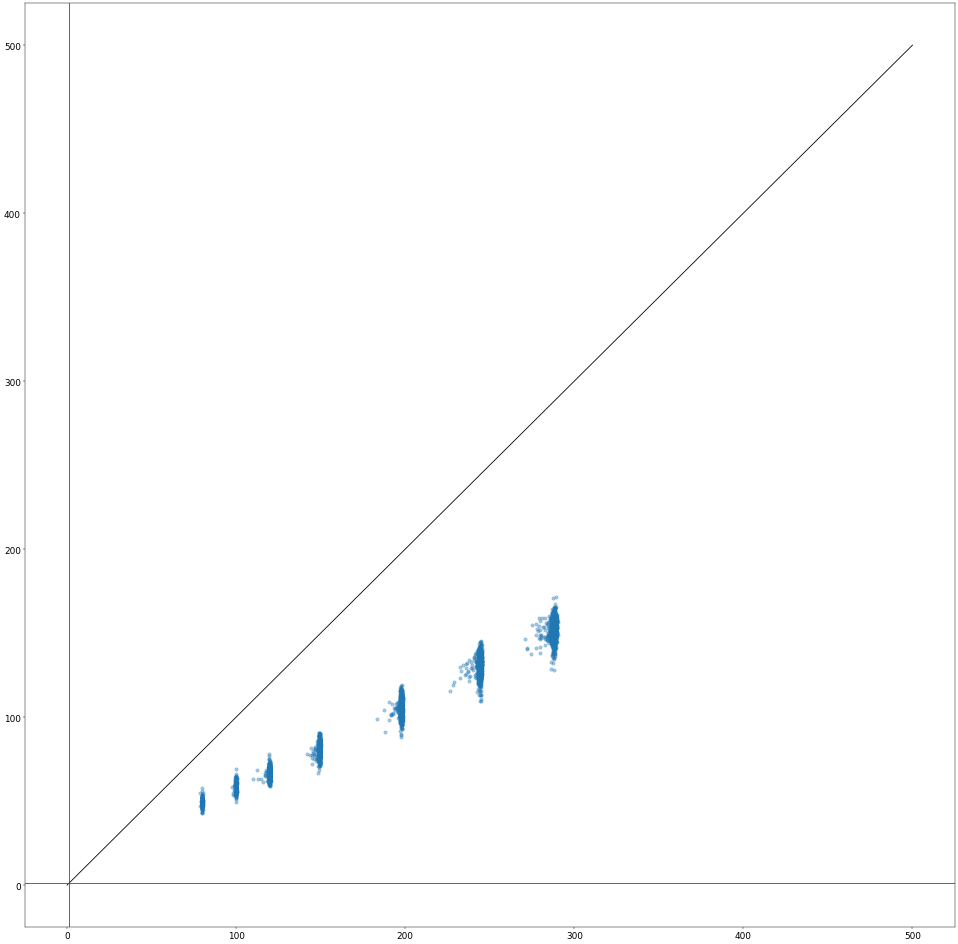

epoch: 51


100%|██████████| 121/121 [00:16<00:00,  7.24it/s]


batches for train: 121
train loss: 3903.8574198573087


100%|██████████| 61/61 [00:03<00:00, 15.55it/s]


batches for test: 61
test loss: 11359.766665599385
pred - true / true mean: -0.44875768
pred - true / true std: 0.025228292
mu,sig: -0.44875768 0.025228292


<Figure size 640x480 with 0 Axes>

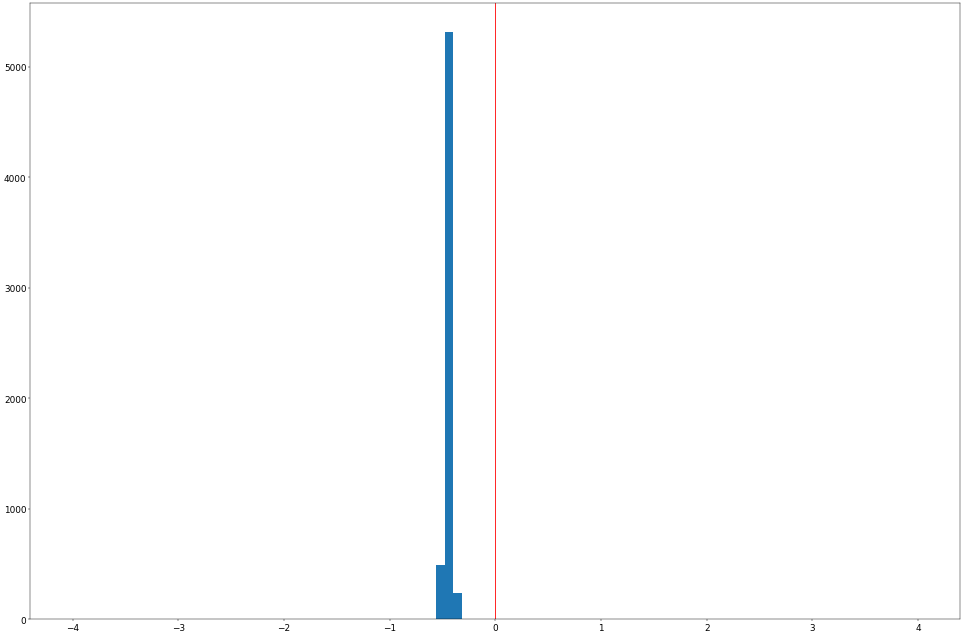

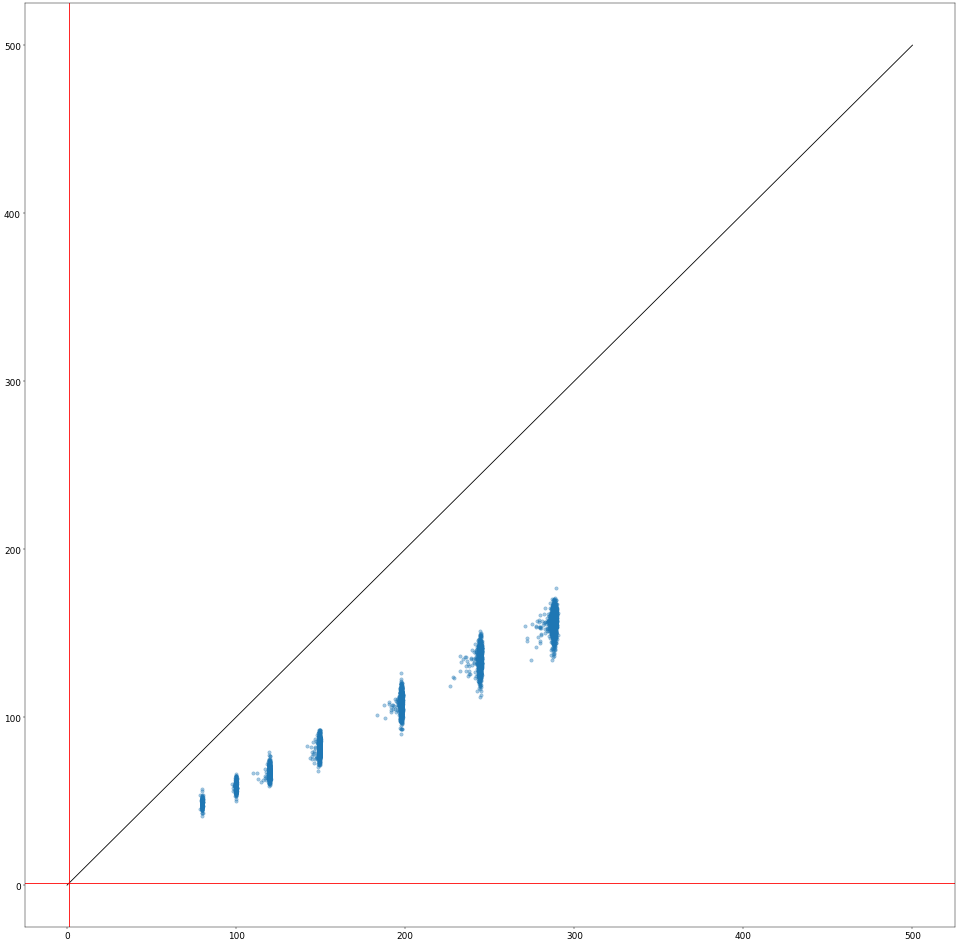

new best test loss: 11359.766665599385
epoch: 52


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 3781.1101861118286


100%|██████████| 61/61 [00:03<00:00, 16.34it/s]


batches for test: 61
test loss: 11884.31382876537
pred - true / true mean: -0.4560559
pred - true / true std: 0.029257393
mu,sig: -0.4560559 0.029257393


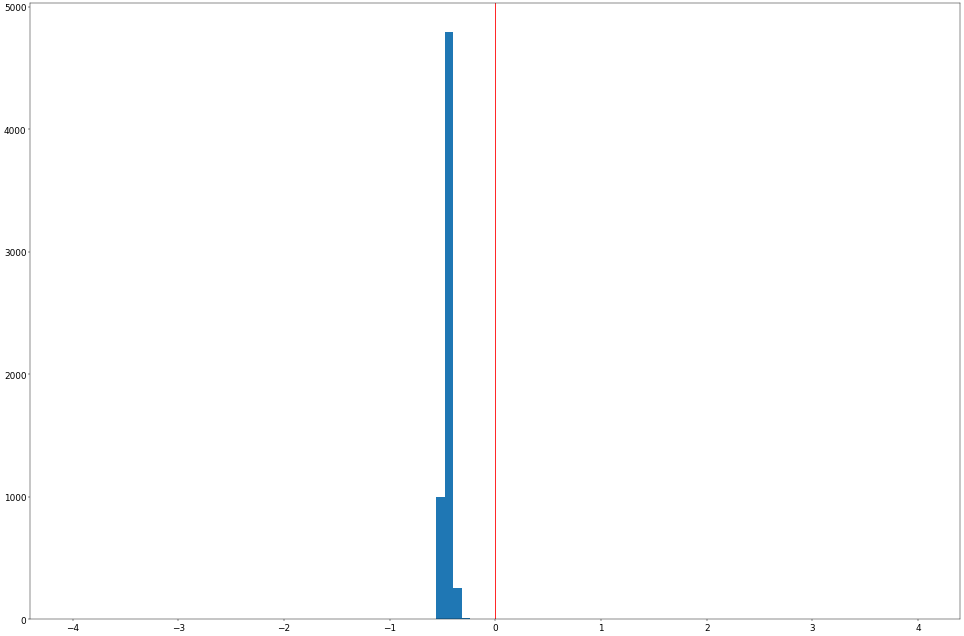

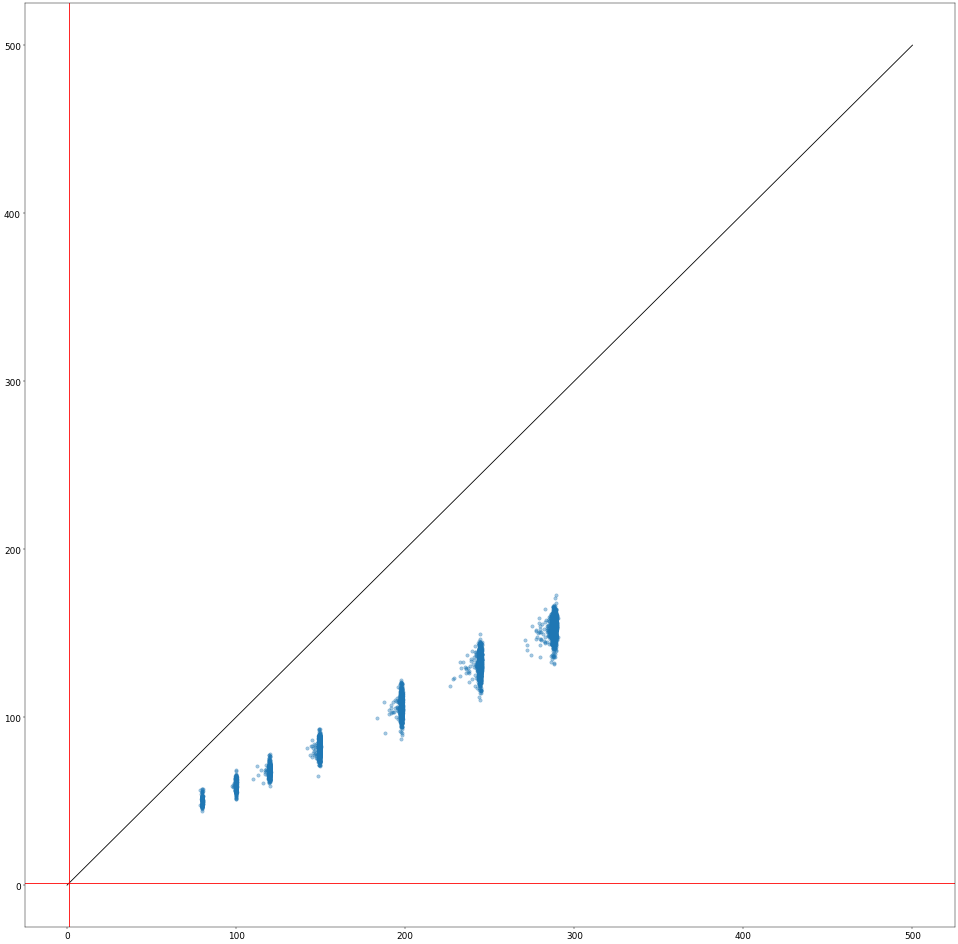

epoch: 53


100%|██████████| 121/121 [00:16<00:00,  7.20it/s]


batches for train: 121
train loss: 3724.280953399406


100%|██████████| 61/61 [00:03<00:00, 16.35it/s]


batches for test: 61
test loss: 11235.315189549181
pred - true / true mean: -0.44460556
pred - true / true std: 0.026420446
mu,sig: -0.44460556 0.026420446


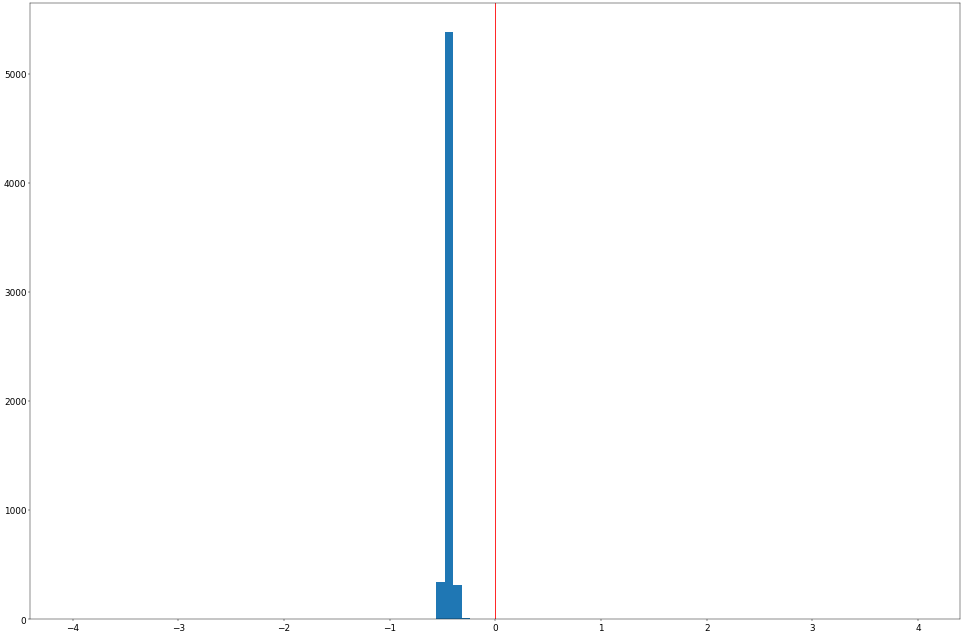

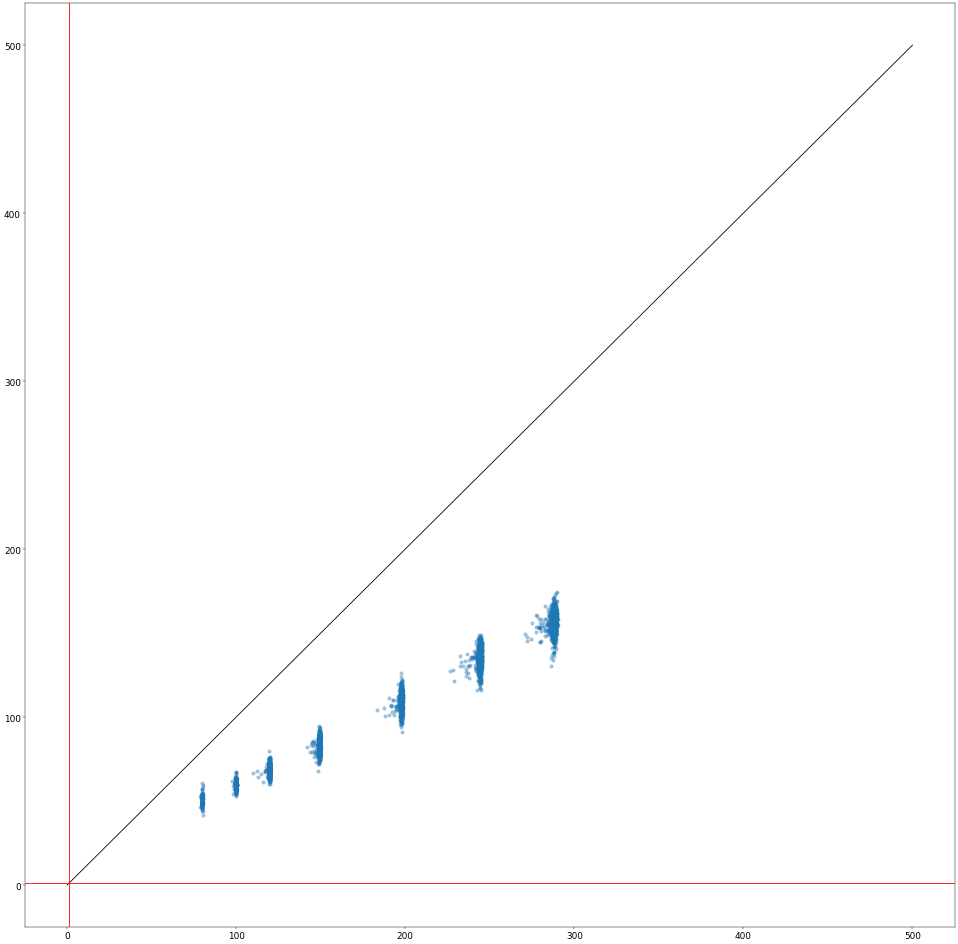

new best test loss: 11235.315189549181
epoch: 54


100%|██████████| 121/121 [00:16<00:00,  7.23it/s]


batches for train: 121
train loss: 3797.3379007134554


100%|██████████| 61/61 [00:03<00:00, 16.32it/s]


batches for test: 61
test loss: 11701.831631019468
pred - true / true mean: -0.45536894
pred - true / true std: 0.02584781
mu,sig: -0.45536894 0.02584781


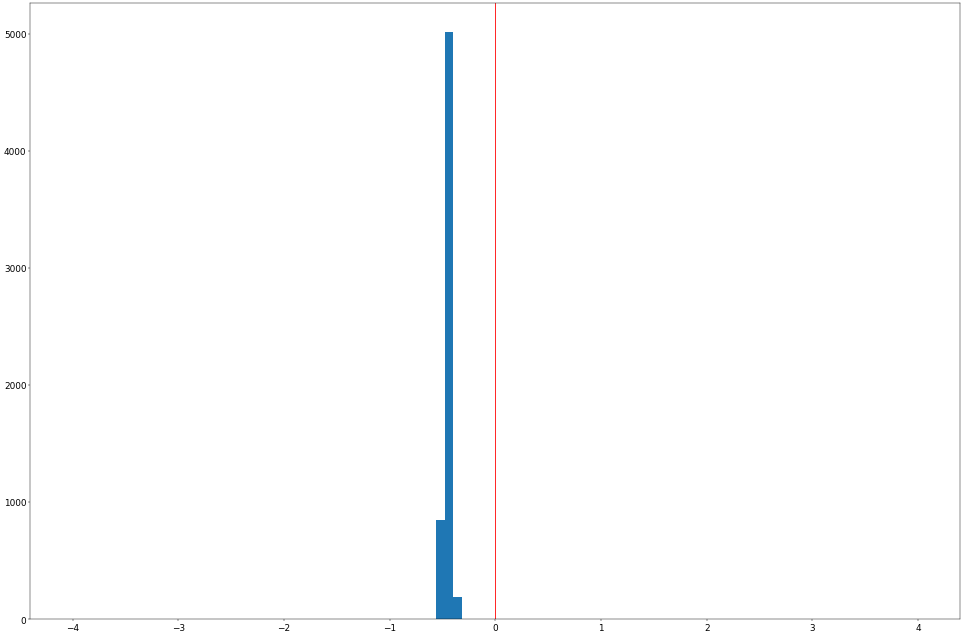

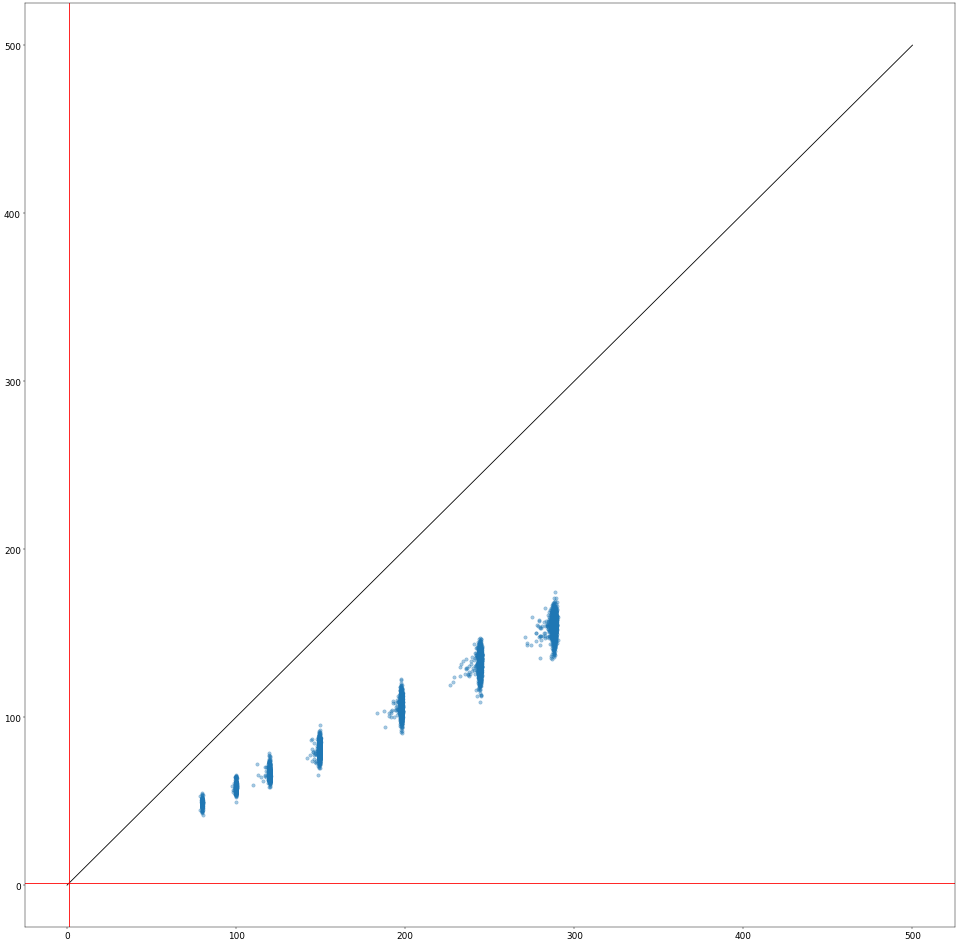

epoch: 55


100%|██████████| 121/121 [00:16<00:00,  7.23it/s]


batches for train: 121
train loss: 3721.1871065502323


100%|██████████| 61/61 [00:03<00:00, 16.37it/s]


batches for test: 61
test loss: 11799.172323258197
pred - true / true mean: -0.45489404
pred - true / true std: 0.028107757
mu,sig: -0.45489404 0.028107757


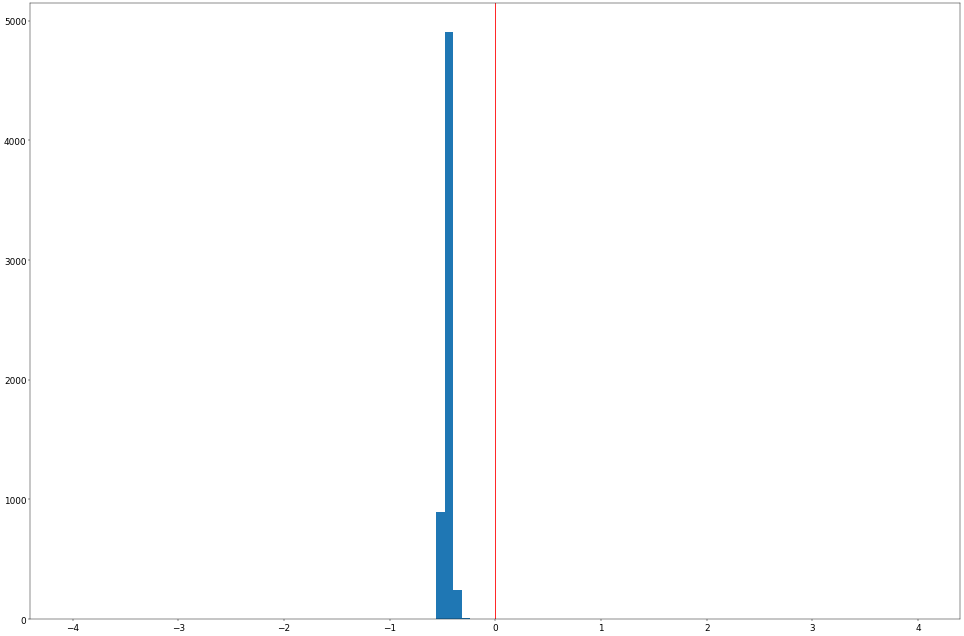

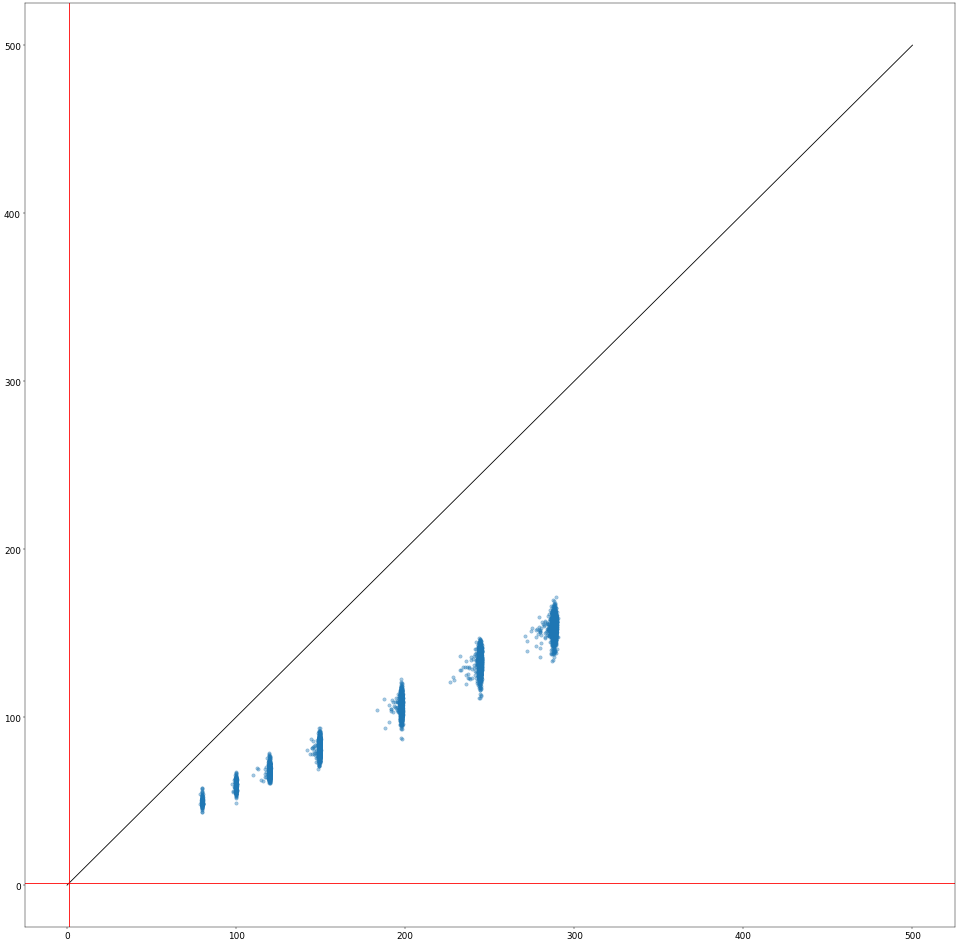

epoch: 56


100%|██████████| 121/121 [00:16<00:00,  7.25it/s]


batches for train: 121
train loss: 3740.2437148921745


100%|██████████| 61/61 [00:03<00:00, 16.00it/s]


batches for test: 61
test loss: 12444.04602651127
pred - true / true mean: -0.46952647
pred - true / true std: 0.024924103
mu,sig: -0.46952647 0.024924103


<Figure size 640x480 with 0 Axes>

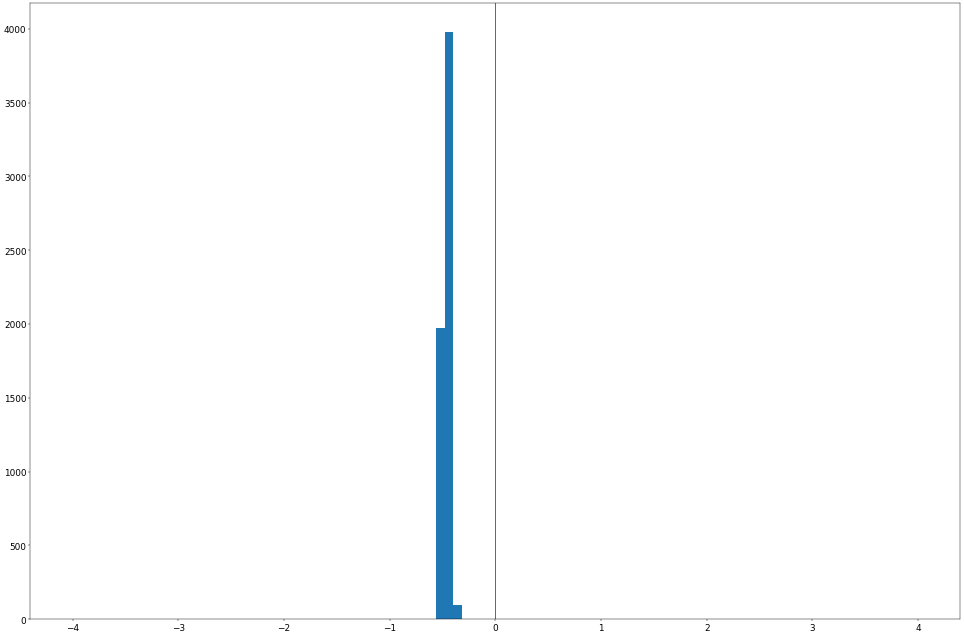

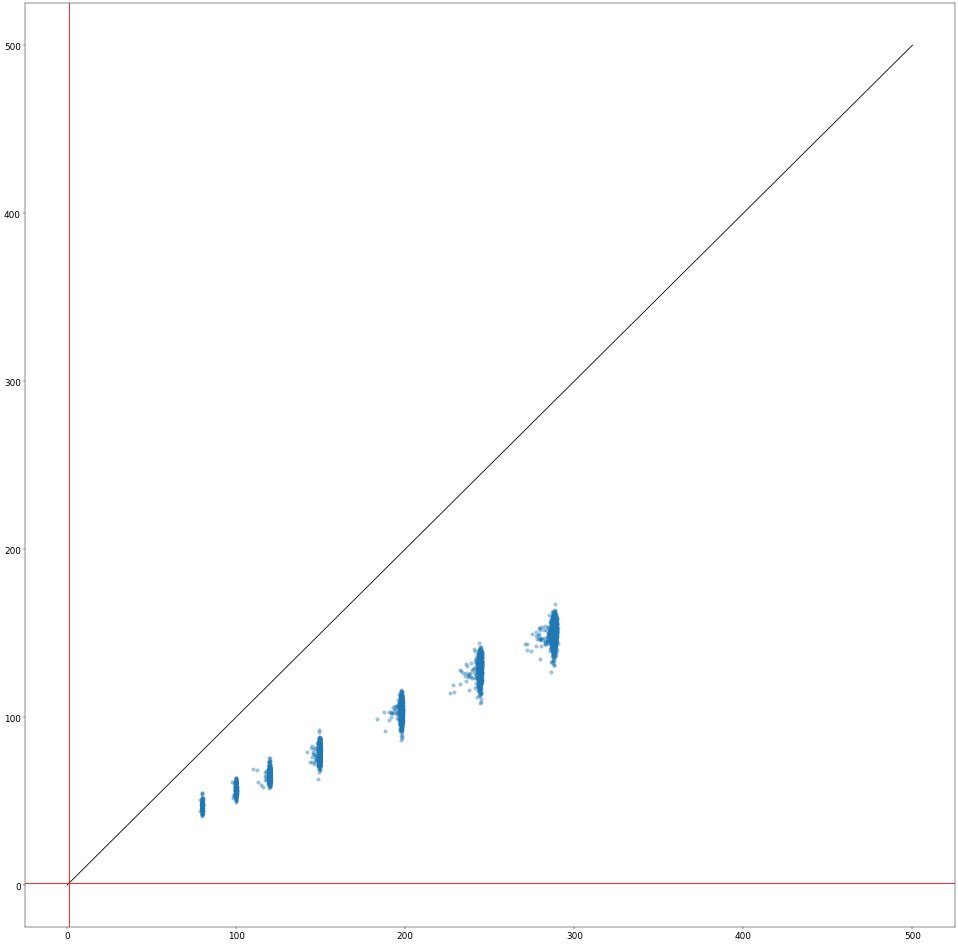

epoch: 57


100%|██████████| 121/121 [00:16<00:00,  7.28it/s]


batches for train: 121
train loss: 3841.4155031314567


100%|██████████| 61/61 [00:03<00:00, 16.19it/s]


batches for test: 61
test loss: 12487.51954725922
pred - true / true mean: -0.46883896
pred - true / true std: 0.026813785
mu,sig: -0.46883896 0.026813785


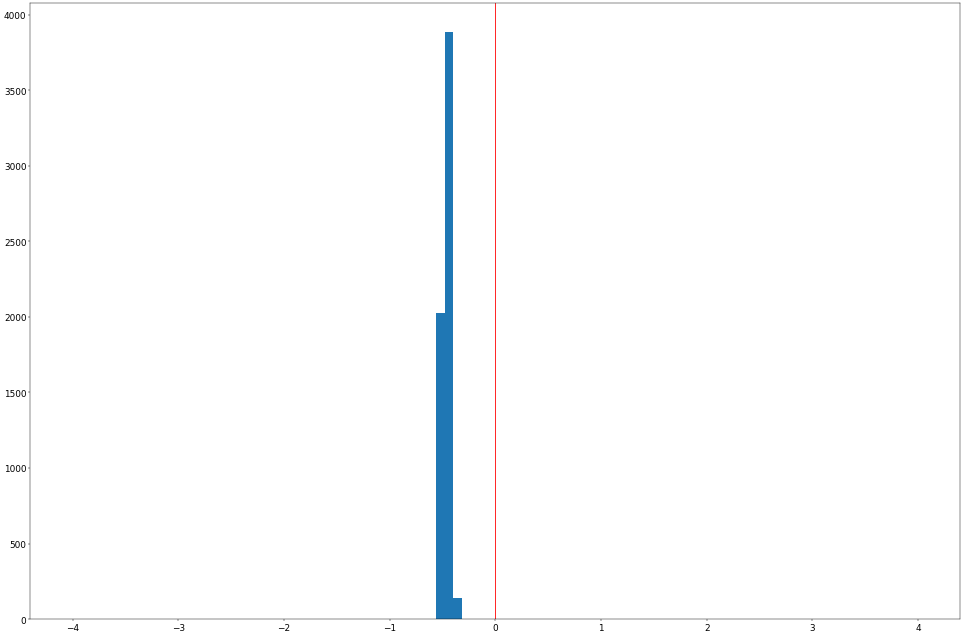

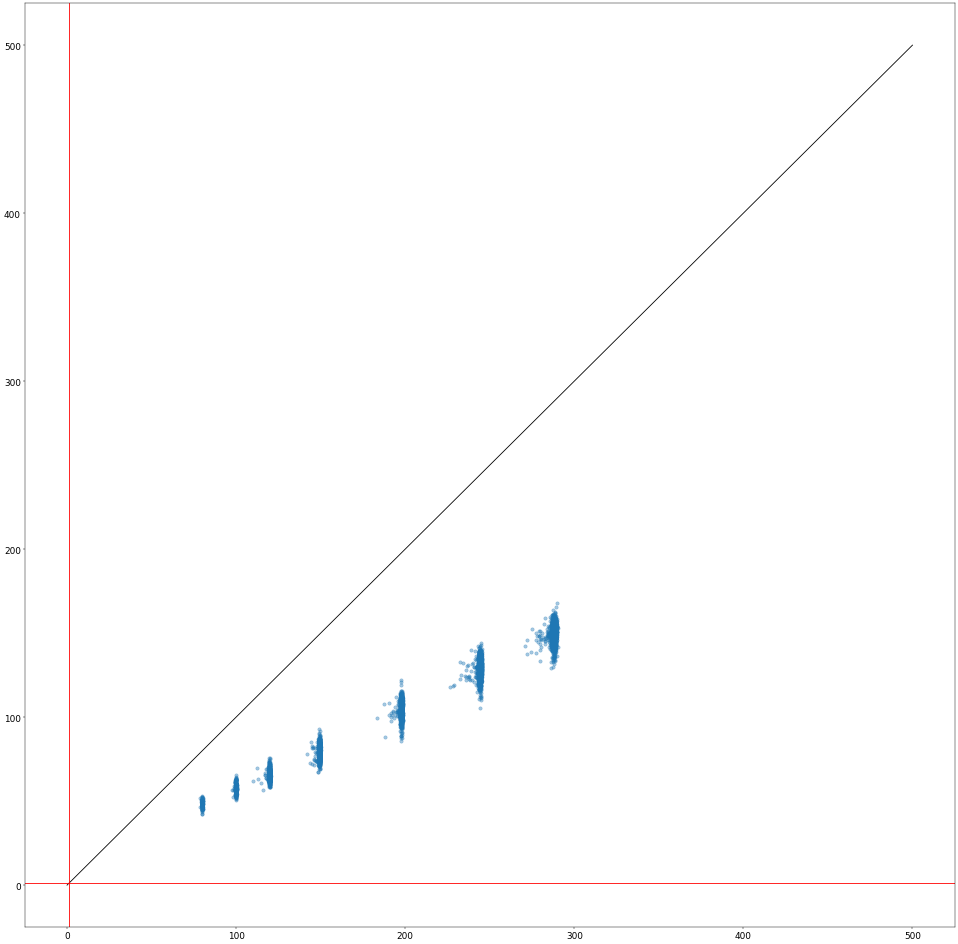

epoch: 58


 60%|█████▉    | 72/121 [00:10<00:06,  7.18it/s]


KeyboardInterrupt: 

In [49]:
#from tqdm import notebook.tqdm as tqdm
#import tqdm.notebook.tqdm as tqdm
#checkpoint_dir = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_testtesttesttest_dyn2addlayer/'
#checkpoint_dir = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_add1ip1dyn_binresoloss/'
#"/home/llr/cms/sghosh/GNNECAL/model_nopho_deepernet/"
checkpoint_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression/models/testmodel1/"
plot_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression/models/testmodel1/"
nepoch=500
os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
""" Training loss for each epoch """
lossv = []
""" Validation loss for each epoch"""
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        if ((epoch+1) == nepoch):
            plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()

 

In [ ]:
device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')
#checkpoint_dir = '/export/home/phys/aharilal/MassRegressor/a2gg-regression/MODELS/GNN_scale50/'
ep_test=299
model_fname = checkpoint_dir + '/model_epoch_%d.pth.tar'%ep_test
model= Net().to(device)
model.load_state_dict(torch.load(model_fname)['state_dict'])
model.eval()
#model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_phopi_comb_categ/model_cont3_checkpoint_best.pth.tar'
#model_fname = '/home/llr/cms/sghosh/HGCAL_TICL_STUFF/RECOTESTS_ORGANISED/MODTICLLXPLUS/CMSSW_11_2_0_pre10/src/RecoNtuples/HGCalAnalysis/test/GENGRAPHS/ouput_classification_PU_LC3213/model_checkpoint_best.pth.tar'
#checkpoint_dir = '/home/llr/cms/sghosh/HGCAL_TICL_STUFF/RECOTESTS_ORGANISED/MODTICLLXPLUS/CMSSW_11_2_0_pre10/src/RecoNtuples/HGCalAnalysis/test/GENGRAPHS/ouput_PU_morestats_ptweight/'

#model_fname = checkpoint_dir + 'model_checkpoint_best.pth.tar'
model_fname = checkpoint_dir + 'model_epoch_299.pth.tar'
mdl=Net().to(device)
mdl.load_state_dict(torch.load(model_fname)['state_dict'])
mdl.eval()
print(sum(p.numel() for p in model.parameters()))
loss_epoch = evaluate(epoch)